# Impact of Burnout Syndrome on the Performance of Care Workers in Colombia

**Abstract:** In this project I cleaned the results of psychosocial behavior surveys of care and non-care workers in Colombia. Then, I realized data and correlation analysis to establish: whether caring professionals in Colombia are more affected by the symptoms of Burnout syndrome than the group of non-care professionals, find a relationship of burnout symptoms on inhibitory control, between both groups, and establish the relationship between burnout symptoms and psychosocial risk.

**Resumen:** En este proyecto se realizó la limpieza de los resultados de encuentas de comportamiento psicosocial a trabajadores asistenciales y no asistenciales en Colombia. Luego, se realizó un análisis datos y de correlación para establecer si los profesionales asistenciales de Colombia se ven más afectados por los sintomas del sindrome de Burnout que el grupo de profesionales no asistenciales, establecer el impacto de los sintomas de burnout en el control inhibitorio, entre ambos grupos y establecer la relación entre los sintomas de burnout y el riesgo psicosocial.  

## Tabla de Contenidos <a id='table_contents'></a>
#### [1. Preliminares](#preliminars)
&nbsp; [**1.1** Funciones Definidas para el Análisis](#predefined_functions) \
&nbsp; [**1.2** Distribución - variables de control](#variables_control) \
&nbsp; [**1.3** Hipótesis 1](#Hipotesis_1) \
&nbsp; &nbsp; *Prevalencia de síntomas de Burnout en profesionales asistenciales vs. no asistenciales* \
&nbsp; [**1.4** Hipótesis 2](#Hipotesis_2) \
&nbsp; &nbsp; *Impacto de los síntomas de Burnout en el control inhibitorio* \
&nbsp; [**1.5** Hipótesis 3](#Hipotesis_3) \
&nbsp; &nbsp; *Impacto de los componente del Burnout en el control inhibitorio* \
&nbsp; [**1.6** Hipótesis 4](#Hipotesis_4) \
&nbsp; &nbsp; *Asociación del liderazgo con el desarrollo del Burnout*

# Preliminares
## Importaciones de librerias

In [2]:
# Operational Imports
from scipy import stats
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import mannwhitneyu

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

# Modelling imports
from scipy.stats import levene
from statsmodels.multivariate.manova import MANOVA
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import PLSRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import  cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")
start = '\033[1m'
end = '\033[0m'

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


**Variables del proyecto:**
```
.
├── Despersonalización, Agotamiento y Realización
│   │ 
│   └── Componentes del Burnout
│
├── Número de Aciertos, Tiempo de Respuesta
│   │
│   └── Control Inhibitorio
│
└──  Liderazgo (Lid_total), Factores Control (CT: total, clari, op), 
    Demandas (DEMA: riesgo, carga, sitio, emo), F. Recompensa
    (reco: total, pert, comp), F. Extralaborales (EXT: casa, zona)
     │
     └── Riesgo Psicosocial
```

# Funciones Definidas para el Análisis <a id='predefined_functions'></a> 

In [12]:
def distribucion(col):
    '''
    Esta función genera el histograma y la función de densidad de 
    probabilidad de la variable col y de los grupos generados a 
    partir de la variable 'catprofesi' (Tipos de profesionales: 
    Asistenciales y no asistenciales)
    
    Parametros
    ----------
    col: str
        Nombre de la columna
    '''
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 5))

    # Distribucion de la variable col
    print(start + f'Variable {col}' + end)
    axs[0,0].set_title(f'Histograma de {col}')
    sns.histplot(df[col], kde=True, ax = axs[0,0])
    axs[0, 0].set_xlabel('')
    axs[0,1].set_title(f'Distribución densidad de {col}')
    sns.kdeplot(df[col], ax=axs[0,1])
    axs[0, 1].set_xlabel('')
    
    # Distribucion col divida por tipo de profesional 
    sns.histplot(data= df, x=col, kde=True, ax=axs[1,0], hue='catprofesi')
    sns.kdeplot(data= df, x=col, ax=axs[1,1], hue='catprofesi')
    axs[1, 0].legend(labels= ['asistencial', 'no asistencial'])
    axs[1, 1].legend(labels= ['asistencial', 'no asistencial'])
    
    plt.show()
    
    # Estadísticas descriptivas
    d = pd.DataFrame({'stat': [], 'test_shapiro': []})
    asistencial = (df['catprofesi'] == 0)
    no_asistencial = (df['catprofesi'] == 1)
    stat, p_value = stats.shapiro(df[col])
    d.loc[0] = stat, p_value
    stat, p_value = stats.shapiro(df[asistencial][col])
    d.loc[1] = stat, p_value
    stat, p_value = stats.shapiro(df[no_asistencial][col])
    d.loc[2] = stat, p_value
    d = d.rename(index = {0: 'Total', 1: 'Asistencial', 2: 'No asistencial'})
    
    
    stat, p= mannwhitneyu(df[asistencial][col], df[no_asistencial][col])
    
    
    # Resultados
    print(start + f'Resultados test shapiro - {col}' + end)
    print(d)
    print('')
    print(f"Resultado Mann-Whitney test: {stat}")
    print(f"P-valor asociado: {p}")
    
    # Coeficiente Cohen_d 
    group1 = df[df['catprofesi'] == 0][col].dropna()
    group2 = df[df['catprofesi'] == 1][col].dropna()

    cohen_d = pg.compute_effsize(group1, group2, eftype='cohen') 
    print('')
    print(f"Medida d de cohen: {cohen_d}")
    
    del stat, p, fig, axs, d, cohen_d, group1, group2

def cohen_d(df, col):
    '''
    Esta función calcula la medida d de cohen de la variable col, 
    a partir de los grupos generados por la variable 'catprofesi' 
    (Tipos de profesionales: Asistenciales y no asistenciales)
    
    Parametros
    ----------
    df: Dataframe
    col: str
        Nombre de la columna
    '''
    
    group1 = df[df['catprofesi'] == 0][col].dropna()
    group2 = df[df['catprofesi'] == 1][col].dropna()

    cohen_d = pg.compute_effsize(group1, group2, eftype='cohen') 
    print(f"Medida d de cohen: {cohen_d}")
    del group1, group2, cohen_d
    
def sumstatsfmt(df):
    '''
    Esta funciٔón es una subrutina que complementa la función descstatscat,
    su principal uso es arreglar el formato de los datos en 'df', el cual
    almacena los resultados estadísticos generados por la anterior función.
    
    Parametros
    ----------
    df: DataFrame
    
    '''
    df.rename(index = {0: 'Asistencial', 1: 'No asistencial', 2: 'Total'}, 
              columns={'count': 'n', 'mean': 'Mean', 'std': 'SD', 'min': 'Min', '25%': 'Q1', '50%': 'Median',
                       '75%': 'Q3', 'max': 'Max'},inplace=True)

    formats = {'n': '{:,.0f}', 'Mean': '{:,.3f}', 'SD': '{:,.3f}', 'Min': '{:,.0f}', 'Q1': '{:,.3f}',
               'Median': '{:,.3f}', 'Q3': '{:,.3f}', 'Max': '{:,.0f}'}
    for col, f in formats.items():
        df[col] = df[col].map(lambda x: f.format(x))
    return df

In [25]:
def descstatscat(column, categorie, mask):
    '''
    Esta función genera un resumen de las estadísticas descriptivas para la variable 'col',
    incluyendo medidas de tendencia central y dispersión. Para realizar el resumen, primero
    se filtran los datos, por medio de la variable 'mask' y se segmentan los datos resultantes
    por la variable 'catprofesi' y 'categorie'.
    
    Parametros
    ----------
    column: str 
        Columna a analizar 
        Nomenclatura, ejemplo: ['despersonalizacion']
    mask: array
        Boolean mask
    categorie: str
        Categoría de la variable columns
    '''
    
    columns = []
    columns.append(column)
    columns.append('catprofesi')
    columns_to_delete = [col for col in df.columns.to_list() if col not in columns]
    columns.remove('catprofesi')
    pdf = df[mask]
    pdf['catprofesi'] = df['catprofesi'].replace([0,1],[2,2])
    pdf.drop(columns = columns_to_delete, axis=1,inplace=True)
    pdf = pd.concat([pdf, df[mask].drop(columns = columns_to_delete, axis=1)], 
                    ignore_index=True).groupby('catprofesi').describe().sort_index()

    pdf = pdf.unstack().unstack(1).sort_index(level=[0, 1]).rename_axis(index=('Categoría' + ' ' + categorie,
                                                                           'catprofesi'), axis=1)
    pdf = pdf[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    del columns, columns_to_delete, categorie
    return sumstatsfmt(pdf)

In [14]:
def distribucion2(col,labels):
    '''
    Esta función genera un diagrama de barras y circular 
    para la variable col, la cual debe ser categórica, y 
    divide los datos por sus categorías.
    
    Parametros
    ----------
    col: str
        Nombre de la columna categórica
    labels: array
        
    '''
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    
    info = []
    for i in df[col].unique():
        info.append(df[col].value_counts()[i])
    colors = sns.color_palette('pastel')[0:5]

    #Create a bar chart
    axs[0].bar(labels, info, color=colors)
    for i, v in enumerate(info):
        axs[0].text(i, v, str(v), color='black', ha='center')
    plt.grid()
    
    #create pie chart
    axs[1].pie(info , labels = labels, colors = colors, autopct='%.1f%%')

    plt.show()
    del fig, info, labels, colors

In [15]:
def efecto_SB(df, col, categorie):
    '''
    Esta función genera la distribución del número de profesionales de 
    la variable 'col', que se encuentran en la categoría 'categorie' y
    genera la función de densidad de probabilidad de los grupos, para
    finalmente presentar los resultados del test Mann-Whitney.
    
    Parametros
    ----------
    df: Dataframe
    col: str
        variable a analizar
    categorie: str
        Clasificación de la variable col
    '''
    
    info = df['catprofesi'].value_counts()
    labels = ['asistencial', 'no asistencial']
    colors = ['#ffb482', '#a1c9f4']
    print(start + f'Prevalencia de Síntomas de Burnout - {col} {categorie}' + end)
    fig, axs = plt.subplots(1,2, figsize=(9,3))
    
    # Pie chart
    axs[0].pie(info, labels=labels, colors=colors, autopct=lambda x: '{:.0f}'.format(x*info.sum()/100))
    
    # Density plots
    sns.histplot(data= df, x=col, kde=True, ax=axs[1], hue='catprofesi')
    axs[1].legend(labels= ['asistencial', 'no asistencial'])
    
    plt.show()
    asistencial = (df['catprofesi'] == 0)
    no_asistencial = (df['catprofesi'] == 1)
    stat, p= mannwhitneyu(df[asistencial][col], df[no_asistencial][col])
    
    print(start + 'Resultados del test Mann-Whitney' + end)
    print(f"Estadística U de Mann-Whitney: {stat}")
    print(f"P-valor asociado: {p}")
    
    del df, col, info, labels, colors, fig, axs, stat, p, asistencial, no_asistencial

In [16]:
def categoria_SB(col):
    '''
    Esta función genera el diagrama de cajas y bigotes correspondiente a la variable col,
    dividiendo los datos por categoría del SB (Leve, Moderado, Grave) y 'catprofesi' 
    (Tipos de profesionales: Asistenciales y no asistenciales)
    
    Parametros
    ----------
    col: str
        Nombre de la columna
    '''
    
    plt.figure(figsize=(8,5))
    colors = {0: '#ffb482', 1: '#a1c9f4'}
    sns.boxplot(x= col + '_cat', y = col, data = df, hue= 'catprofesi', palette=colors)

    legend=plt.legend(title='Profesionales', loc='upper left')
    legend.get_texts()[0].set_text('Asistencial')
    legend.get_texts()[1].set_text('No Asistencial')
    plt.grid(True)
    plt.show()
    del colors

In [12]:
import os
os.chdir('C:\\Users\\claud\\PythonScripts')
os.environ["OMP_NUM_THREADS"] = "2"
df = pd.read_csv('Datasets\SB_en_ProfesionalesColombia\BD_369.csv', encoding = 'latin-1')
df = df[['catprofesi', 'genero', 'educacion', 'estado', 'despersonalizacion',
        'agotamiento', 'realizacion', 'Lid_total', 'CT_total', 'DEMA_riesgo', 
       'DEMA_carga', 'Dem_sitio', 'Dem_emo', 'Reco_total', 'EXT_casa', 'EXT_zona',
        'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   catprofesi            300 non-null    int64  
 1   genero                300 non-null    int64  
 2   educacion             300 non-null    int64  
 3   estado                300 non-null    int64  
 4   despersonalizacion    300 non-null    int64  
 5   agotamiento           300 non-null    int64  
 6   realizacion           300 non-null    int64  
 7   Lid_total             300 non-null    int64  
 8   CT_total              300 non-null    int64  
 9   DEMA_riesgo           300 non-null    int64  
 10  DEMA_carga            300 non-null    int64  
 11  Dem_sitio             300 non-null    int64  
 12  Dem_emo               300 non-null    int64  
 13  Reco_total            300 non-null    int64  
 14  EXT_casa              300 non-null    int64  
 15  EXT_zona              3

# Distribución de las variables de control <a id='variables_control'></a>

Tipo de profesionales


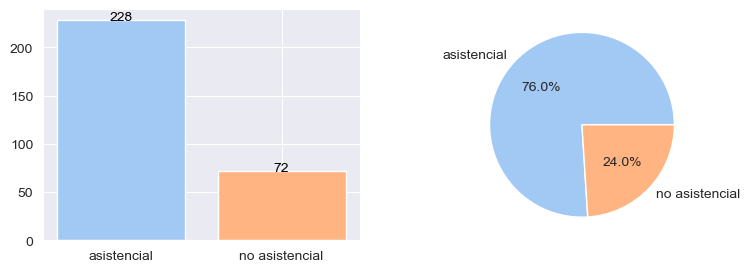

Distribución por género


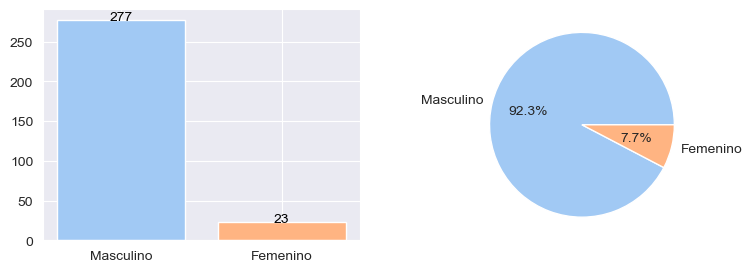

Distribución por nivel educativo


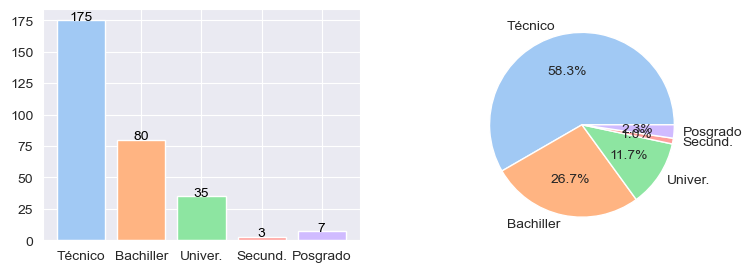

Distribución por estado civíl


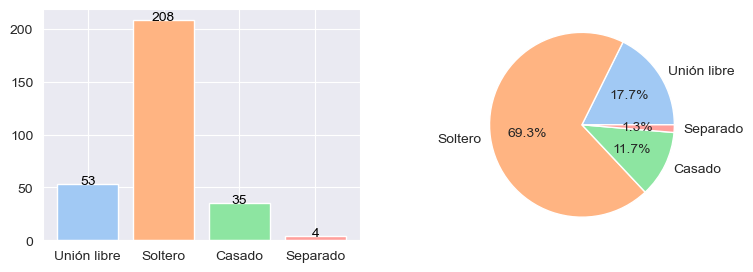

In [1532]:
# Distribución tipos de profesionales
print(start + 'Tipo de profesionales' + end)
labels = ['asistencial', 'no asistencial']
distribucion2('catprofesi', labels)

# Distribución género
labels = ['Masculino', 'Femenino']
print(start + 'Distribución por género' + end)
distribucion2('genero',labels)

# Distribución nivel educativo
print(start + 'Distribución por nivel educativo' + end)
labels= ['Técnico', 'Bachiller', 'Univer.', 'Secund.', 'Posgrado']
distribucion2('educacion', labels)

# Distribución estado civíl
print(start + 'Distribución por estado civíl' + end)
labels= ['Unión libre', 'Soltero', 'Casado', 'Separado']
distribucion2('estado', labels)

Se puede observar ambas variables: catprofesi y genero, reflejan un desbalance en los datos, ya que la categoría menoritaria no supera el 25% del total.

# Hipótesis
### 1. Prevalencia de Síntomas de Burnout en profesionales asistenciales y no asistenciales <a id='Hipotesis_1'></a>

Para evaluar si la prevalencia de síntomas de Burnout difiere significativamente entre profesionales asistenciales y no asistenciales, utilizaremos la prueba de Mann-Whitney y la medida d de cohen. Esto permitirá determinar si hay diferencias significativas en la distribución de síntomas de Burnout entre las dos muestras.

**Test de Normalidad Shapiro - Wilks**
    
El test de Shapiro-Wilks es una prueba de hipótesis emplada para establecer si una variable tiene una distribución normal o no.
    
Las hipótesis definidas por el test son:
    
    - Ho: Hipótesis nula
    
        La distribución es normal
        
    - H1: Hipótesis alternativa
    
        La distribución no es normal

**Mann-Whitney test** 

La prueba U de Mann-Whitney-Wilcoxon se emplea para saber si existe una diferencia en la magnitud entre dos grupos independientes de una variable continua.

Esta prueba establece las siguientes hipótesis:
    
    - Ho: Hipótesis nula
    
        No existe diferencia entre los dos grupos, en términos de sus medias
        
    - H1: Hipótesis alternativa
    
        Existe diferencia entre los dos grupos, en términos de sus medias
    
El estadístico U de esta prueba se defube como:
\begin{align}
U = min \{U_1, U_2 \},
\end{align}
donde 
\begin{align}
U_1 = n_1 n_2 + \dfrac{n_1 (n_1 +1)}{2} - R_1,
\end{align}
\begin{align}
U_2 = n_1 n_2 + \dfrac{n_2 (n_2 +1)}{2} - R_2,
\end{align}
siendo $n_1$ y $n_2$ los tamaños respectivos de cada muestra; $R_1$ y $R_2$ la suma de los rangos respectivos de cada muestra.

**Medida d de cohen** 

La d de Cohen es una medida del "tamaño de efecto", basada en la diferencias entre dos medias.

El valor calculado del tamaño del efecto se compara entonces con los criterios de cohen de efecto de tamaño pequeño, mediano, y grande.

| Tamaño de efecto | d   | Interpretación                       |
|------------------|-----|--------------------------------------|
| Pequeño          | 0.2 | Las medias no difieren               |
| Medio            | 0.5 | Las medias difieren moderadamente    |
| Grande           | 0.8 | Las medias difieren substancialmente |

si d es positivo, el primer grupo tiene una media superior al segundo grupo.

si d es negativo, el efecto se da al contrario.

La d de cohen se calcula como:
\begin{align}
d = \dfrac{\bar{x_1} - \bar{x_2}}{S_{\text{combinada}}}
\end{align}
donde
\begin{align}
S_{\text{combinada}} = \sqrt{\dfrac{(n_1-1)S_1^2 + (n_2-1)S_2^2}{n_1+n_2-2}}
\end{align}

Variable despersonalizacion


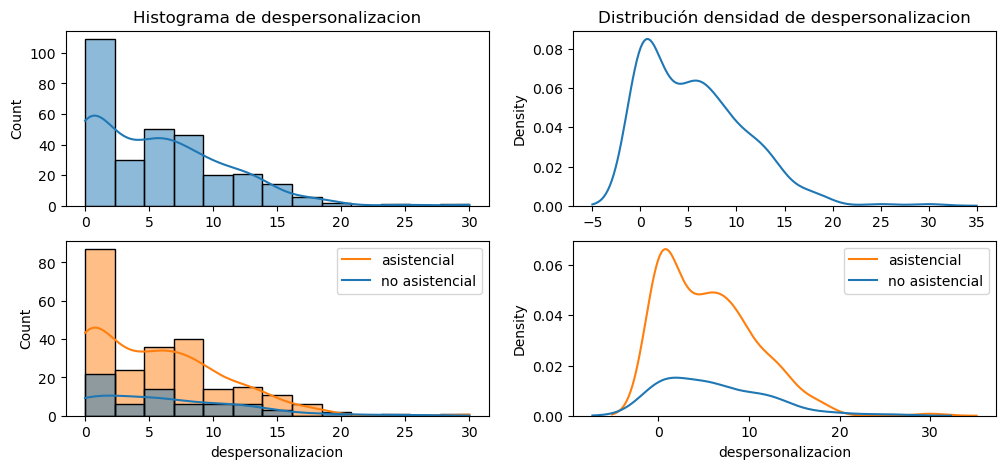

Resultados test shapiro - despersonalizacion
                    stat  test_shapiro
Total           0.899892  3.412569e-13
Asistencial     0.899459  5.976006e-05
No asistencial  0.898202  1.713902e-11

Resultado Mann-Whitney test: 8088.5
P-valor asociado: 0.5529386742621205

Medida d de cohen: 0.11099793307072642
Variable realizacion


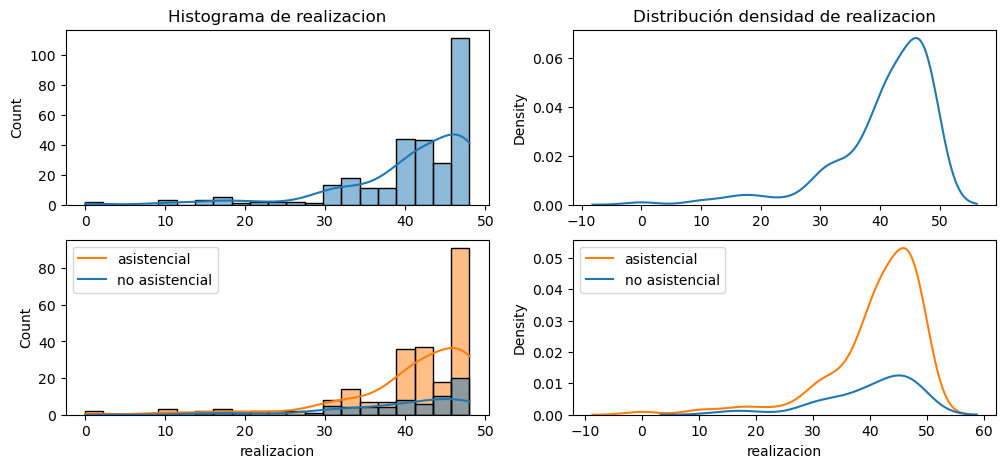

Resultados test shapiro - realizacion
                    stat  test_shapiro
Total           0.784393  1.307888e-19
Asistencial     0.850004  1.213709e-06
No asistencial  0.761501  3.942210e-18

Resultado Mann-Whitney test: 6957.5
P-valor asociado: 0.21677310970520014

Medida d de cohen: -0.11362861563494361
Variable agotamiento


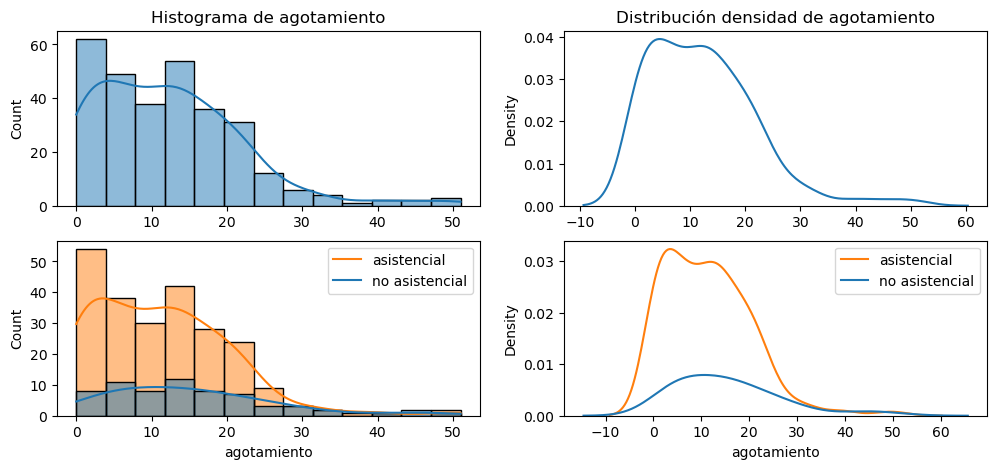

Resultados test shapiro - agotamiento
                    stat  test_shapiro
Total           0.916858  7.546925e-12
Asistencial     0.919776  3.927428e-04
No asistencial  0.921506  8.506831e-10

Resultado Mann-Whitney test: 9399.0
P-valor asociado: 0.007007667083108965

Medida d de cohen: 0.4296945628767576


In [60]:
distribucion('despersonalizacion')
distribucion('realizacion')
distribucion('agotamiento')

## Interpretación de los resultados

**Resultados de la variable 'despersonalización':**

- Se realizó una prueba de normalidad de Shapiro Wilks para todos los datos de la variable 'despersonalizacion' y a las muestras establecidas al dividir los datos por la variable 'catprofesi' (tipos de profesionales), esta prueba arrojó que ninguna de las anteriores muestras siguen una distribución normal.

- Utilizando el hecho de que ninguna muestra sigue una distribución normal, se empleó una prueba U de Mann-Whitney para saber si existen diferencias entre las medias de los grupos 'asistenciales' y 'no asistenciales', esta prueba resultó negativo, lo cual indica que no existen diferencias significativas entre los dos grupos, en términos de sus medias.

- Por último se calculó la medida d de cohen para cuantificar el efecto del tamaño en la diferencia entre las medias de los grupos, el resultado fue una medida de: 0.03, lo cual indica un efecto despreciable.

**Resultados de la variable 'realización'**

- Los resultados del test de Shapiro Wilks se observa nuevamente que ninguna de las muestras sigue una distribución normal.

- Los resultados de la prueba U de Mann Whitney nuevamente arrojaron que no existen diferencias significativas entre los dos grupos.

- Y la medida d de cohen tuvo una magnitud de 0.15, lo cual indica un efecto pequeño entre las medias.

**Resultados de la variable 'agotamiento'**

- Los resultados del test de Shapiro Wilks se observa nuevamente que ninguna de las muestras sigue una distribución normal.

- Tomando un nivel de significacia de 0.05, los resultados de la prueba U de Mann Whitney nuevamente arrojan que no existen diferencias significativas entre los dos grupos.

- Y la medida d de cohen tuvo una magnitud de -0.09, lo cual indica un efecto despreciable entre las medias.

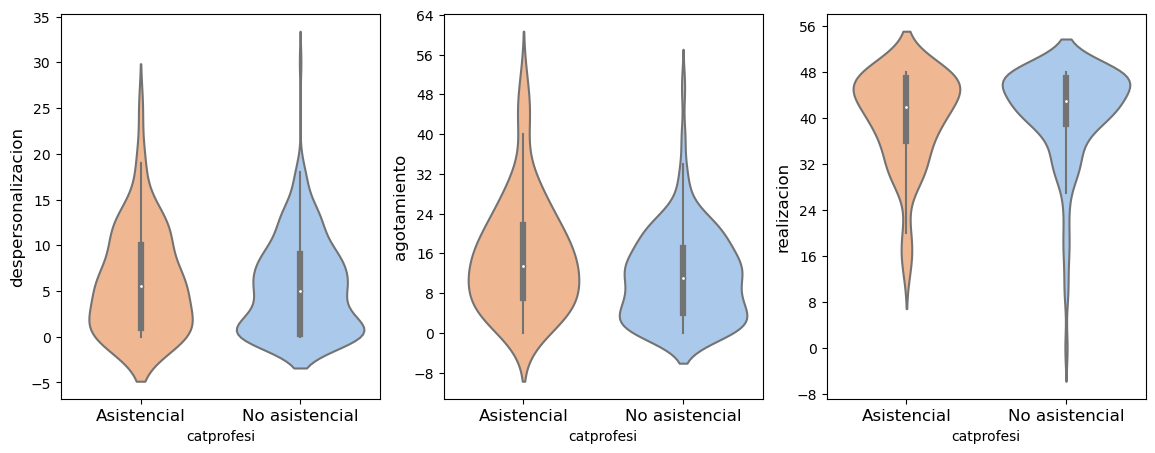



Estadísticas descriptivas:



n    Mean      SD Min      Q1  Median  \
Numerical features catprofesi                                                
agotamiento        Asistencial      66  15.455  11.243   0   7.000  13.500   
                   No asistencial  234  11.333   9.077   0   4.000  11.000   
                   Total           300  12.240   9.726   0   4.750  12.000   
despersonalizacion Asistencial      66   6.061   5.618   0   1.000   5.500   
                   No asistencial  234   5.483   5.083   0   0.250   5.000   
                   Total           300   5.610   5.201   0   1.000   5.000   
realizacion        Asistencial      66  39.985   8.271  14  36.000  42.000   
                   No asistencial  234  40.957   8.636   0  39.000  43.000   
                   Total           300  40.743   8.553   0  39.000  43.000   

                                       Q3 Max  
Numerical features catprofesi                  
agotamiento        Asistencial     21.750  51  
                   No asistencial  17.000  51  
                   Total           18.000  51  
despersonalizacion Asistencial     10.000  25  
                   No asistencial   9.000  30  
                   Total            9.000  30  
realizacion        Asistencial     47.000  48  
                   No asistencial  47.000  48  
                   Total           47.000  48

In [61]:
columns = ['despersonalizacion', 'agotamiento', 'realizacion']
y_labels = ['despersonalizacion', 'agotamiento', 'realizacion']
fig, ax = plt.subplots(1,3, figsize=(14,5))

for idx, feature in enumerate(columns):
    sns.violinplot(x='catprofesi', y=feature, data = df, ax=ax[idx], palette=['#ffb482', '#a1c9f4'])
    
    ax[idx].yaxis.set_major_locator(MaxNLocator(integer = True))
    ax[idx].set_xticklabels(['Asistencial', 'No asistencial'], size = 12)
    ax[idx].set_ylabel(y_labels[idx], size = 12)
    
plt.show()

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')
columns.append('catprofesi')
columns_to_delete = [col for col in df.columns.to_list() if col not in columns]
columns.remove('catprofesi')
pdf = df.copy()
pdf['catprofesi'] = df['catprofesi'].replace([0,1],[2,2])
pdf.drop(columns = columns_to_delete, axis=1,inplace=True)
pdf = pd.concat([pdf, df.drop(columns = columns_to_delete, axis=1)], ignore_index=True).groupby('catprofesi') \
    .describe().sort_index()

pdf = pdf.unstack().unstack(1).sort_index(level=[0, 1]).rename_axis(index=('Numerical features',
                                                                           'catprofesi'), axis=1)
pdf = pdf[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

display(sumstatsfmt(pdf))
del columns, columns_to_delete, pdf, fig, ax

## Interpretación de los resultados:

**Diagrama para la variable despersonalizacion**

En el diagrama de cajas y bigotes de los profesionales asistenciales y no asistenciales asociados a la variable 'despersonalización' no presentan diferencias significativas dentro de las medidas de tendencia central y de dispersión tal como las pruebas Mann-Whitney y d de cohen inferian, se observa que el grupo de **profesionales asistenciales** presenta mayor prevalencia de sintomas (promedio 5.764) que el grupo de los **profesionales no asistenciales** (promedio 5.561), pero observando la diferencia entre ellas tomando la desviación estandár como referente, se observa que dicha diferencia es despreciable.

**Diagrama para la variable agotamiento**

En el diagrama de cajas y bigotes de los profesionales asistenciales y no asistenciales asociados a la variable 'agotamiento' no presentan diferencias significativas dentro de las medidas de tendencia central y de dispersión tal como las pruebas Mann-Whitney y d de cohen inferian, se observa que el grupo de **profesionales no asistenciales** presenta mayor prevalencia de sintomas (promedio 12.513) que el grupo de los **profesionales asistenciales** (promedio 11.611), pero observando la diferencia entre ellas tomando la desviación estandár como referente, se observa que dicha diferencia es despreciable.

**Diagrama para la variable realizacion**

En el diagrama de cajas y bigotes de los profesionales asistenciales y no asistenciales asociados a la variable 'realizacion' no presentan diferencias significativas dentro de las medidas de tendencia central y de dispersión tal como las pruebas Mann-Whitney y d de cohen inferian, se observa que el grupo de **profesionales asistenciales** presenta mayor prevalencia de sintomas (promedio 40.986) que el grupo de los **profesionales no asistenciales** (promedio 39.684), pero observando la diferencia entre ellas tomando la desviación estandár como referente, se observa que dicha diferencia es despreciable.


## Componentes del Sindrome de Burnout

### Categorías dentro de los componentes del Sindrome de Burnout

| Sintomas de Burnout | Leve | Moderado | Grave |
|---------------------|------|----------|-------|
| Despersonalización  | <19  | 19-26    | >26   |
| Agotamiento         | <6   | 6-9      | >9    |
| Realización         | <33  | 34-39    | >39   |

In [62]:
# Categorías Realizacion
cut_points = [-float('inf'), 34, 40, float('inf')]
labels = ['Leve', 'Moderado', 'Grave']

df['realizacion_cat'] = pd.cut(df['realizacion'], bins=cut_points, labels=labels, right=False)

# Categorías Agotamiento
cut_points = [-float('inf'), 20, 26, float('inf')]
labels = ['Leve', 'Moderado', 'Grave']

df['agotamiento_cat'] = pd.cut(df['agotamiento'], bins=cut_points, labels=labels, right=False)

# Categorías Despersonalización
cut_points = [-float('inf'), 7, 9, float('inf')]
labels = ['Leve', 'Moderado', 'Grave']

df['despersonalizacion_cat'] = pd.cut(df['despersonalizacion'], bins=cut_points, labels=labels, right=False)
del labels, cut_points

In [63]:
# Categorías para Agotamiento
agotamiento_leve = df[df['agotamiento'] < 19]
moderado = (df['agotamiento'] <= 26) & (df['agotamiento'] >= 19)
agotamiento_moderado = df[moderado]
agotamiento_grave = df[df['agotamiento'] > 26]

# Categorías para Despersonalización
despersonalizacion_leve = df[df['despersonalizacion'] < 6]
moderado = (df['despersonalizacion'] <= 9) & (df['despersonalizacion'] >= 6)
despersonalizacion_moderado = df[moderado]
despersonalizacion_grave = df[df['despersonalizacion'] > 10]

# Categorías para Realización
realizacion_leve = df[df['realizacion'] < 33]
moderado = (df['realizacion'] <= 39) & (df['realizacion'] >= 33)
realizacion_moderado = df[moderado]
realizacion_grave = df[df['realizacion'] > 39]

del moderado

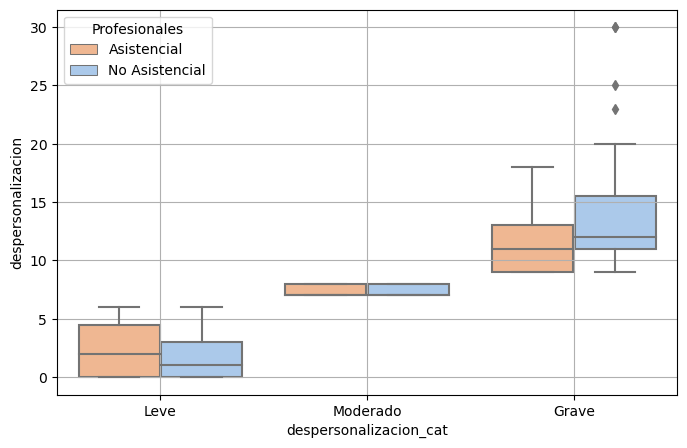

Prevalencia de Síntomas de Burnout - despersonalizacion leve


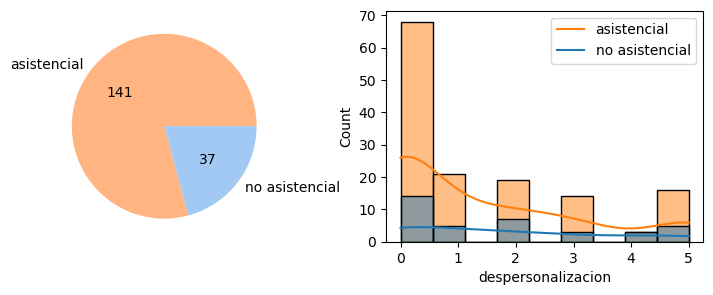

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 2938.5
P-valor asociado: 0.21145004513762555


Estadísticas descriptivas:

Medida d de cohen: 0.22449386904082522


n   Mean     SD Min     Q1 Median     Q3  \
Categoría leve     catprofesi                                                   
despersonalizacion Asistencial      37  1.757  1.817   0  0.000  1.000  3.000   
                   No asistencial  141  1.369  1.705   0  0.000  1.000  2.000   
                   Total           178  1.449  1.730   0  0.000  1.000  2.000   

                                  Max  
Categoría leve     catprofesi          
despersonalizacion Asistencial      5  
                   No asistencial   5  
                   Total            5

Prevalencia de Síntomas de Burnout - despersonalizacion moderado


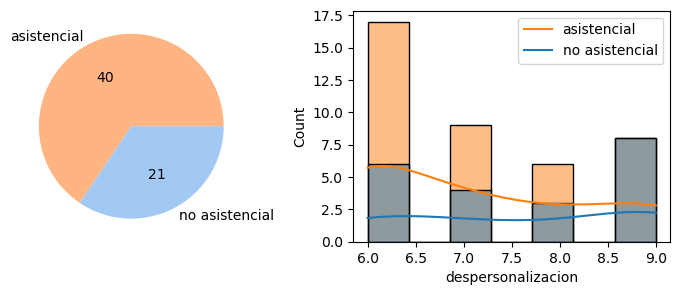

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 512.0
P-valor asociado: 0.1466581989198338


Estadísticas descriptivas:

Medida d de cohen: 0.40608747881747553


n   Mean     SD Min     Q1 Median     Q3  \
Categoría moderado catprofesi                                                  
despersonalizacion Asistencial     21  7.619  1.284   6  6.000  8.000  9.000   
                   No asistencial  40  7.125  1.181   6  6.000  7.000  8.000   
                   Total           61  7.295  1.229   6  6.000  7.000  9.000   

                                  Max  
Categoría moderado catprofesi          
despersonalizacion Asistencial      9  
                   No asistencial   9  
                   Total            9

Prevalencia de Síntomas de Burnout - despersonalizacion grave


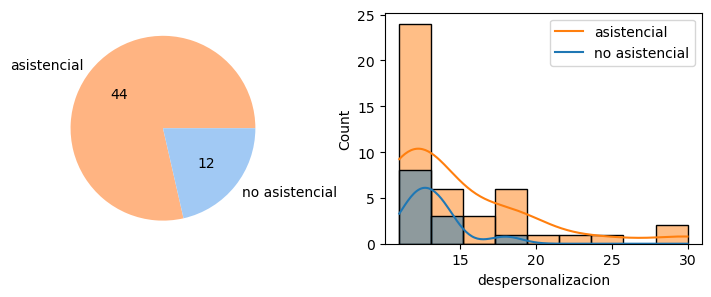

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 248.5
P-valor asociado: 0.7595252823061593


Estadísticas descriptivas:

Medida d de cohen: -0.39450660861907594


n    Mean     SD Min      Q1  Median  \
Categoría grave    catprofesi                                              
despersonalizacion Asistencial     15  12.533  2.066  10  11.500  12.000   
                   No asistencial  46  14.674  4.798  10  12.000  12.000   
                   Total           61  14.148  4.374  10  12.000  12.000   

                                       Q3 Max  
Categoría grave    catprofesi                  
despersonalizacion Asistencial     13.500  18  
                   No asistencial  17.000  30  
                   Total           14.000  30

In [26]:
categoria_SB('despersonalizacion')

# Despersonalizacion Leve
efecto_SB(despersonalizacion_leve, 'despersonalizacion', 'leve')
print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

leve = (df['despersonalizacion'] < 6)
cohen_d(despersonalizacion_leve, 'despersonalizacion')
display(descstatscat('despersonalizacion', 'leve', leve))

# Despersonalizacion Moderada
efecto_SB(despersonalizacion_moderado, 'despersonalizacion', 'moderado')
print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

moderado = (df['despersonalizacion'] <= 9) & (df['despersonalizacion'] >= 6)
cohen_d(despersonalizacion_moderado, 'despersonalizacion')
display(descstatscat('despersonalizacion', 'moderado', moderado))


# Despersonalizacion Grave
efecto_SB(despersonalizacion_grave, 'despersonalizacion', 'grave')
print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

grave = (df['despersonalizacion'] > 9)
cohen_d(despersonalizacion_grave, 'despersonalizacion')
display(descstatscat('despersonalizacion','grave', grave))

## Interpretación de los resultados

**Variable - Despersonalizacion leve**

Se puede observar que dentro de la categoría leve del componente de despersonalización del SB, la prueba de Mann-Whitney no arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: -0.32, lo cual indica que el grupo de **profesionales no asistenciales** tuvo mayor prevalencia de estos sintomas (promedio 1.557) con respecto a los **profesionales asistenciales** (promedio 1), sin embargo, estos efectos fueron pequeños. 

**Variable - Despersonalizacion moderado**

Se puede observar que dentro de la categoría leve del componente de despersonalización del SB, la prueba de Mann-Whitney no arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: 0.06, lo cual indica que la diferencia entre las medias de ambos grupos es despreciable. 

**Variable - Despersonalizacion grave**

Se puede observar que dentro de la categoría leve del componente de despersonalización del SB, la prueba de Mann-Whitney no arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: 0.24, lo cual indica que el grupo de **profesionales asistenciales** tuvo mayor prevalencia de estos sintomas (promedio 15.438) con respecto a los **profesionales no asistenciales** (promedio 13.56), sin embargo, estos efectos fueron pequeños. 

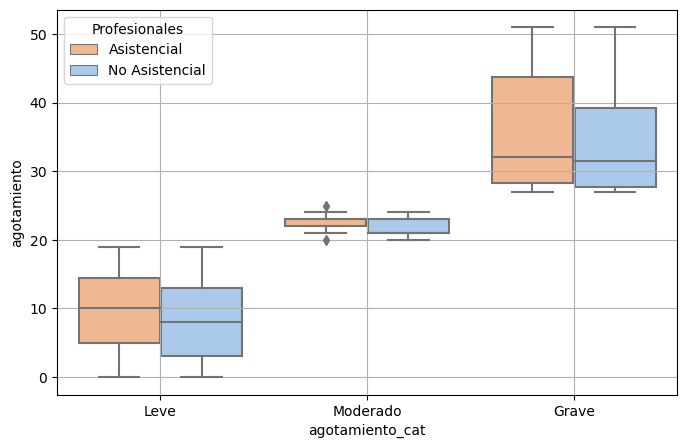

Prevalencia de Síntomas de Burnout - agotamiento leve


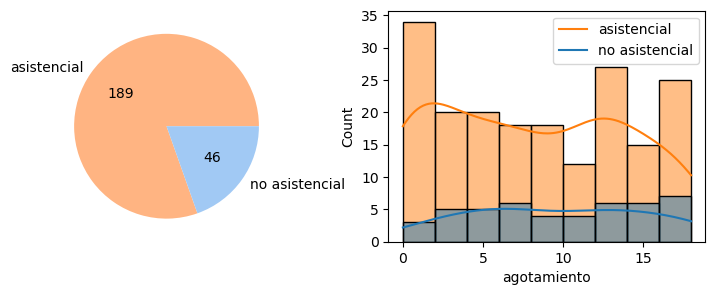

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 5023.0
P-valor asociado: 0.10161962598838863


Estadísticas descriptivas:

Medida d de cohen: 0.2630469638506306


n   Mean     SD Min     Q1  Median      Q3  \
Categoría leve catprofesi                                                     
agotamiento    Asistencial      47  9.787  5.603   0  5.000  10.000  14.500   
               No asistencial  192  8.240  5.948   0  3.000   8.000  13.000   
               Total           239  8.544  5.902   0  3.000   8.000  13.000   

                              Max  
Categoría leve catprofesi          
agotamiento    Asistencial     19  
               No asistencial  19  
               Total           19

Prevalencia de Síntomas de Burnout - agotamiento moderado


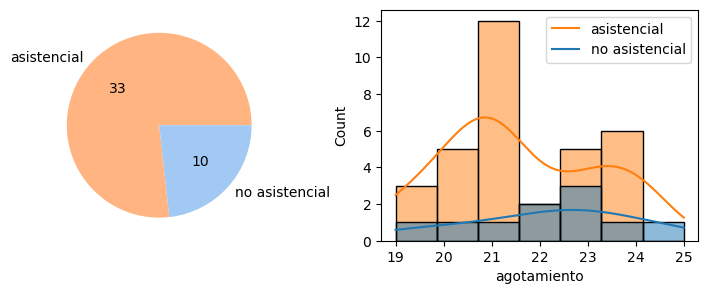

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 199.5
P-valor asociado: 0.31792273284416206


Estadísticas descriptivas:

Medida d de cohen: 0.37826418093204667


n    Mean     SD Min      Q1  Median  \
Categoría moderado catprofesi                                              
agotamiento        Asistencial     10  23.000  2.000  20  22.000  23.000   
                   No asistencial  33  22.303  2.038  20  21.000  21.000   
                   Total           43  22.465  2.028  20  21.000  22.000   

                                       Q3 Max  
Categoría moderado catprofesi                  
agotamiento        Asistencial     23.750  27  
                   No asistencial  24.000  27  
                   Total           24.000  27

Prevalencia de Síntomas de Burnout - agotamiento grave


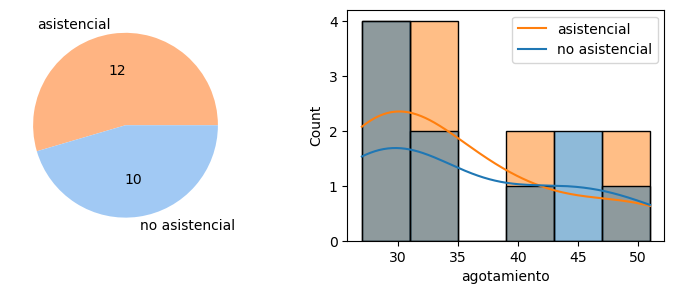

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 66.5
P-valor asociado: 0.6905500347701572


Estadísticas descriptivas:

Medida d de cohen: 0.13164538476325316


n    Mean     SD Min      Q1  Median      Q3  \
Categoría grave catprofesi                                                      
agotamiento     Asistencial      9  36.667  8.718  28  29.000  32.000  45.000   
                No asistencial   9  37.111  8.038  28  31.000  34.000  40.000   
                Total           18  36.889  8.138  28  31.000  33.000  43.750   

                               Max  
Categoría grave catprofesi          
agotamiento     Asistencial     51  
                No asistencial  51  
                Total           51

In [64]:
categoria_SB('agotamiento')

# Agotamiento Leve
efecto_SB(agotamiento_leve, 'agotamiento', 'leve')

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

leve = (df['agotamiento'] < 20)
cohen_d(agotamiento_leve, 'agotamiento')
display(descstatscat('agotamiento', 'leve', leve))


# Agotamiento Moderado
efecto_SB(agotamiento_moderado, 'agotamiento', 'moderado')

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

moderado = (df['agotamiento'] <= 27) & (df['agotamiento'] >= 20)
cohen_d(agotamiento_moderado, 'agotamiento')
display(descstatscat('agotamiento', 'moderado', moderado))

# Agotamiento Grave
efecto_SB(agotamiento_grave, 'agotamiento', 'grave')

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

grave = (df['agotamiento'] > 27)
cohen_d(agotamiento_grave, 'agotamiento')
display(descstatscat('agotamiento','grave', grave))

## Interpretación de los resultados

**Variable - Agotamiento leve**

Se puede observar que dentro de la categoría leve del componente de agotamiento del SB, la prueba de Mann-Whitney no arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: -0.54, lo cual indica **diferencia moderada**, pero significativa entre estos grupos. Los **profesionales no asistenciales** tuvieron una mayor prevalencia de estos sintomas (promedio 9.061) con respecto a los **profesionales asistenciales** (promedio 6.268). 

**Variable - Agotamiento moderado**

Se puede observar que dentro de la categoría moderada del componente de agotamiento del SB, la prueba de Mann-Whitney no arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: 0.15, lo cual indica que el grupo de **profesionales asistenciales** tuvo mayor prevalencia de estos sintomas (promedio 22.750) con respecto a los **profesionales no asistenciales** (promedio 22.405), sin embargo, estos efectos fueron pequeños.

**Variable - Agotamiento grave**

Se puede observar que dentro de la categoría grave del componente de agotamiento del SB, la prueba de Mann-Whitney no arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: 0.80, lo cual indica una diferencia substancial entre las medias, sin embargo, observando la cantidad de datos de esta categoría se puede observar que hay muy pocos datos como para que estos resultados toman mucha significancia.

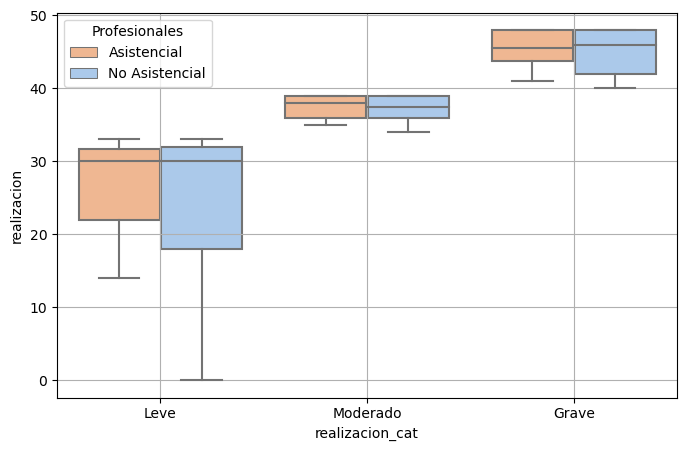

Prevalencia de Síntomas de Burnout - realizacion leve


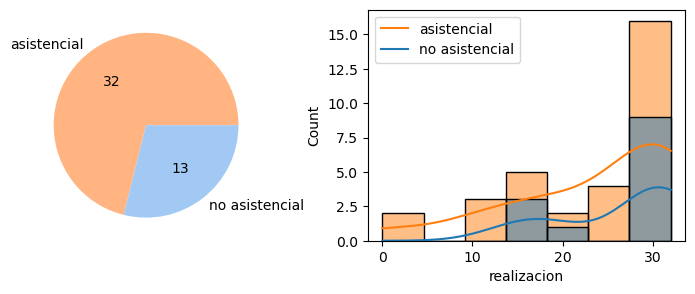

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 238.5
P-valor asociado: 0.4455532508735167


Estadísticas descriptivas:

Medida d de cohen: 0.32664335352529006


n    Mean     SD Min      Q1  Median      Q3  \
Categoría leve catprofesi                                                      
realizacion    Asistencial     13  26.462  6.778  14  20.000  30.000  31.000   
               No asistencial  32  23.562  9.565   0  18.000  28.500  30.500   
               Total           45  24.400  8.874   0  18.000  30.000  31.000   

                              Max  
Categoría leve catprofesi          
realizacion    Asistencial     32  
               No asistencial  32  
               Total           32

Prevalencia de Síntomas de Burnout - realizacion moderado


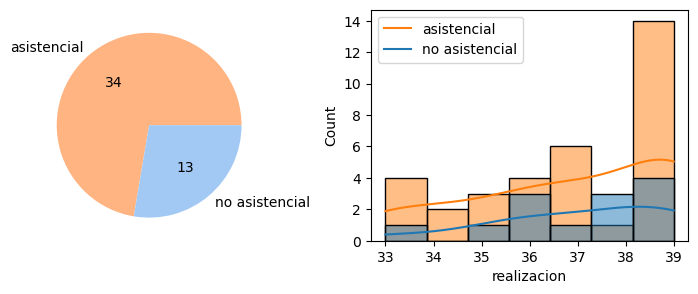

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 225.0
P-valor asociado: 0.9314045909540914


Estadísticas descriptivas:

Medida d de cohen: 0.115868799691049


n    Mean     SD Min      Q1  Median  \
Categoría moderado catprofesi                                              
realizacion        Asistencial     13  37.154  1.864  33  36.000  38.000   
                   No asistencial  42  37.500  2.298  33  36.000  39.000   
                   Total           55  37.418  2.192  33  36.000  38.000   

                                       Q3 Max  
Categoría moderado catprofesi                  
realizacion        Asistencial     39.000  39  
                   No asistencial  39.000  40  
                   Total           39.000  40

Prevalencia de Síntomas de Burnout - realizacion grave


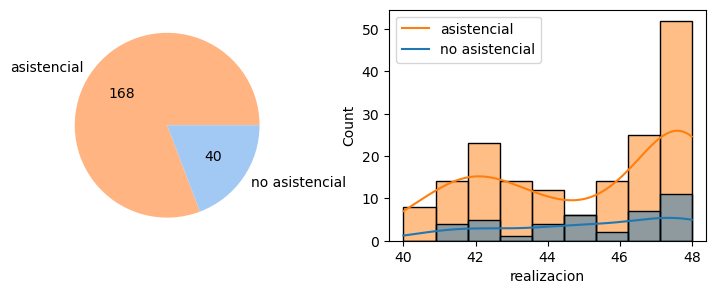

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 3438.0
P-valor asociado: 0.8175253551538604


Estadísticas descriptivas:

Medida d de cohen: 0.07751961411861095


n    Mean     SD Min      Q1  Median  \
Categoría grave catprofesi                                               
realizacion     Asistencial      40  45.300  2.493  41  43.750  45.500   
                No asistencial  160  45.344  2.585  41  43.000  46.000   
                Total           200  45.335  2.560  41  43.000  46.000   

                                    Q3 Max  
Categoría grave catprofesi                  
realizacion     Asistencial     48.000  48  
                No asistencial  48.000  48  
                Total           48.000  48

In [65]:
categoria_SB('realizacion')

# Realizacion Leve
efecto_SB(realizacion_leve, 'realizacion', 'leve')

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

leve = (df['realizacion'] < 33)
cohen_d(realizacion_leve, 'realizacion')
display(descstatscat('realizacion', 'leve', leve))

# Realizacion Moderada
efecto_SB(realizacion_moderado, 'realizacion', 'moderado')

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

moderado = (df['realizacion'] <= 40) & (df['realizacion'] >= 33)
cohen_d(realizacion_moderado, 'realizacion')
display(descstatscat('realizacion', 'moderado', moderado))

# Realizacion Grave
efecto_SB(realizacion_grave, 'realizacion', 'grave')

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

grave = (df['realizacion'] > 40)
cohen_d(realizacion_grave, 'realizacion')
display(descstatscat('realizacion','grave', grave))

## Interpretación de los resultados

**Variable - Realizacion leve**

Se puede observar que dentro de la categoría leve del componente de realizacion del SB, la prueba de Mann-Whitney no arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: 0.21, lo cual indica que el grupo de **profesionales asistenciales** tuvo mayor prevalencia de estos sintomas (promedio 26.143) con respecto a los **profesionales no asistenciales** (promedio 24.568), sin embargo, estos efectos fueron pequeños.

**Variable - Realizacion moderado**

Se puede observar que dentro de la categoría moderada del componente de realizacion del SB, la prueba de Mann-Whitney no arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: 0.09, lo cual indica que la diferencia entre las medias de ambos grupos es despreciable. 

**Variable - Realizacion grave**

Se puede observar que dentro de la categoría grave del componente de realizacion del SB, la prueba de Mann-Whitney arrojó diferencias significativas entre los grupos y la medida d de cohen obtenida fue de: -0.44, lo cual indica una **diferencia moderada**, pero significativa entre estos grupos. Los **profesionales no asistenciales** tuvieron una mayor prevalencia de estos sintomas (promedio 45.575) con respecto a los **profesionales asistenciales** (promedio 44.396), siendo una diferencia de 0.35 desviaciones estandar poblacionales.


# Control Inhibitorio

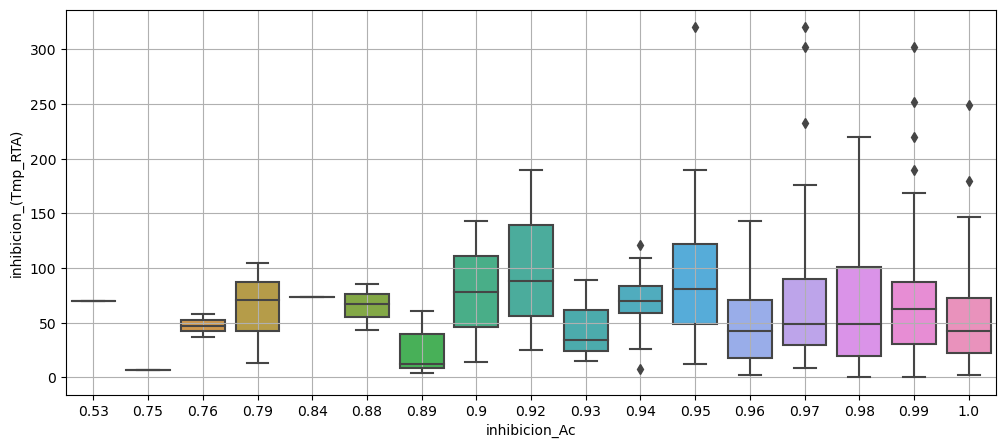

In [66]:
plt.figure(figsize=(12,5))
sns.boxplot(x="inhibicion_Ac", y="inhibicion_(Tmp_RTA)", data=df)
plt.grid(True)
plt.show()

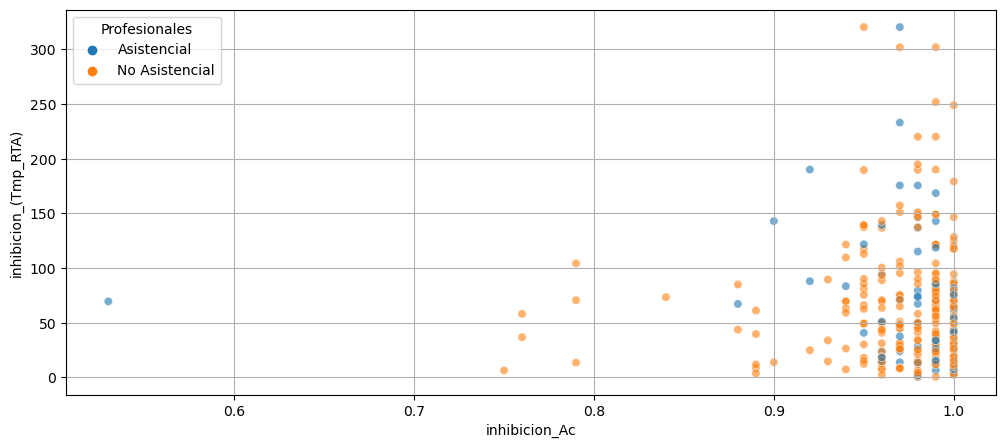

In [67]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=df,x="inhibicion_Ac", y="inhibicion_(Tmp_RTA)", hue="catprofesi",alpha=.6)

legend=plt.legend(title= 'Profesionales', loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')
plt.grid(True)
plt.show()
del legend

Variable inhibicion_Ac


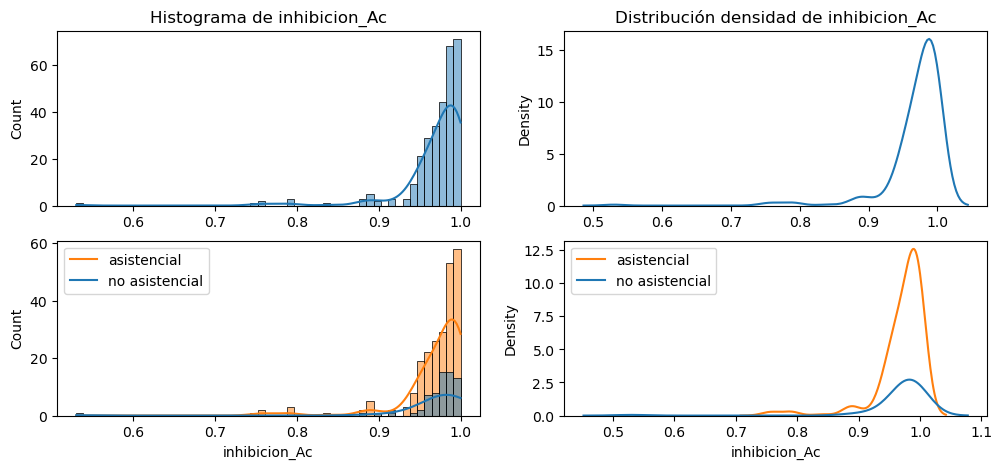

Resultados test shapiro - inhibicion_Ac
                    stat  test_shapiro
Total           0.562011  8.960575e-27
Asistencial     0.385788  3.940398e-15
No asistencial  0.643398  7.559733e-22

Resultado Mann-Whitney test: 7731.5
P-valor asociado: 0.9882811721663567

Medida d de cohen: -0.011087160273265624
Variable inhibicion_(Tmp_RTA)


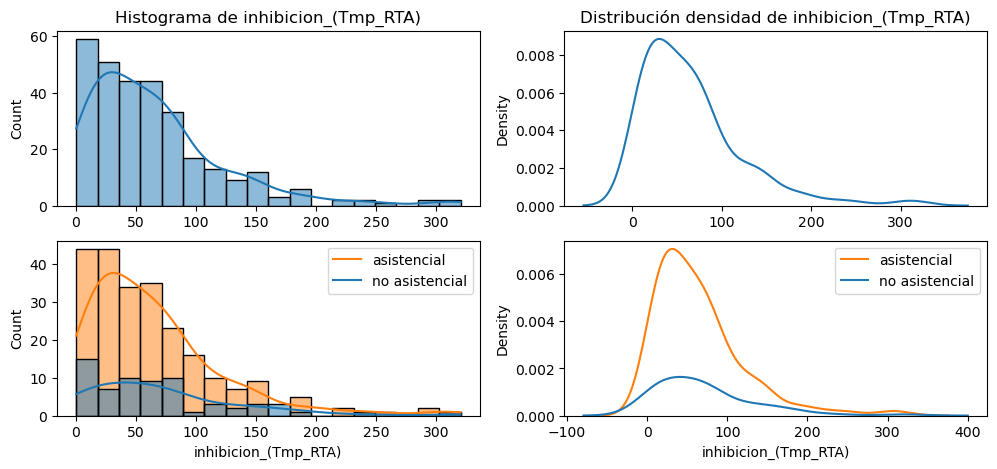

Resultados test shapiro - inhibicion_(Tmp_RTA)
                    stat  test_shapiro
Total           0.846879  1.413655e-16
Asistencial     0.862391  2.986716e-06
No asistencial  0.842195  1.056977e-14

Resultado Mann-Whitney test: 7992.5
P-valor asociado: 0.6644252056097749

Medida d de cohen: 0.09100239994404172


In [68]:
distribucion('inhibicion_Ac')
distribucion('inhibicion_(Tmp_RTA)')

## Interpretación de los resultados

**Resultados de la variable 'inhibicion_Ac'**

- Los resultados del test de Shapiro Wilks arrojaron que ninguna de las muestras sigue una distribución normal.

- Los resultados de la prueba U de Mann Whitney esta vez encontraron diferencias en la magnitud de las medias.

- Sin embargo, la medida d de cohen tuvo una magnitud de -0.039, lo cual indica un efecto despreciable entre las medias de los grupos asistenciales y no asistenciales. Más adelante se realizara un análisis por las categorías de inhibicion_Ac para determinar si dentro de estas categorías se encuentra el efecto arrojado por la prueba U de Mann Whitney. 

**Resultados de la variable 'inhibicion_(Tmp_RTA)'**

- Los resultados del test de Shapiro Wilks se observa nuevamente que ninguna de las muestras sigue una distribución normal.

- Los resultados de la prueba U de Mann Whitney arrojan que no existen diferencias significativas entre los dos grupos.

- Y la medida d de cohen tuvo una magnitud de -0.29, lo cual indica un efecto pequeño entre las medias, lo que indica que el grupo de **profesionales no asistenciales** presenta mayor tiempo de respuesta en comparación a los **profesionales asistenciales**.

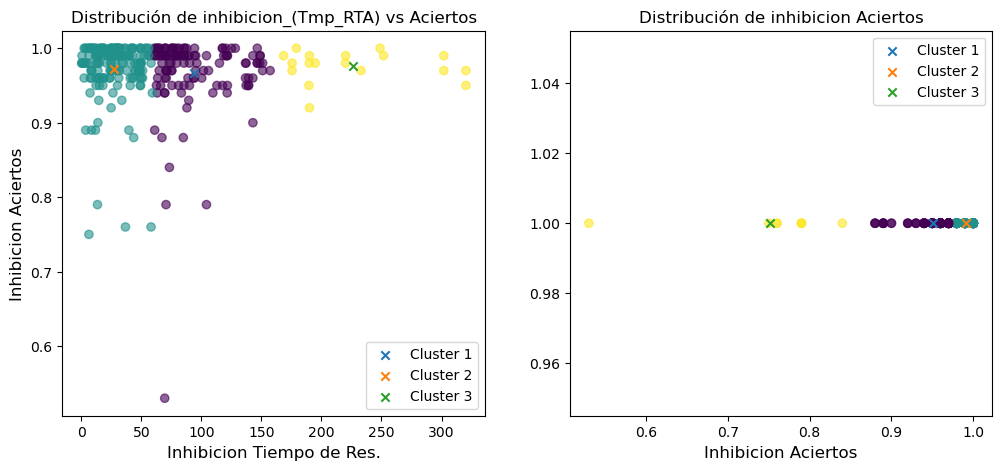

In [70]:
x=df['inhibicion_(Tmp_RTA)']
y=df['inhibicion_Ac']
points = list(zip(x, y))

y_2 = pd.Series(1, index=range(300))
x_2 = df['inhibicion_Ac']
points_2 = list(zip(x_2, y_2))

kmeans = KMeans(n_clusters=3)
kmeans.fit(points)
cluster_centers = kmeans.cluster_centers_

kmeans2 = KMeans(n_clusters=3)
kmeans2.fit(points_2)
cluster_centers2 = kmeans2.cluster_centers_

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Distribución de inhibicion_(Tmp_RTA) vs Aciertos', size=12)
axs[0].scatter(x, y, c=kmeans.labels_, alpha=0.6, cmap='viridis')
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200)
axs[0].scatter(cluster_centers[0,0], cluster_centers[0,1], marker='x', label= 'Cluster 1')
axs[0].scatter(cluster_centers[1,0], cluster_centers[1,1], marker='x', label = 'Cluster 2')
axs[0].scatter(cluster_centers[2,0], cluster_centers[2,1], marker='x', label = 'Cluster 3')
axs[0].set_xlabel('Inhibicion Tiempo de Res.', size=12)
axs[0].set_ylabel('Inhibicion Aciertos', size=12)
axs[0].legend()

axs[1].set_title('Distribución de inhibicion Aciertos', size=12)
axs[1].scatter(x_2, y_2, c=kmeans2.labels_, alpha=0.6, cmap='viridis')
axs[1].scatter(cluster_centers2[0,0], cluster_centers2[0,1], marker='x', label= 'Cluster 1')
axs[1].scatter(cluster_centers2[1,0], cluster_centers2[1,1], marker='x', label = 'Cluster 2')
axs[1].scatter(cluster_centers2[2,0], cluster_centers2[2,1], marker='x', label = 'Cluster 3')
axs[1].set_xlabel('Inhibicion Aciertos', size=12)
axs[1].legend()

plt.show()
del points, points_2, cluster_centers, cluster_centers2

In [80]:
print(start + 'Categorías - tiempo de respuesta' + end)
kmeans_data = pd.DataFrame({'x': x, 'y': y})
kmeans_data['cluster'] = kmeans.predict(kmeans_data[['x', 'y']])

display(kmeans_data.sample(5))
Bajo = (kmeans_data['cluster'] == 1)
Medio= (kmeans_data['cluster'] == 0)
print('Categoría BAJO', max(kmeans_data[Bajo]['x']))
print('Categoría MEDIO', max(kmeans_data[Medio]['x']))

print('\n')

print(start + 'Categorías - tiempo de respuesta' + end)
kmeans_data2 = pd.DataFrame({'x': x_2, 'y': y_2})
kmeans_data2['cluster'] = kmeans2.predict(kmeans_data2[['x', 'y']])

display(kmeans_data2.sample(5))
Bajo = (kmeans_data2['cluster'] == 2)
Medio= (kmeans_data2['cluster'] == 0)
print('Categoría BAJO', max(kmeans_data2[Bajo]['x']))
print('Categoría MEDIO', max(kmeans_data2[Medio]['x']))

#del x, y, kmeans, kmeans_data, x_2, y_2, kmeans_2, kmeans_data_2  

Categorías - tiempo de respuesta


x  y  cluster
222  1.00  1        2
127  0.97  1        0
29   0.98  1        2
179  0.98  1        2
191  0.95  1        0

Categoría BAJO 0.84
Categoría MEDIO 0.97


Categorías - tiempo de respuesta


x  y  cluster
270  0.98  1        1
216  0.89  1        0
14   0.95  1        0
130  0.97  1        0
121  0.98  1        1

Categoría BAJO 0.84
Categoría MEDIO 0.97


In [81]:
# Categorías Tiempo de RTA
cut_points = [-float('inf'), 60.38, 157.3, float('inf')]
labels = ['bajo', 'medio', 'alto']

df['inhibicion_(Tmp_RTA)_cat'] = pd.cut(df['inhibicion_(Tmp_RTA)'], bins=cut_points, labels=labels, right=False)

# Categorías Aciertos
cut_points = [-float('inf'), 0.85, 0.971, float('inf')]
df['inhibicion_Ac_cat'] = pd.cut(df['inhibicion_Ac'], bins=cut_points, labels=labels, right=False)

Distribución - Categorías inhibicion_(Tmp_RTA)


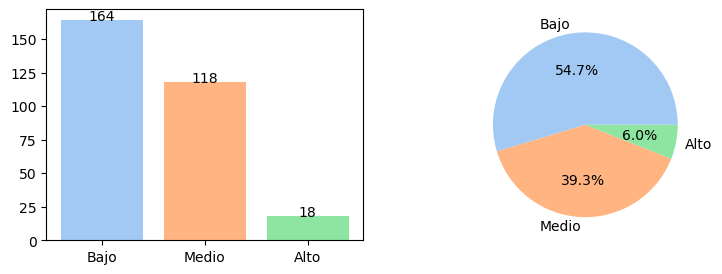

Distribución - Categorías inhibicion_Ac


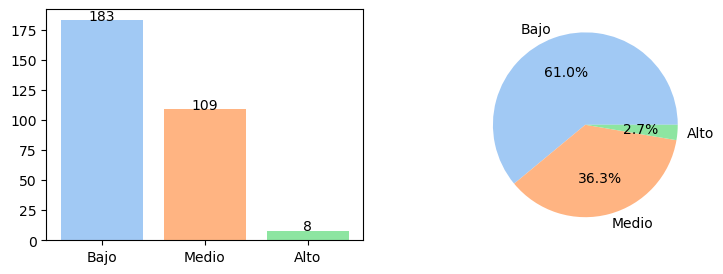

In [82]:
print(start + 'Distribución - Categorías inhibicion_(Tmp_RTA)' + end)
labels = ['Bajo', 'Medio', 'Alto']
distribucion2('inhibicion_(Tmp_RTA)_cat', labels)

print(start + 'Distribución - Categorías inhibicion_Ac' + end)
labels = ['Bajo', 'Medio', 'Alto']
distribucion2('inhibicion_Ac_cat', labels)

## Interpretación de los datos

In [87]:
Bajo_Ac = (df['inhibicion_Ac'] <= 0.85)
temp_data = df[~Bajo_Ac]
temp_data

catprofesi  despersonalizacion  agotamiento  realizacion  Lid_total  \
0             1                   0            3           42         37   
1             0                  11           12           30         36   
2             1                   0           12           46         40   
3             1                   2           23           48         37   
4             1                   3            7           41         37   
..          ...                 ...          ...          ...        ...   
295           0                   7            8           47         37   
296           1                  10            0           48         35   
297           1                   0           10           39         39   
298           1                   3            0           41         45   
299           1                  30           18           47         16   

     CT_total  DEMA_riesgo  DEMA_carga  Dem_sitio  Dem_emo  Reco_total  \
0          21           12          22         18        9          27   
1          28           17          19         18       12          30   
2          27           12          17         20       14          30   
3          18           12          23         17        8          17   
4          30           11          23         17        7          30   
..        ...          ...         ...        ...      ...         ...   
295        28           12          23         20       11          21   
296        29            7          20         15       10          28   
297        28           13          17         18       16          27   
298        25           12          17         20        6          27   
299        29           12          15         18       12          29   

     EXT_casa  EXT_zona  inhibicion_Ac  inhibicion_(Tmp_RTA) realizacion_cat  \
0          20        23           0.99                 18.59           Grave   
1          18        17           1.00                 60.37            Leve   
2          20        19           0.99                 81.85           Grave   
3          14        21           0.99                104.22           Grave   
4          15        16           1.00                  8.25           Grave   
..        ...       ...            ...                   ...             ...   
295        19        18           1.00                 75.46           Grave   
296        14        21           0.99                 23.82           Grave   
297        14        23           1.00                 15.21        Moderado   
298        11        19           0.97                 47.79           Grave   
299        15        19           1.00                 36.05           Grave   

    agotamiento_cat despersonalizacion_cat inhibicion_(Tmp_RTA)_cat  \
0              Leve                   Leve                     bajo   
1              Leve                  Grave                     bajo   
2              Leve                   Leve                    medio   
3          Moderado                   Leve                    medio   
4              Leve                   Leve                     bajo   
..              ...                    ...                      ...   
295            Leve               Moderado                    medio   
296            Leve                  Grave                     bajo   
297            Leve                   Leve                     bajo   
298            Leve                   Leve                     bajo   
299            Leve                  Grave                     bajo   

    inhibicion_Ac_cat  
0                alto  
1                alto  
2                alto  
3                alto  
4                alto  
..                ...  
295              alto  
296              alto  
297              alto  
298             medio  
299              alto  

[292 rows x 20 columns]

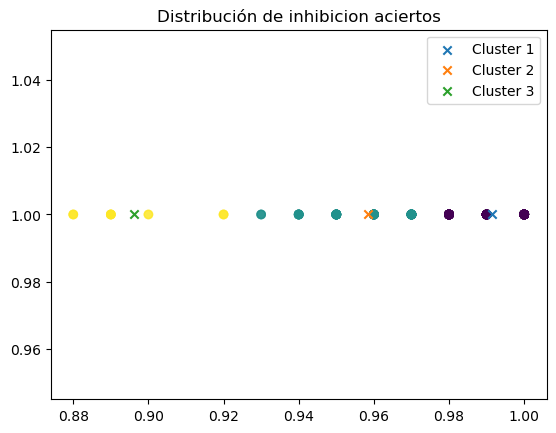

In [89]:
Bajo_Ac = (df['inhibicion_Ac'] <= 0.85)
temp_data = df[~Bajo_Ac]

y = pd.Series(1, index=range(292))
x = temp_data['inhibicion_Ac']
points = list(zip(x, y))

kmeans = KMeans(n_clusters=3)
kmeans.fit(points)
cluster_centers = kmeans.cluster_centers_

plt.title('Distribución de inhibicion aciertos', size=12)
plt.scatter(x, y, c=kmeans.labels_, alpha=0.6, cmap='viridis')
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200)
plt.scatter(cluster_centers[0,0], cluster_centers[0,1], marker='x', label= 'Cluster 1')
plt.scatter(cluster_centers[1,0], cluster_centers[1,1], marker='x', label = 'Cluster 2')
plt.scatter(cluster_centers[2,0], cluster_centers[2,1], marker='x', label = 'Cluster 3')
plt.legend()
plt.show()

del temp_data

In [92]:
x = x.reset_index(drop=True)
kmeans_data = pd.DataFrame({'x': x, 'y': y}, index=range(292))
kmeans_data['cluster'] = kmeans.predict(kmeans_data[['x', 'y']])

print(start + 'Categorías - tiempo de respuesta' + end)
display(kmeans_data.sample(5))
Bajo = (kmeans_data['cluster'] == 2)
Medio= (kmeans_data['cluster'] == 1)
print('Categoría BAJO', max(kmeans_data[Bajo]['x']))
print('Categoría MEDIO', max(kmeans_data[Medio]['x']))

Categorías - tiempo de respuesta


x  y  cluster
51   0.99  1        0
233  1.00  1        0
142  0.98  1        0
175  0.88  1        2
86   0.96  1        1

Categoría BAJO 0.92
Categoría MEDIO 0.97


In [93]:
# Categorías Aciertos
cut_points = [-float('inf'), 0.921, 0.971, float('inf')]
df['inhibicion_Ac_cat'] = pd.cut(df['inhibicion_Ac'], bins=cut_points, labels=labels, right=False)

Distribución - Categorías inhibicion_(Tmp_RTA)


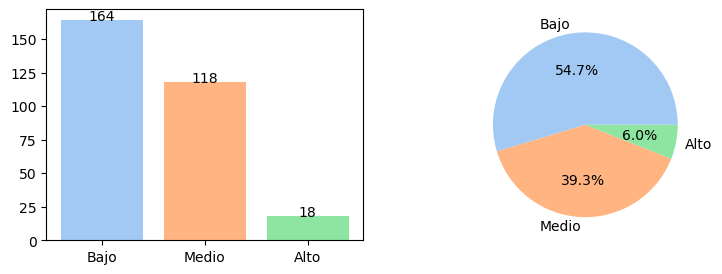

Distribución - Categorías inhibicion_Ac


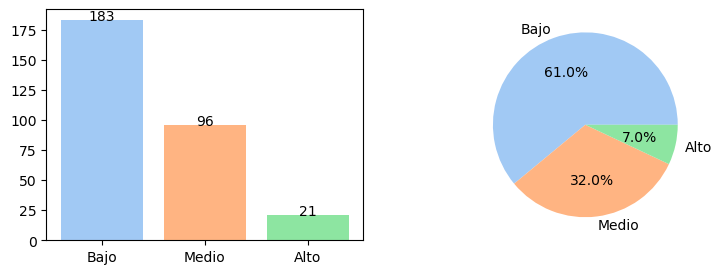

In [94]:
print(start + 'Distribución - Categorías inhibicion_(Tmp_RTA)' + end)
labels = ['Bajo', 'Medio', 'Alto']
distribucion2('inhibicion_(Tmp_RTA)_cat', labels)

print(start + 'Distribución - Categorías inhibicion_Ac' + end)
labels = ['Bajo', 'Medio', 'Alto']
distribucion2('inhibicion_Ac_cat', labels)

#del x, y, kmeans, kmeans_data, Bajo, x_2, y_2, kmeans2, kmeans_data2  

## Interpretación de los datos

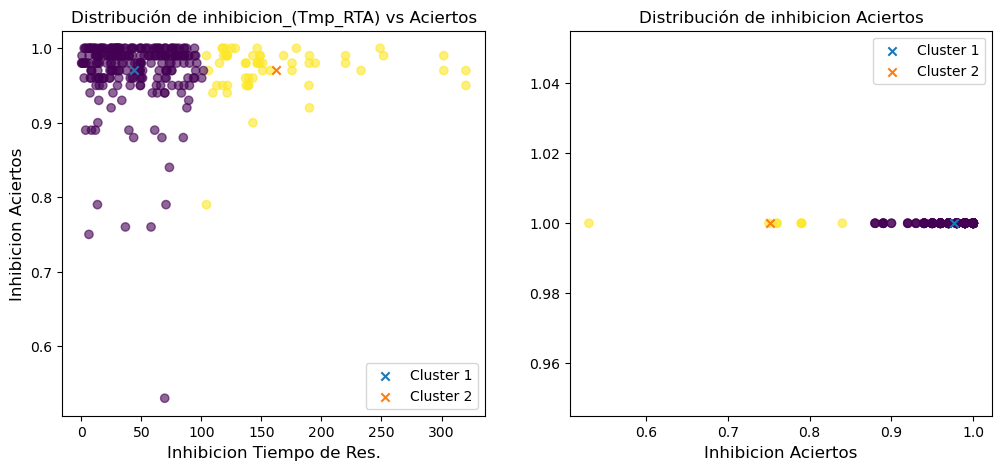

In [95]:
x=df['inhibicion_(Tmp_RTA)']
y=df['inhibicion_Ac']
points = list(zip(x, y))

y_2 = pd.Series(1, index=range(300))
x_2 = df['inhibicion_Ac']
points_2 = list(zip(x_2, y_2))

kmeans = KMeans(n_clusters=2)
kmeans.fit(points)
cluster_centers = kmeans.cluster_centers_

kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(points_2)
cluster_centers2 = kmeans2.cluster_centers_

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Distribución de inhibicion_(Tmp_RTA) vs Aciertos', size=12)
axs[0].scatter(x, y, c=kmeans.labels_, alpha=0.6, cmap='viridis')
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200)
axs[0].scatter(cluster_centers[0,0], cluster_centers[0,1], marker='x', label= 'Cluster 1')
axs[0].scatter(cluster_centers[1,0], cluster_centers[1,1], marker='x', label = 'Cluster 2')
axs[0].set_xlabel('Inhibicion Tiempo de Res.', size=12)
axs[0].set_ylabel('Inhibicion Aciertos', size=12)
axs[0].legend()

axs[1].set_title('Distribución de inhibicion Aciertos', size=12)
axs[1].scatter(x_2, y_2, c=kmeans2.labels_, alpha=0.6, cmap='viridis')
axs[1].scatter(cluster_centers2[0,0], cluster_centers2[0,1], marker='x', label= 'Cluster 1')
axs[1].scatter(cluster_centers2[1,0], cluster_centers2[1,1], marker='x', label = 'Cluster 2')
axs[1].set_xlabel('Inhibicion Aciertos', size=12)
axs[1].legend()

plt.show()

In [96]:
print(start + 'Categorías - tiempo de respuesta' + end)
kmeans_data = pd.DataFrame({'x': x, 'y': y})
kmeans_data['cluster'] = kmeans.predict(kmeans_data[['x', 'y']])

display(kmeans_data.sample(5))
Bajo = (kmeans_data['cluster'] == 0)
Alto= (kmeans_data['cluster'] == 1)
print('Categoría BAJO', max(kmeans_data[Bajo]['x']))
print('Categoría ALTO', max(kmeans_data[Alto]['x']))

print('\n')

print(start + 'Categorías - número de aciertos' + end)
kmeans_data2 = pd.DataFrame({'x': x_2, 'y': y_2})
kmeans_data2['cluster'] = kmeans2.predict(kmeans_data2[['x', 'y']])

display(kmeans_data2.sample(5))
Bajo = (kmeans_data2['cluster'] == 1)
Alto= (kmeans_data2['cluster'] == 0)
print('Categoría BAJO', max(kmeans_data2[Bajo]['x']))
print('Categoría ALTO', max(kmeans_data2[Alto]['x']))

del x, y, kmeans, kmeans_data, x_2, y_2, kmeans2, kmeans_data2  

Categorías - tiempo de respuesta


x     y  cluster
49    84.93  0.88        0
3    104.22  0.99        1
241  168.46  0.99        1
254   64.84  0.97        0
114   13.51  0.99        0

Categoría BAJO 101.68
Categoría ALTO 320.32


Categorías - número de aciertos


x  y  cluster
128  0.97  1        0
50   1.00  1        0
29   0.98  1        0
285  0.98  1        0
190  1.00  1        0

Categoría BAJO 0.84
Categoría ALTO 1.0


In [97]:
# Categorías Tiempo de RTA
cut_points = [-float('inf'), 101.69, float('inf')] # Valor Max Cluster 1
labels = ['bajo', 'alto']

df['inhibicion_(Tmp_RTA)_cat3'] = pd.cut(df['inhibicion_(Tmp_RTA)'], bins=cut_points, labels=labels, right=False)

# Categorías Aciertos
cut_points = [-float('inf'), 0.85, float('inf')] # Valor Max del Cluster 1 
df['inhibicion_Ac_cat3'] = pd.cut(df['inhibicion_Ac'], bins=cut_points, labels=labels, right=False)

Distribución - Categorías inhibicion_(Tmp_RTA)


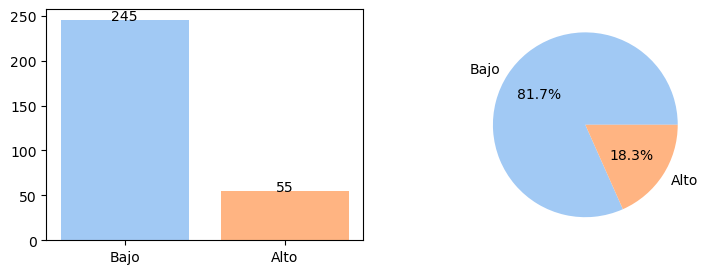

Distribución - Categorías inhibicion_Ac


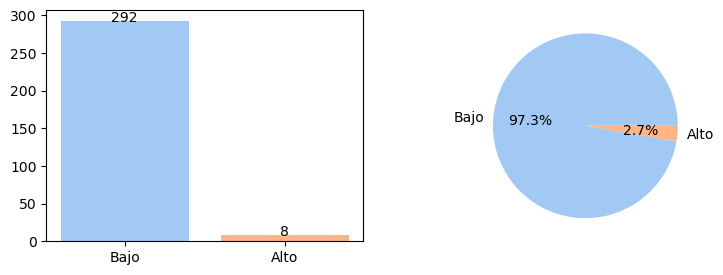

In [98]:
print(start + 'Distribución - Categorías inhibicion_(Tmp_RTA)' + end)
labels = ['Bajo', 'Alto']
distribucion2('inhibicion_(Tmp_RTA)_cat3', labels)

print(start + 'Distribución - Categorías inhibicion_Ac' + end)
labels = ['Bajo', 'Alto']
distribucion2('inhibicion_Ac_cat3', labels)

## Interpretación de los resultados

In [99]:
# Categorías Tiempo de RTA
cut_points = [-float('inf'), 67, float('inf')] # Promedio de los datos
labels = ['bajo', 'alto']

df['inhibicion_(Tmp_RTA)_cat2'] = pd.cut(df['inhibicion_(Tmp_RTA)'], bins=cut_points, labels=labels, right=False)

# Categorías Aciertos
cut_points = [-float('inf'), 0.97, float('inf')] # Promedio de los datos
df['inhibicion_Ac_cat2'] = pd.cut(df['inhibicion_Ac'], bins=cut_points, labels=labels, right=False)

Distribución - Categorías inhibicion_(Tmp_RTA)


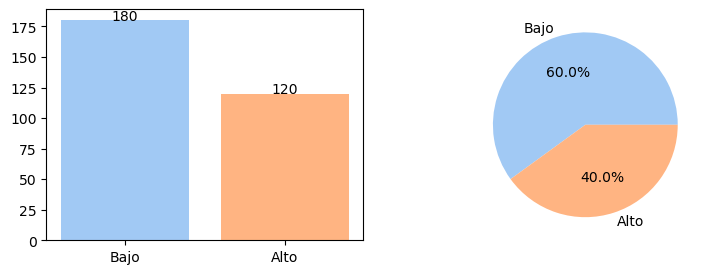

Distribución - Categorías inhibicion_Ac


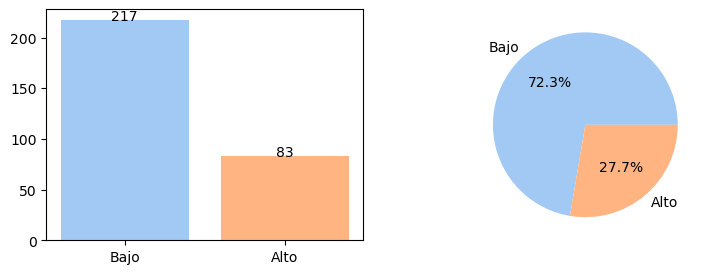

In [100]:
print(start + 'Distribución - Categorías inhibicion_(Tmp_RTA)' + end)
labels = ['Bajo', 'Alto']
distribucion2('inhibicion_(Tmp_RTA)_cat2', labels)

print(start + 'Distribución - Categorías inhibicion_Ac' + end)
labels = ['Bajo', 'Alto']
distribucion2('inhibicion_Ac_cat2', labels)

## Interpretación de los resultados

## Categorías - Tiempo de Respuesta

Categorías, utilizando 3 clusters:
| Control Inhibitorio  | Leve | Moderado | Grave |
|----------------------|------|----------|-------|
| Inhibicion (Tmp_RTA) | <60  | 60-151   | >151  |
| Inhibicion Aciertos  | <0.9 | 0.9-0.97 | >0.97 |

Categorías, utilizando 2 clusters:
| Control Inhibitorio  | Bajo   | Alto    |
|----------------------|--------|---------|
| inhibicion (Tmp_RTA) | <66.13 | $\geq$66.13 |
| inhibicion Aciertos  | <0.969 | $\geq$0.969 |

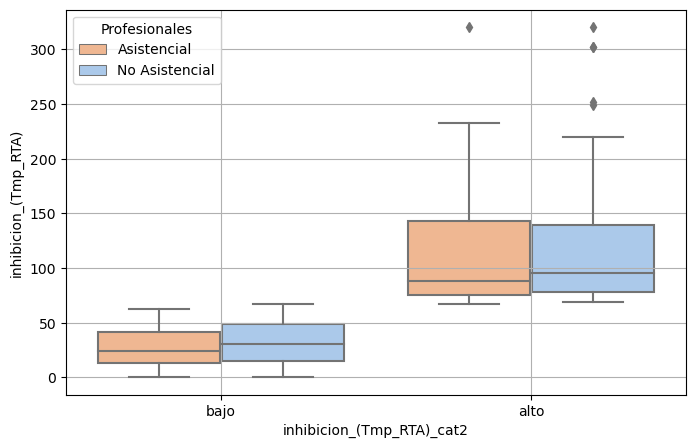



Estadísticas descriptivas:

Medida d de cohen: -0.22769103422264123


n    Mean      SD Min      Q1  Median  \
Categoría bajo       catprofesi                                                
inhibicion_(Tmp_RTA) Asistencial      35  27.331  18.242   0  12.940  23.820   
                     No asistencial  145  31.590  18.810   1  14.990  30.120   
                     Total           180  30.762  18.727   0  14.355  29.080   

                                         Q3 Max  
Categoría bajo       catprofesi                  
inhibicion_(Tmp_RTA) Asistencial     41.740  63  
                     No asistencial  48.930  67  
                     Total           47.790  67

Medida d de cohen: -0.009451764138619815


n     Mean      SD Min      Q1  Median  \
Categoría alto       catprofesi                                                 
inhibicion_(Tmp_RTA) Asistencial      31  117.433  57.897  67  75.040  87.910   
                     No asistencial   89  117.962  55.331  69  78.060  95.280   
                     Total           120  117.826  55.759  67  77.987  94.785   

                                          Q3  Max  
Categoría alto       catprofesi                    
inhibicion_(Tmp_RTA) Asistencial     142.890  320  
                     No asistencial  139.230  320  
                     Total           140.145  320

In [101]:
plt.figure(figsize=(8,5))
colors = {0: '#ffb482', 1: '#a1c9f4'}
sns.boxplot(x = 'inhibicion_(Tmp_RTA)_cat2', y = 'inhibicion_(Tmp_RTA)', data = df, hue= 'catprofesi', palette=colors)

legend=plt.legend(title='Profesionales', loc='upper left')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')
plt.grid(True)
plt.show()
del colors

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

bajo = (df['inhibicion_(Tmp_RTA)'] < 67)
cohen_d(df[bajo], 'inhibicion_(Tmp_RTA)')
display(descstatscat('inhibicion_(Tmp_RTA)', 'bajo', bajo))


alto = (df['inhibicion_(Tmp_RTA)'] >= 67)
cohen_d(df[alto], 'inhibicion_(Tmp_RTA)')
display(descstatscat('inhibicion_(Tmp_RTA)','alto', alto))

## Interpretación de los resultados

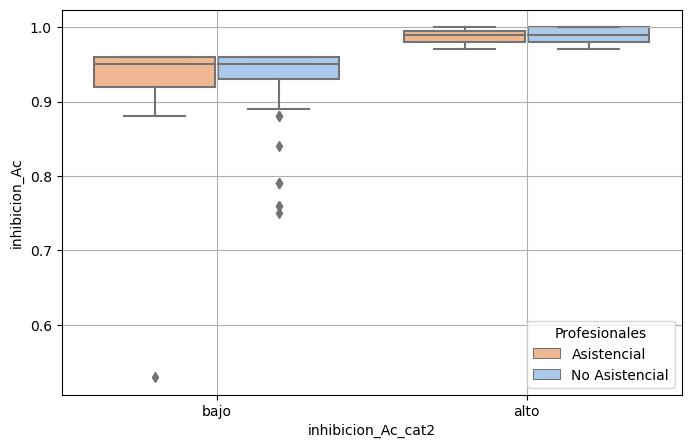



Estadísticas descriptivas:

Medida d de cohen: -0.18349679311560588


n   Mean     SD Min     Q1 Median     Q3 Max
Categoría bajo catprofesi                                                   
inhibicion_Ac  Asistencial     15  0.914  0.109   1  0.920  0.950  0.960   1
               No asistencial  68  0.926  0.054   1  0.930  0.950  0.960   1
               Total           83  0.924  0.067   1  0.925  0.950  0.960   1

Medida d de cohen: -0.2022994567866463


n   Mean     SD Min     Q1 Median     Q3 Max
Categoría alto catprofesi                                                    
inhibicion_Ac  Asistencial      51  0.986  0.010   1  0.980  0.990  0.995   1
               No asistencial  166  0.989  0.011   1  0.980  0.990  1.000   1
               Total           217  0.988  0.011   1  0.980  0.990  1.000   1

In [102]:
plt.figure(figsize=(8,5))
colors = {0: '#ffb482', 1: '#a1c9f4'}
sns.boxplot(x = 'inhibicion_Ac_cat2', y = 'inhibicion_Ac', data = df, hue= 'catprofesi', palette=colors)

legend=plt.legend(title='Profesionales', loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')
plt.grid(True)
plt.show()
del colors

print('\n\n' + start + "Estadísticas descriptivas:" + end + '\n')

bajo = (df['inhibicion_Ac'] < 0.969)
cohen_d(df[bajo], 'inhibicion_Ac')
display(descstatscat('inhibicion_Ac', 'bajo', bajo))

alto = (df['inhibicion_Ac'] >= 0.969)
cohen_d(df[alto], 'inhibicion_Ac')
display(descstatscat('inhibicion_Ac','alto', alto))
del bajo, alto

## Interpretación de los resultados

# Hipótesis 
### 2. Establecer el impacto de los sintomas de Burnout en el control inhibitorio <a id='Hipotesis_2'></a> 

Para determinar si el impacto de los sintomas de Burnout difieren entre profesionales asistenciales y no asistenciales, se realizó un analisis de correlación. Primero se calcularon la correlación de los datos, para luego dividirlos entre grupos de acuerdo al tipo de profesional (asistencial y no asistencial), con el fin de re calcular sus correlaciones y observar si existe un cambio que permita encontrar una prevalencia de los sintomas.

### Correlación de Pearson

La correlación de Pearson es un estadístico que mide la fuerza y la dirección de la relación lineal entre dos variables cuantitativas. La correlación de pearson es usualmente denorada como $r$, esta medida puede tomar valores entre -1 y 1. Un valor positivo indica que la relación es positivia, es decir que a medida que una variable aumenta, la otra también lo hace, y para valores negativos de $r$ la relación es inversa, a medida que una aumenta, la otra disminuye. Por últumo, a medida que $r$ se acerca a cero, se dice que la relación se debilita, hasta desaparecer cuando $r=0$.

Esta correlación se define como:

\begin{align}
r = \dfrac{\Sigma_{i} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\Sigma_{i} (x_i - \bar{x})^2 \Sigma_{i} (y_i - \bar{y})^2}},
\end{align}

donde

$r$: Coeficiente de correlación

$x_i$ : El $i$-ésimo valor de la variable $x$

$\bar{x}$ : Media de la variable $x$

$y_i$ : El $i$-ésimo valor de la variable $y$

$\bar{y}$ : Media de la variable $y$

De acuerdo con la magnitud de r, las correlaciones se clasifican como:

| Fuerza de Correlación      | Categoría    |
|----------------------------|--------------|
| 0.8 < $\| r \|$ $\leq$ 1   | Muy fuerte   |
| 0.6 < $\| r \|$ $\leq$ 0.8 | Fuerte       |
| 0.4 < $\| r \|$ $\leq$ 0.6 | Moderada     |
| 0.2 < $\| r \|$ $\leq$ 0.4 | Débil        |
| $\| r \|$ $\leq$ 0.2       | Despreciable |

La magnitud de $r$ se relaciona con la magnitud de la pendiente de la recta $(b)$ que mejor se ajusta a los datos, por medio de la siguiente ecuación:

\begin{align}
b = r \dfrac{Std_x}{Std_y},
\end{align}

donde

$Std_x$: La desviación estándar de la variable $x$

$Std_y$: La desviación estándar de la variable $y$

## Interpretación de los resultados

De la gráfica anterior se puede observar: Los componentes de burnout (despersonalización, agotamiento y realización) presentan correlaciones despreciables para predecir el control inhibitorio, además a diferencia del agotamiento y despersonalización, no existen correlaciones entre los componentes, por lo que se necesita investigar por categorías antes de descartar una correlación alguna.

En términos generales, las variables inhibicion_Ac e inhibiicion_(Tmp_RTA) no presentan correlacion alguna con las demás variables de estudio, el mayor coeficiente de correlación se encuentra entre ellas mismas, siendo un valor de -0.19, una relación inversa, pero despreciable.

## Correlaciones entre control inhibitorio y componentes del sindrome de Burnout

In [106]:
control_inhibitorio = df[['despersonalizacion','agotamiento', 'realizacion', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)', 'catprofesi']]
asis = (control_inhibitorio['catprofesi'] == 0)
no_asis = (control_inhibitorio['catprofesi'] == 1)
target_columns = ['inhibicion_Ac', 'inhibicion_(Tmp_RTA)']

Correlaciones de Pearson


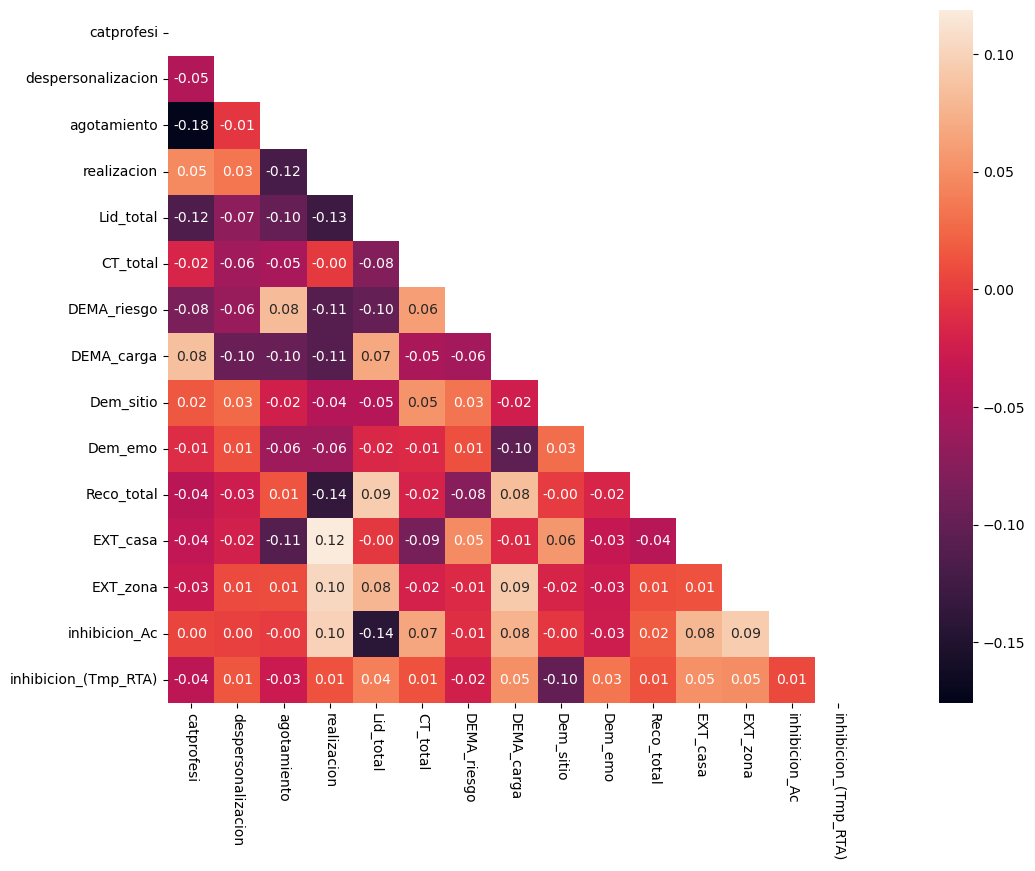

In [103]:
# Pearson Correlation
print(start + 'Correlaciones de Pearson' + end)

plt.figure(figsize=(20,9))

corr = df[['catprofesi', 'despersonalizacion',
        'agotamiento', 'realizacion', 'Lid_total', 'CT_total', 'DEMA_riesgo', 
       'DEMA_carga', 'Dem_sitio', 'Dem_emo', 'Reco_total', 'EXT_casa', 'EXT_zona',
        'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr_matrix = corr.mask(mask)

ax = sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 10}, fmt='.2f', square = True)

labels = ['catprofesi', 'despersonalizacion',
        'agotamiento', 'realizacion', 'Lid_total', 'CT_total', 'DEMA_riesgo', 
       'DEMA_carga', 'Dem_sitio', 'Dem_emo', 'Reco_total', 'EXT_casa', 'EXT_zona',
         'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']

ax.set_xticklabels(labels, rotation = 270, ha= 'center', fontsize=10)
ax.set_yticklabels(labels, rotation = 0, ha= 'right', fontsize=10)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)

del labels, corr, mask, corr_matrix

Relacion entre control inhibitorio y sindrome de Burnout


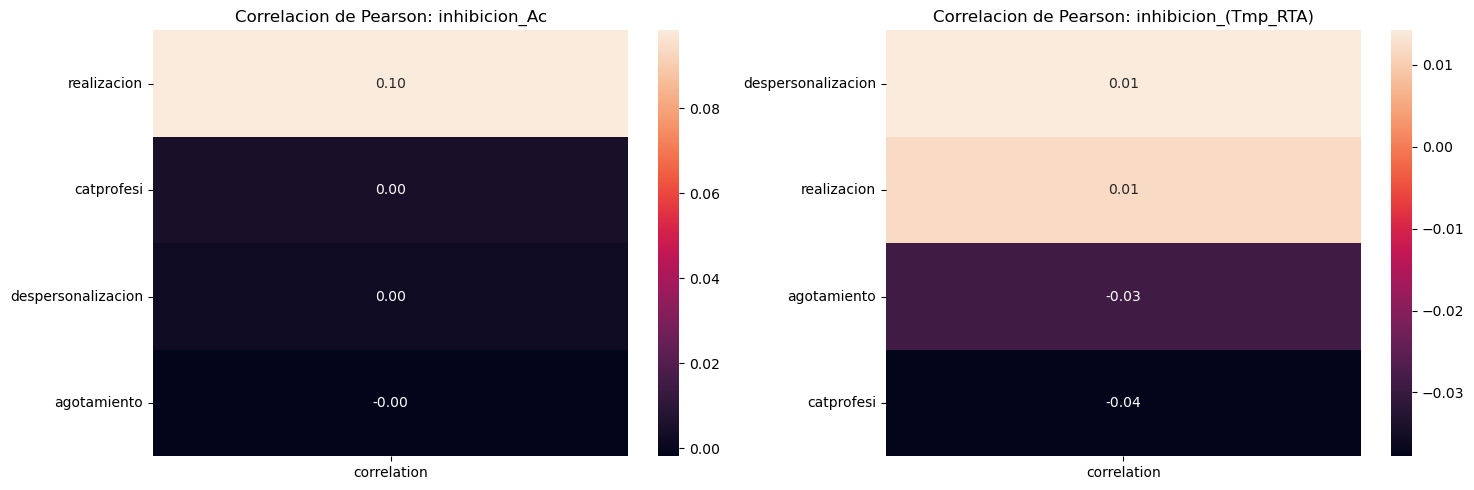

In [107]:
print(start + 'Relacion entre control inhibitorio y sindrome de Burnout' + end)

fig, axes = plt.subplots(1, ncols=2, figsize=(15, 5))

for i, target_column in enumerate(target_columns):
    corr = control_inhibitorio.drop(columns=target_columns, axis=1).corrwith(control_inhibitorio[target_column]).sort_values(ascending=False)
    sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[i])
    axes[i].set_title(f'Correlacion de Pearson: {target_column}')

plt.tight_layout()
plt.show()

## Interpretación de los resultados

Como se observó anteriormente, las variables del control inhibitorio no parecen demostrar una relación con los componentes del Burnout. Sin embargo, se adicionó la variable 'catprofesi' en el cálculo de los coeficientes de Pearson para analizar si existía una relación entre control inhibitorio y los componentes de Burnout dentro de los grupos de profesionales, sin embargo como se puede observar, los datos sugieren que no es así.

Adelante se realizaron las clasificaciones por tipos de profesionalpara visualizar como cambian las correlaciones.

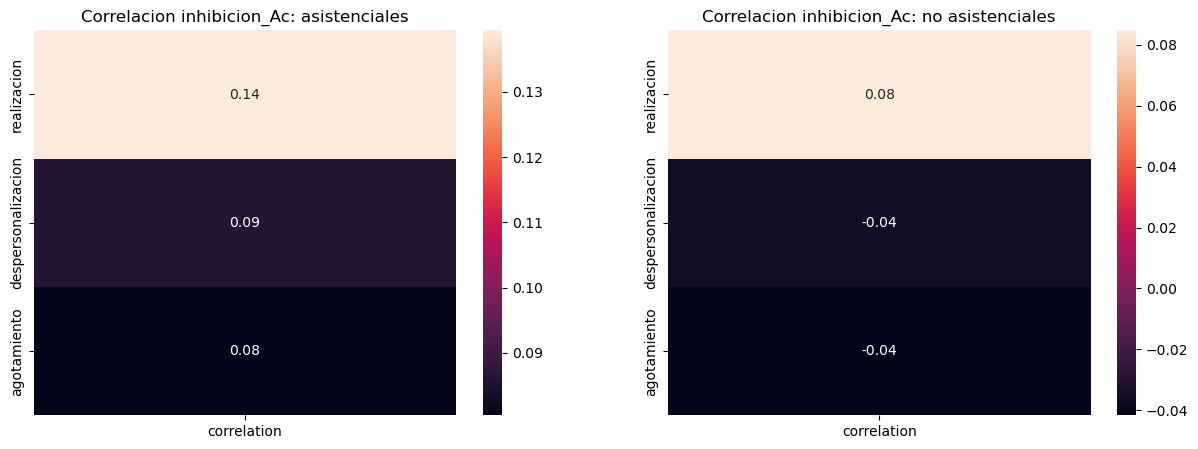

Prevalencia de Síntomas de Burnout - inhibicion_Ac bajo


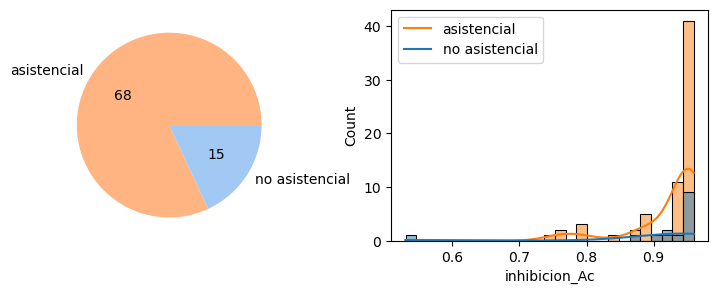

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 548.5
P-valor asociado: 0.6426845550166229
Prevalencia de Síntomas de Burnout - inhibicion_Ac alto


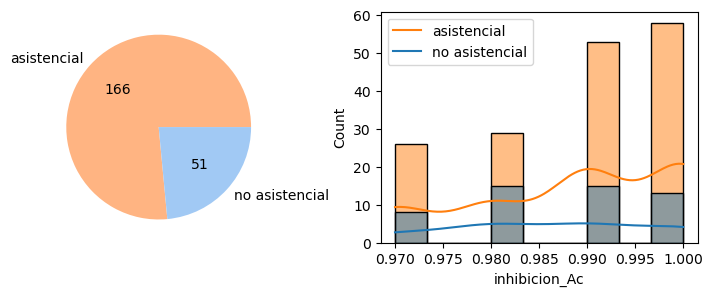

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 3715.0
P-valor asociado: 0.169370730838302


In [109]:
target_columns.append('catprofesi')
fig, axes = plt.subplots(1, ncols=2, figsize=(15, 5))

corr = control_inhibitorio[asis].drop(columns=target_columns, axis=1).corrwith(control_inhibitorio[asis]['inhibicion_Ac']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax = axes[0])
axes[0].set_title('Correlacion inhibicion_Ac: asistenciales')

corr = control_inhibitorio[no_asis].drop(columns=target_columns, axis=1).corrwith(control_inhibitorio[no_asis]['inhibicion_Ac']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax = axes[1])
axes[1].set_title('Correlacion inhibicion_Ac: no asistenciales')

plt.show()

control_inhibitorio = df[['despersonalizacion','agotamiento', 'realizacion', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)', 'catprofesi']]

inhibicionAc_bajo = control_inhibitorio[control_inhibitorio['inhibicion_Ac'] < 0.969]
inhibicionAc_alto = control_inhibitorio[control_inhibitorio['inhibicion_Ac'] >= 0.969]

efecto_SB(inhibicionAc_bajo, 'inhibicion_Ac', 'bajo')
efecto_SB(inhibicionAc_alto, 'inhibicion_Ac', 'alto')

## Interpretación de los resultados

Gráficas de dispersión - Agotamiento


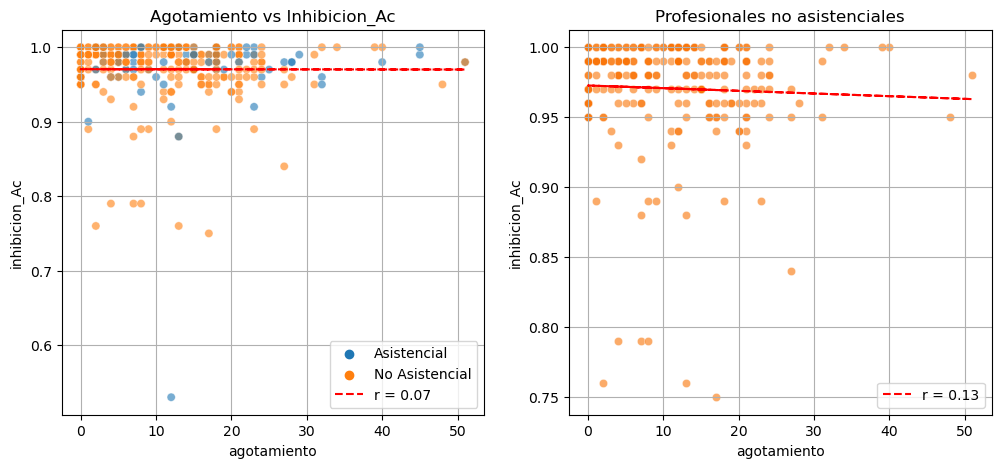

Gráficas de dispersión - Realizacion


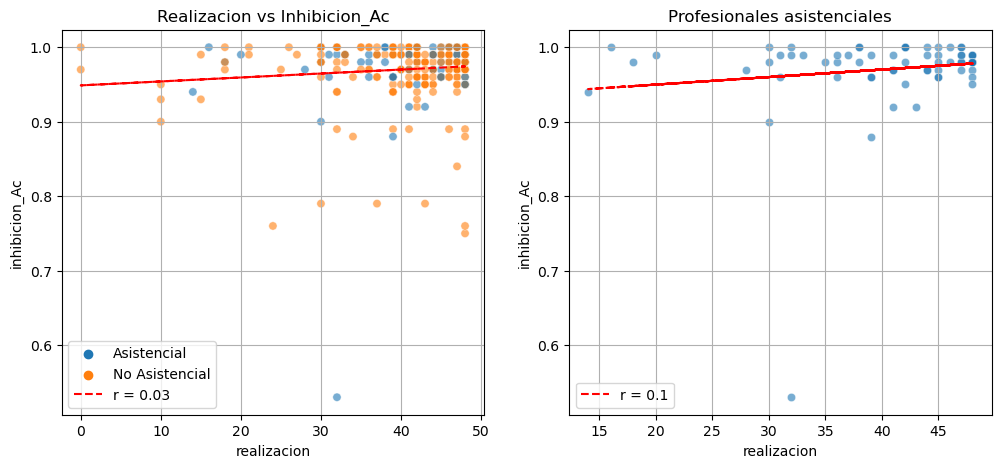

In [110]:
print(start + 'Gráficas de dispersión - Agotamiento' + end)
fig, axes = plt.subplots(1, ncols=2, figsize=(12, 5))
axes[0].set_title('Agotamiento vs Inhibicion_Ac')
sns.scatterplot(data=control_inhibitorio, x="agotamiento", y="inhibicion_Ac",hue='catprofesi', alpha=.6, ax = axes[0])
x = control_inhibitorio["agotamiento"]
y = control_inhibitorio["inhibicion_Ac"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = 0.07')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

axes[1].set_title('Profesionales no asistenciales')
sns.scatterplot(data= control_inhibitorio[no_asis], x="agotamiento", y="inhibicion_Ac",alpha=.6, ax = axes[1], color="#F97306")
x = control_inhibitorio[no_asis]["agotamiento"]
y = control_inhibitorio[no_asis]["inhibicion_Ac"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = 0.13')
axes[1].grid(True)
axes[1].legend()

plt.show()

print(start + 'Gráficas de dispersión - Realizacion' + end)
fig, axes = plt.subplots(1, ncols=2, figsize=(12, 5))
axes[0].set_title('Realizacion vs Inhibicion_Ac')
sns.scatterplot(data=control_inhibitorio, x="realizacion", y="inhibicion_Ac",hue='catprofesi', alpha=.6, ax = axes[0])
x = control_inhibitorio["realizacion"]
y = control_inhibitorio["inhibicion_Ac"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = 0.03')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

axes[1].set_title('Profesionales asistenciales')
sns.scatterplot(data= control_inhibitorio[asis], x="realizacion", y="inhibicion_Ac",alpha=.6, ax = axes[1])
x = control_inhibitorio[asis]["realizacion"]
y = control_inhibitorio[asis]["inhibicion_Ac"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = 0.1')
axes[1].grid(True)
axes[1].legend(loc='lower left')

plt.show()

- Se observa que los resultados del test U de Mann-Whitney no encontró diferencias entre los tipos de profesionales, dentro de las categorías de la variable **'inhibicion_(Tmp_RTA)'**. 
- En el análisis de correlación se encontró un aumento en la relación lineal entre **sintomas de agotamiento** y **Número de ciertos** en **profesionales no asistenciales**, en comparación con la correlación general encontrada. en la gráfica de dispersión se observa como la recta que se ajusta a alos datos tuvo una correlación de 0.07 y luego el coeficiente de correlación aumentó a 0.13. 
- El mismo comportamiento se observa para los **sintomas de realización**, pasando de un coeficiente de correlación de 0.03 a 0.1.

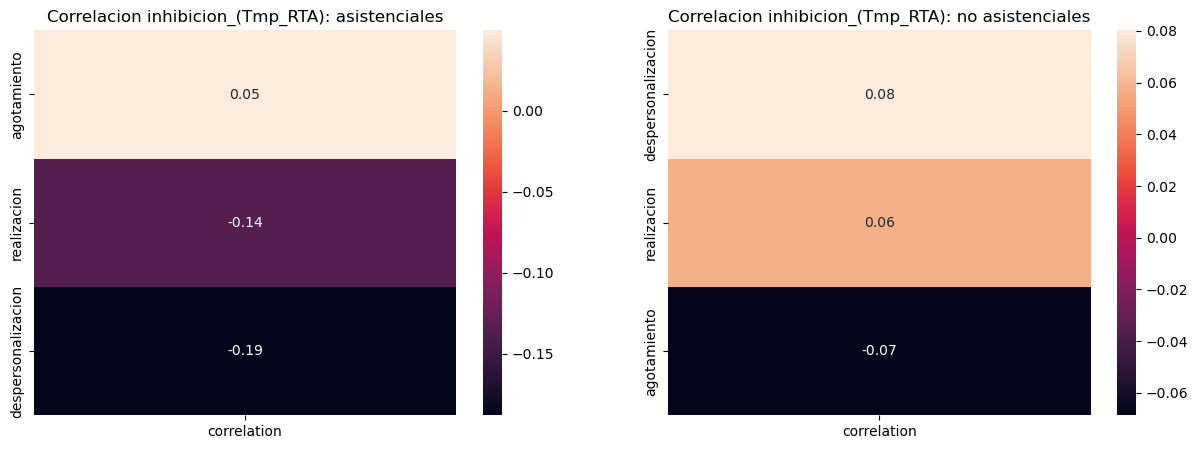

Prevalencia de Síntomas de Burnout - inhibicion_(Tmp_RTA) leve


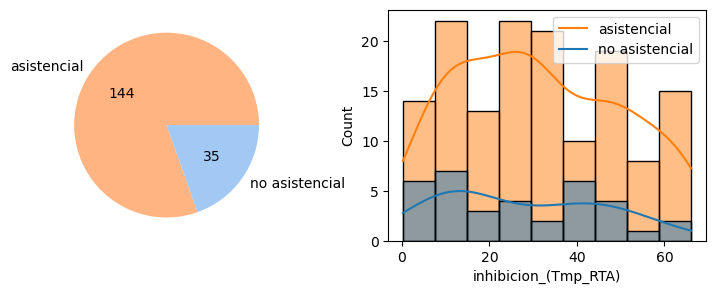

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 2209.5
P-valor asociado: 0.2595157738258841
Prevalencia de Síntomas de Burnout - inhibicion_(Tmp_RTA) grave


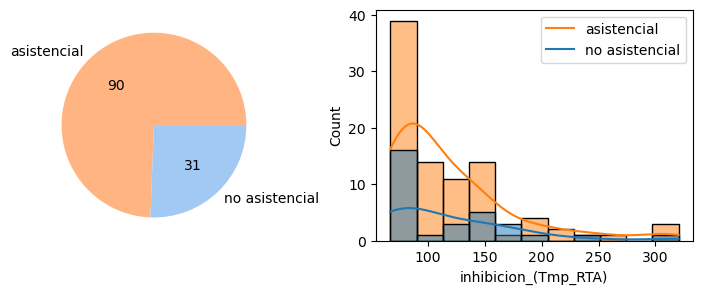

Resultados del test Mann-Whitney
Estadística U de Mann-Whitney: 1319.0
P-valor asociado: 0.6539048756586854


In [111]:
fig, axes = plt.subplots(1, ncols=2, figsize=(15, 5))

corr = control_inhibitorio[asis].drop(columns=target_columns, axis=1).corrwith(control_inhibitorio[asis]['inhibicion_(Tmp_RTA)']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax = axes[0])
axes[0].set_title('Correlacion inhibicion_(Tmp_RTA): asistenciales')

corr = control_inhibitorio[no_asis].drop(columns=target_columns, axis=1).corrwith(control_inhibitorio[no_asis]['inhibicion_(Tmp_RTA)']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax = axes[1])
axes[1].set_title('Correlacion inhibicion_(Tmp_RTA): no asistenciales')

plt.show()

inhibicionTmp_bajo = control_inhibitorio[control_inhibitorio['inhibicion_(Tmp_RTA)'] <66.13]
inhibicionTmp_alto = control_inhibitorio[control_inhibitorio['inhibicion_(Tmp_RTA)'] >= 66.13]

efecto_SB(inhibicionTmp_bajo, 'inhibicion_(Tmp_RTA)', 'leve')
efecto_SB(inhibicionTmp_alto, 'inhibicion_(Tmp_RTA)', 'grave')

## Interpretación de los resultados

Gráficas de dispersión


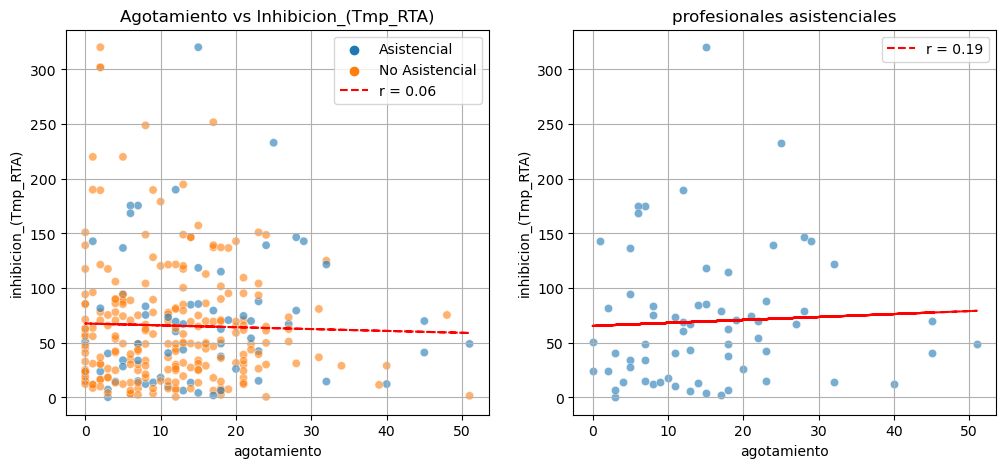

In [112]:
print(start + 'Gráficas de dispersión' + end)
fig, axes = plt.subplots(1, ncols=2, figsize=(12, 5))
axes[0].set_title('Agotamiento vs Inhibicion_(Tmp_RTA)')
sns.scatterplot(data=control_inhibitorio, x="agotamiento", y="inhibicion_(Tmp_RTA)", hue= 'catprofesi',alpha=.6, ax = axes[0])
x = control_inhibitorio["agotamiento"]
y = control_inhibitorio["inhibicion_(Tmp_RTA)"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = 0.06')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')


axes[1].set_title('profesionales asistenciales')
sns.scatterplot(data= control_inhibitorio[asis], x="agotamiento", y="inhibicion_(Tmp_RTA)",alpha=.6, ax = axes[1])
x = control_inhibitorio[asis]["agotamiento"]
y = control_inhibitorio[asis]["inhibicion_(Tmp_RTA)"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = 0.19')
axes[1].grid(True)
axes[1].legend()

plt.show()

- Se observa que los resultados del test U de Mann-Whitney no encontró diferencias entre los tipos de profesionales, dentro de las categorías de la variable **'inhibicion_(Tmp_RTA)'**. 
- En el análisis de correlación únicamente se encontró un aumento en la relación lineal entre  **sintomas de agotamiento** y **Tiempo de Respuesta** en **profesionales asistenciales**, en comparación con la correlación general encontrada. en la gráfica de dispersión se observa como la recta que se ajusta a alos datos tuvo una correlación de 0.06 y luego el coeficiente de correlación aumentó a 0.19, sin embargo estos coeficientes siguen siendo muy débiles para realizar un análisis multivariado de regresión.

# Hipótesis 

### 3. Establecer el impacto de los componentes de Burnout en el control inhibitorio <a id='Hipotesis_3'></a>

## Categorías de Despersonalización

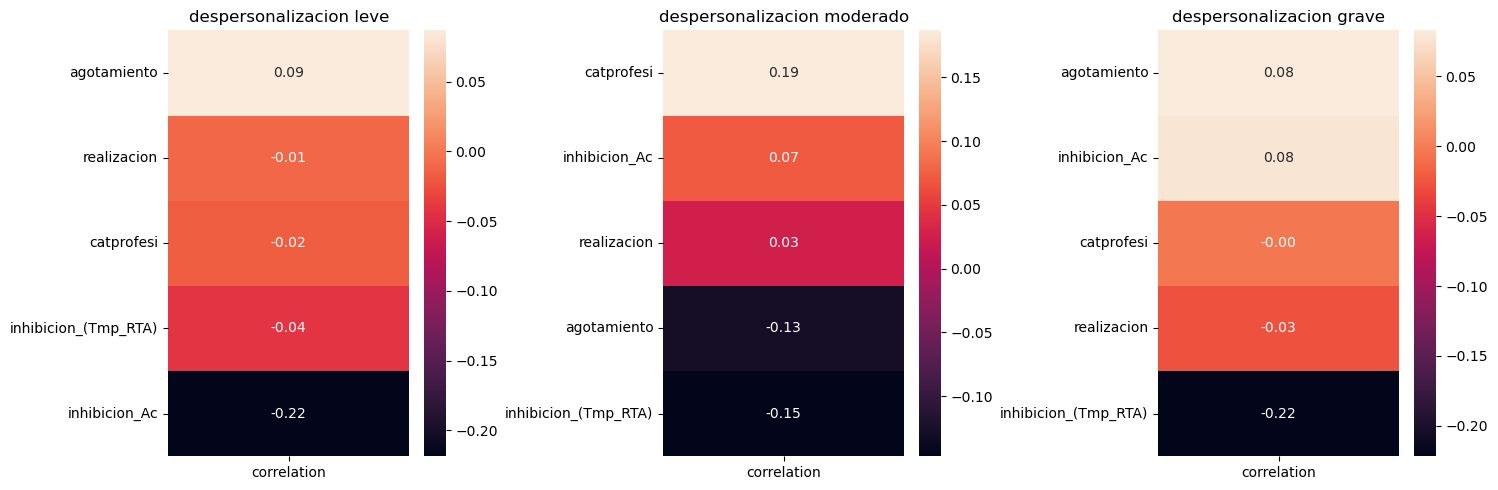

Distribución de los datos por categorías - despersonalizacion


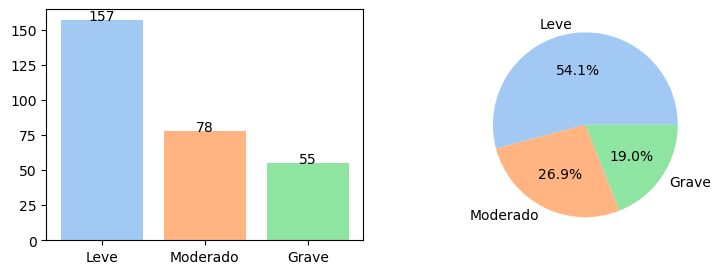

In [113]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
burnout = despersonalizacion_leve[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['despersonalizacion'], axis=1).corrwith(despersonalizacion_leve['despersonalizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[0])
axes[0].set_title('despersonalizacion leve')

burnout = despersonalizacion_moderado[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['despersonalizacion'], axis=1).corrwith(despersonalizacion_moderado['despersonalizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[1])
axes[1].set_title('despersonalizacion moderado')

burnout = despersonalizacion_grave[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['despersonalizacion'], axis=1).corrwith(despersonalizacion_grave['despersonalizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[2])
axes[2].set_title('despersonalizacion grave')
plt.tight_layout()
plt.show()

print(start + 'Distribución de los datos por categorías - despersonalizacion' + end)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
info = []
info.append(despersonalizacion_leve['despersonalizacion'].count())
info.append(despersonalizacion_moderado['despersonalizacion'].count())
info.append(despersonalizacion_grave['despersonalizacion'].count())

labels = ['Leve', 'Moderado', 'Grave']
colors = sns.color_palette('pastel')[0:5]

axs[0].bar(labels, info, color=colors)
for i, v in enumerate(info):
    axs[0].text(i, v, str(v), color='black', ha='center')
plt.grid()

axs[1].pie(info, labels=labels, colors=colors, autopct='%.1f%%')

plt.show()
del info, labels, colors, fig, axs

## Interpretación de los resultados

Gráficas de dispersión - Despersonalizacion


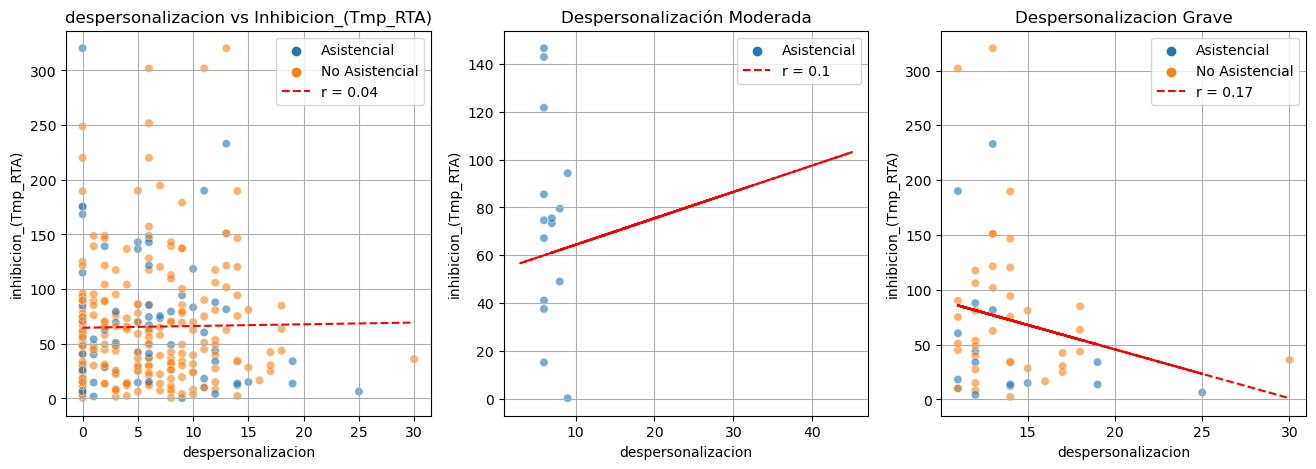

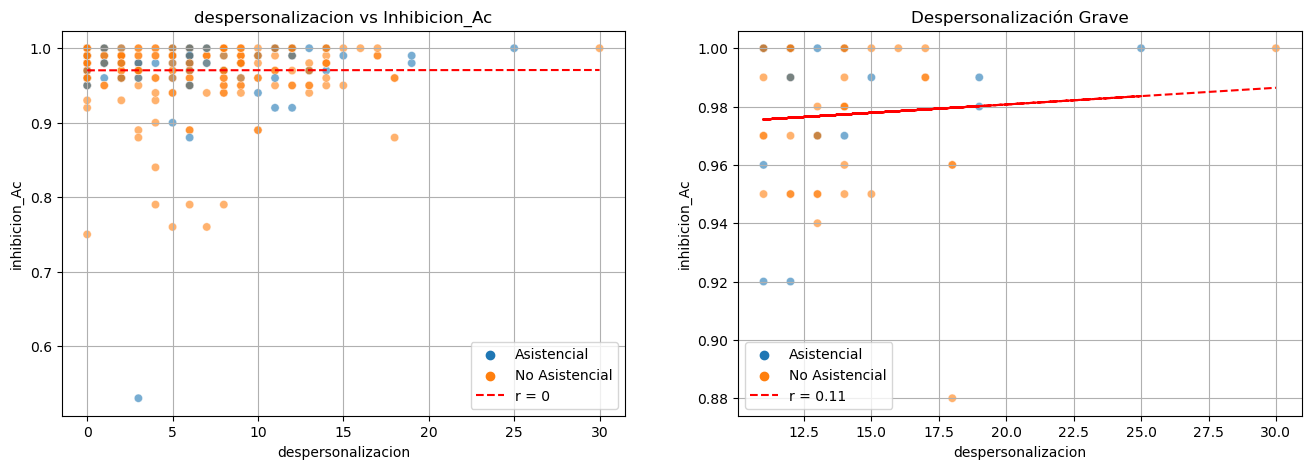

In [118]:
print(start + 'Gráficas de dispersión - Despersonalizacion' + end)
fig, axes = plt.subplots(1, ncols=3, figsize=(16, 5))
axes[0].set_title('despersonalizacion vs Inhibicion_(Tmp_RTA)')
sns.scatterplot(data=df, x="despersonalizacion", y="inhibicion_(Tmp_RTA)", hue= 'catprofesi',alpha=.6, ax = axes[0])
x = df["despersonalizacion"]
y = df["inhibicion_(Tmp_RTA)"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = 0.04')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')


axes[1].set_title('Despersonalización Moderada')
sns.scatterplot(data= despersonalizacion_moderado[asis], x="despersonalizacion", y="inhibicion_(Tmp_RTA)",hue = 'catprofesi', alpha=.6, ax = axes[1])
x = despersonalizacion_moderado[asis]["agotamiento"]
y = despersonalizacion_moderado[asis]["inhibicion_(Tmp_RTA)"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = 0.1')
axes[1].grid(True)
legend = axes[1].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')



axes[2].set_title('Despersonalizacion Grave')
sns.scatterplot(data=despersonalizacion_grave, x="despersonalizacion", y="inhibicion_(Tmp_RTA)", hue= 'catprofesi',alpha=.6, ax = axes[2])
x = despersonalizacion_grave["despersonalizacion"]
y = despersonalizacion_grave["inhibicion_(Tmp_RTA)"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[2].plot(x, p(x), color="red", linestyle="--", label='r = 0.17')
axes[2].grid(True)
legend = axes[2].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

plt.show()

fig, axes = plt.subplots(1, ncols=2, figsize=(16, 5))
axes[0].set_title('despersonalizacion vs Inhibicion_Ac')
sns.scatterplot(data=df, x="despersonalizacion", y="inhibicion_Ac", hue= 'catprofesi',alpha=.6, ax = axes[0])
x = df["despersonalizacion"]
y = df["inhibicion_Ac"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = 0')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')


axes[1].set_title('Despersonalización Grave')
sns.scatterplot(data= despersonalizacion_grave, x="despersonalizacion", y="inhibicion_Ac",hue = 'catprofesi', alpha=.6, ax = axes[1])
x = despersonalizacion_grave["despersonalizacion"]
y = despersonalizacion_grave["inhibicion_Ac"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = 0.11')
axes[1].grid(True)
legend = axes[1].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

plt.show()

- En el análisis de correlación se encontró un aumento en la relación lineal entre  **sintomas de despersonalizacion** y **Tiempo de Respuesta** dentro de la categorías de sintomas **Moderados** y **Graves**, en comparación con la correlación general encontrada. En la gráfica de dispersión se observa como la recta que se ajusta a alos datos tuvo una correlación de 0.04 y luego el coeficiente de correlación aumentó a 0.1 y 0.17, respectivamente. 
- Adicionalmente, se encontró un aumento en la relación lineal entre **sintomas de despersonalizacion** y **Número de Aciertos** dentro de la categorías de sintomas **Graves**, pasando de un coeficiente de correlación nulo a 0.11.

## Categorías de Agotamiento

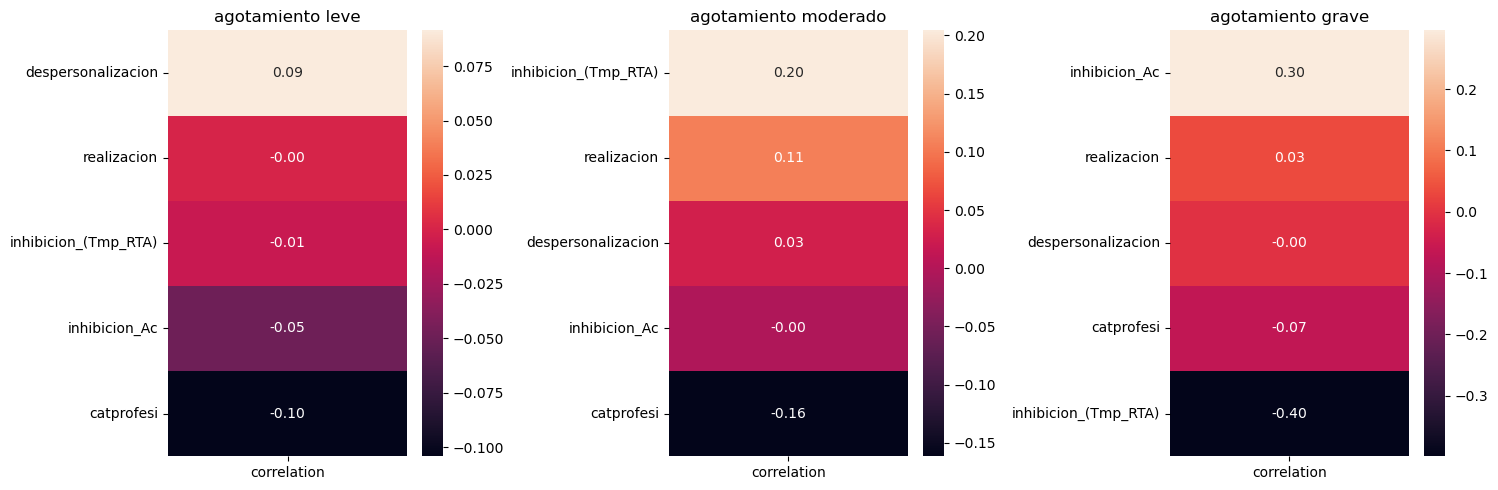

Distribución de los datos por categorías - agotamiento


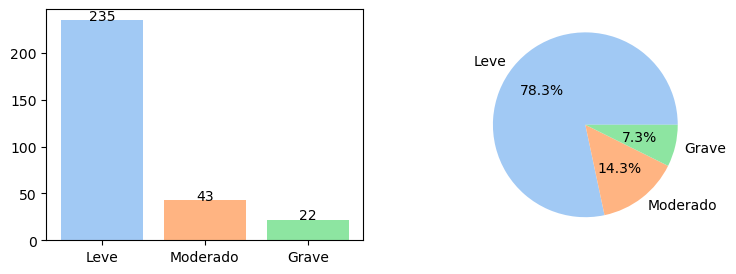

In [119]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
burnout = agotamiento_leve[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['agotamiento'], axis=1).corrwith(agotamiento_leve['agotamiento']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[0])
axes[0].set_title('agotamiento leve')

burnout = agotamiento_moderado[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['agotamiento'], axis=1).corrwith(agotamiento_moderado['agotamiento']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[1])
axes[1].set_title('agotamiento moderado')

burnout = agotamiento_grave[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['agotamiento'], axis=1).corrwith(agotamiento_grave['agotamiento']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[2])
axes[2].set_title('agotamiento grave')
plt.tight_layout()
plt.show()

print(start + 'Distribución de los datos por categorías - agotamiento' + end)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
info = []
info.append(agotamiento_leve['agotamiento'].count())
info.append(agotamiento_moderado['agotamiento'].count())
info.append(agotamiento_grave['agotamiento'].count())

labels = ['Leve', 'Moderado', 'Grave']
colors = sns.color_palette('pastel')[0:5]

axs[0].bar(labels, info, color=colors)
for i, v in enumerate(info):
    axs[0].text(i, v, str(v), color='black', ha='center')
plt.grid()

axs[1].pie(info, labels=labels, colors=colors, autopct='%.1f%%')

plt.show()
del info, labels, colors, fig, axs

## Interpretación de los resultados

Gráficas de dispersión


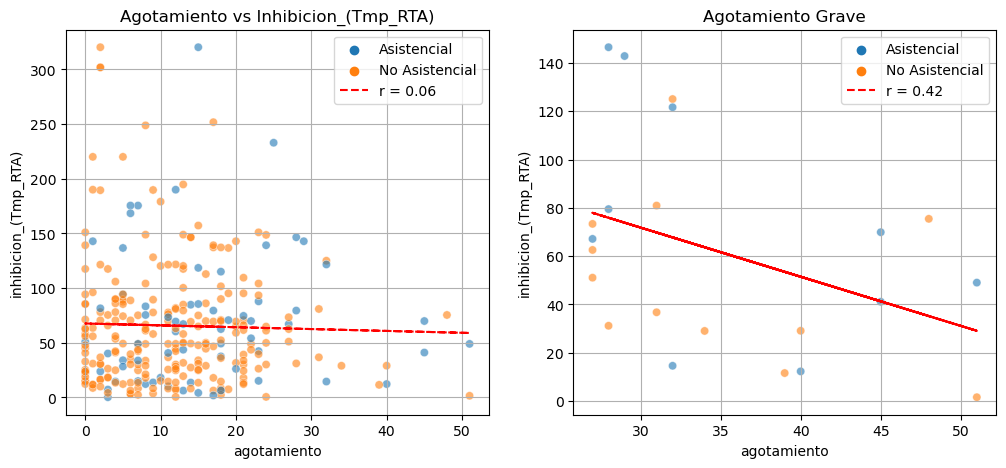

In [120]:
print(start + 'Gráficas de dispersión' + end)
fig, axes = plt.subplots(1, ncols=2, figsize=(12, 5))
axes[0].set_title('Agotamiento vs Inhibicion_(Tmp_RTA)')
sns.scatterplot(data=df, x="agotamiento", y="inhibicion_(Tmp_RTA)", hue= 'catprofesi',alpha=.6, ax = axes[0])
x = df["agotamiento"]
y = df["inhibicion_(Tmp_RTA)"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = 0.06')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')


axes[1].set_title('Agotamiento Grave')
sns.scatterplot(data= agotamiento_grave, x="agotamiento", y="inhibicion_(Tmp_RTA)",hue='catprofesi', alpha=.6, ax = axes[1])
x = agotamiento_grave["agotamiento"]
y = agotamiento_grave["inhibicion_(Tmp_RTA)"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = 0.42')
axes[1].grid(True)
legend = axes[1].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

plt.show()

- En el análisis de correlación únicamente se encontró un aumento en la relación lineal entre  **sintomas de agotamiento** y **Tiempo de Respuesta** dentro de la categorías de sintomas **Graves**, en comparación con la correlación general encontrada. En la gráfica de dispersión se observa como la recta que se ajusta a alos datos tuvo una correlación de 0.06 y luego el coeficiente de correlación aumentó a 0.42, sin embargo, debido a que sólo el 7.7% de los datos se encontraron dentro de la categoría de agotamiento grave, este coeficiente no es preciso.

## Categorías de Realización

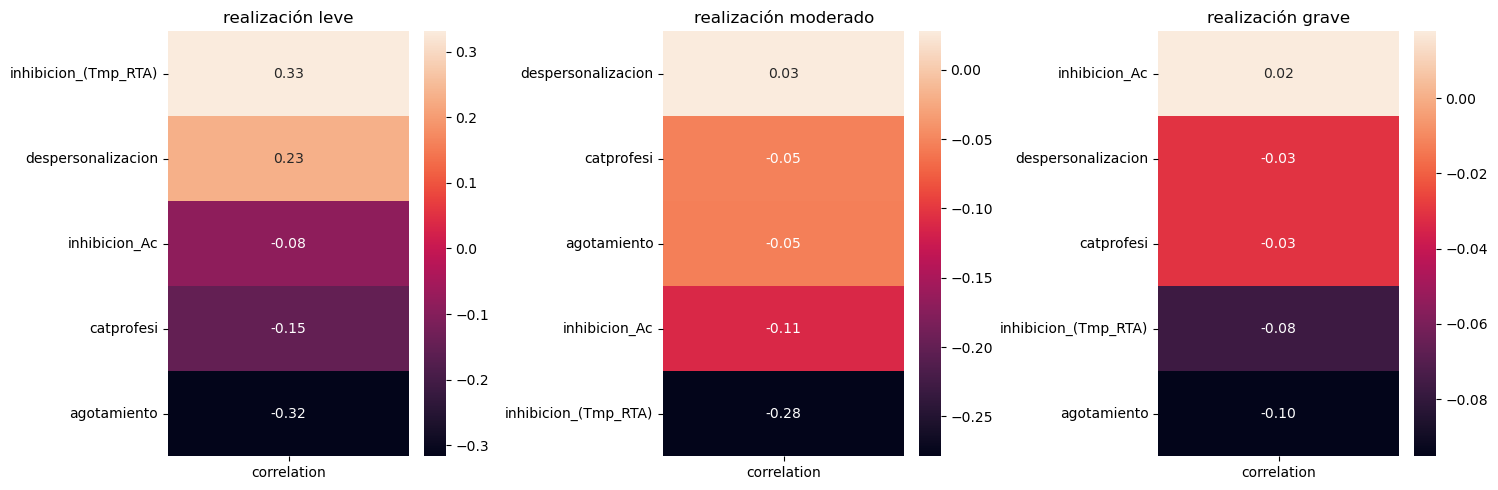

Distribución de los datos por categorías - realizacion


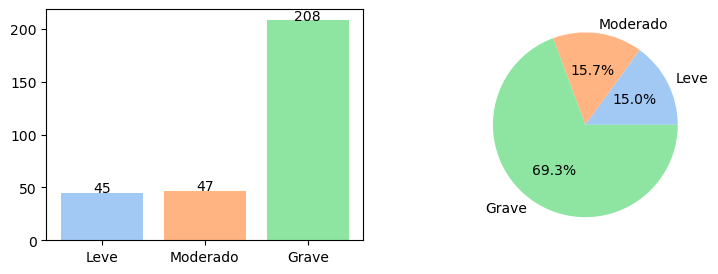

In [121]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
burnout = realizacion_leve[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['realizacion'], axis=1).corrwith(realizacion_leve['realizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[0])
axes[0].set_title('realización leve')

burnout = realizacion_moderado[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['realizacion'], axis=1).corrwith(realizacion_moderado['realizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[1])
axes[1].set_title('realización moderado')

burnout = realizacion_grave[['despersonalizacion', 'agotamiento', 'realizacion', 'catprofesi', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]
corr = burnout.drop(columns=['realizacion'], axis=1).corrwith(realizacion_grave['realizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[2])
axes[2].set_title('realización grave')
plt.tight_layout()
plt.show()

print(start + 'Distribución de los datos por categorías - realizacion' + end)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
info = []
info.append(realizacion_leve['realizacion'].count())
info.append(realizacion_moderado['realizacion'].count())
info.append(realizacion_grave['realizacion'].count())

labels = ['Leve', 'Moderado', 'Grave']
colors = sns.color_palette('pastel')[0:5]

axs[0].bar(labels, info, color=colors)
for i, v in enumerate(info):
    axs[0].text(i, v, str(v), color='black', ha='center')
plt.grid()

axs[1].pie(info, labels=labels, colors=colors, autopct='%.1f%%')

plt.show()
del info, labels, colors, fig, axs

## Interpretación de los resultados

Gráficas de dispersión


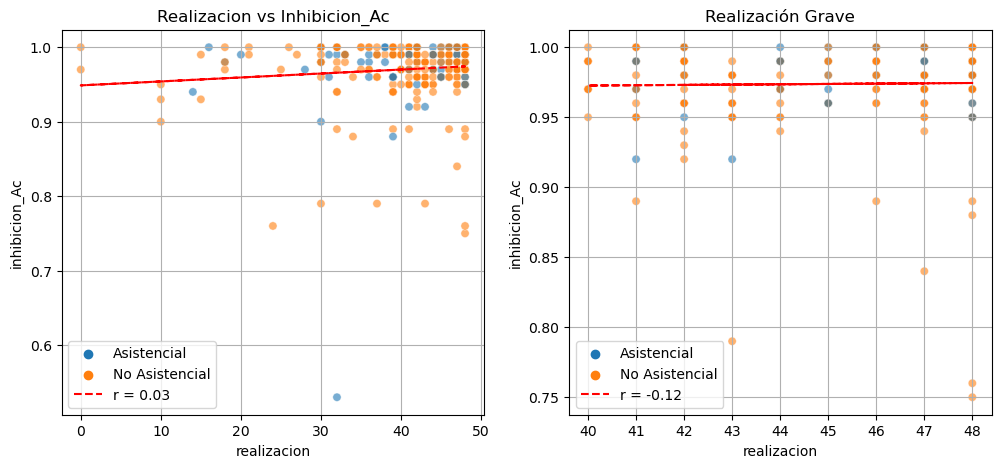

In [122]:
print(start + 'Gráficas de dispersión' + end)
fig, axes = plt.subplots(1, ncols=2, figsize=(12, 5))
axes[0].set_title('Realizacion vs Inhibicion_Ac')
sns.scatterplot(data=df, x="realizacion", y="inhibicion_Ac", hue= 'catprofesi',alpha=.6, ax = axes[0])
x = df["realizacion"]
y = df["inhibicion_Ac"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = 0.03')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')


axes[1].set_title('Realización Grave')
sns.scatterplot(data= realizacion_grave, x="realizacion", y="inhibicion_Ac",hue='catprofesi', alpha=.6, ax = axes[1])
x = realizacion_grave["realizacion"]
y = realizacion_grave["inhibicion_Ac"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = -0.12')
axes[1].grid(True)
legend = axes[1].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

plt.show()

- En el análisis de correlación se encontró una disminución en la relación lineal entre  **sintomas de realización** y **Número de Aciertos** dentro de la categorías de sintomas **Graves**, en comparación con la correlación general encontrada. En la gráfica de dispersión se observa como la recta que se ajusta a alos datos tuvo una correlación de 0.03 y luego el coeficiente de correlación disminuyó a -0.12. Lo que indica que a medida que aumenta la realización, el número de aciertos disminuyen.

# Hipótesis
### 4. Asociación del liderazgo con el desarrollo del Burnout <a id='Hipotesis_4'></a>

## Impacto de los síntomas de Burnout en el control inhibitorio

In [123]:
riesgo_psicosocial = df[['despersonalizacion','agotamiento', 'realizacion', 'Lid_total', 'CT_total', 'DEMA_riesgo',
                           'DEMA_carga', 'Dem_sitio', 'Dem_emo', 'Reco_total', 'EXT_casa', 'EXT_zona', 'catprofesi']]

# Categorías para Agotamiento
agotamiento_leve = riesgo_psicosocial[riesgo_psicosocial['agotamiento'] < 19]
medio = (riesgo_psicosocial['agotamiento'] < 26) & (riesgo_psicosocial['agotamiento'] >= 19)
agotamiento_moderado = riesgo_psicosocial[medio]
agotamiento_grave = riesgo_psicosocial[riesgo_psicosocial['agotamiento'] >= 26]

# Categorías para Despersonalización
despersonalizacion_leve = riesgo_psicosocial[riesgo_psicosocial['despersonalizacion'] < 6]
medio = (riesgo_psicosocial['despersonalizacion'] < 9) & (riesgo_psicosocial['despersonalizacion'] >= 6)
despersonalizacion_moderado = riesgo_psicosocial[medio]
despersonalizacion_grave = riesgo_psicosocial[riesgo_psicosocial['despersonalizacion'] >= 10]

# Categorías para Realización
realizacion_leve = riesgo_psicosocial[riesgo_psicosocial['realizacion'] < 33]
medio = (riesgo_psicosocial['realizacion'] < 39) & (riesgo_psicosocial['realizacion'] >= 33)
realizacion_moderado = riesgo_psicosocial[medio]
realizacion_grave = riesgo_psicosocial[riesgo_psicosocial['realizacion'] >= 39]

del medio

### Relacion entre riesgo psicosocial y sindrome de Burnout

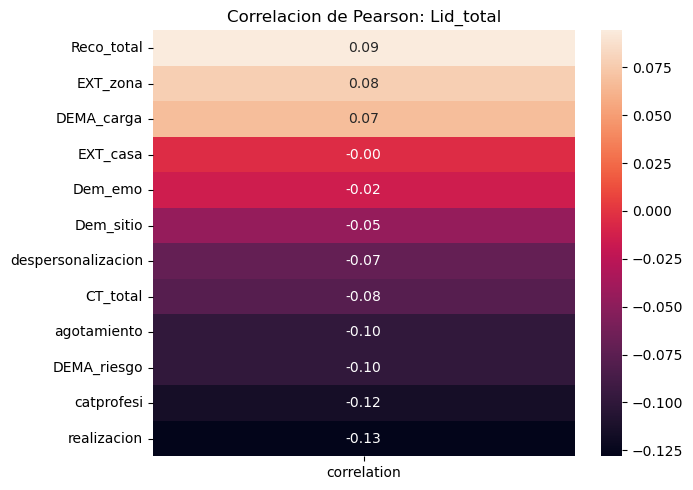

In [124]:
target_columns = ['Lid_total']

plt.figure(figsize=(7,5))

corr = riesgo_psicosocial.drop('Lid_total', axis=1).corrwith(riesgo_psicosocial['Lid_total']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f')
plt.title('Correlacion de Pearson: Lid_total')

plt.tight_layout()
plt.show()

## Interpretación de los resultados

### Categorías despersonalizacion vs riesgo psicosocial

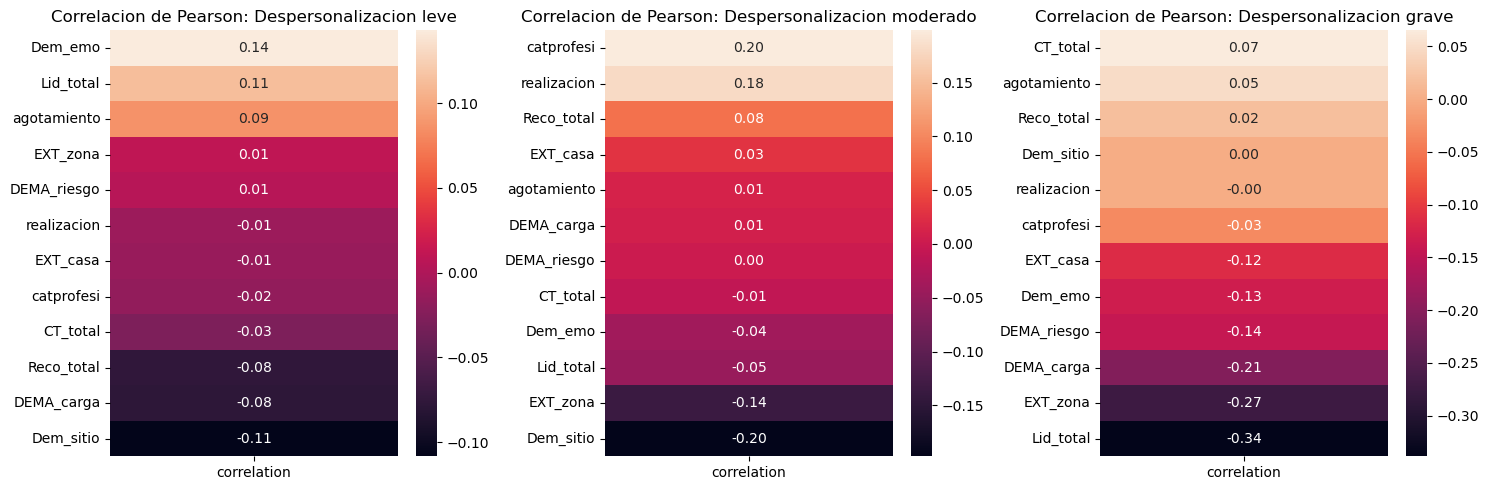

Distribución de los datos por categorías - despersonalizacion


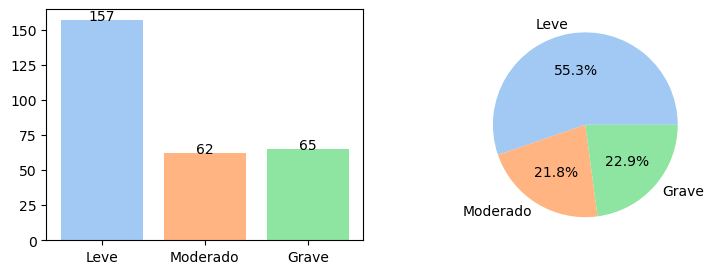

In [125]:
fig, axes = plt.subplots(1, ncols=3, figsize=(15, 5))

#Despersonalizacion Leve
corr = despersonalizacion_leve.drop(columns='despersonalizacion', axis=1).corrwith(despersonalizacion_leve['despersonalizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[0])
axes[0].set_title(f'Correlacion de Pearson: Despersonalizacion leve')

#Despersonalizacion Moderado
corr = despersonalizacion_moderado.drop(columns='despersonalizacion', axis=1).corrwith(despersonalizacion_moderado['despersonalizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[1])
axes[1].set_title(f'Correlacion de Pearson: Despersonalizacion moderado')

#Despersonalizacion Grave
corr = despersonalizacion_grave.drop(columns='despersonalizacion', axis=1).corrwith(despersonalizacion_grave['despersonalizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[2])
axes[2].set_title(f'Correlacion de Pearson: Despersonalizacion grave')


plt.tight_layout()
plt.show()

print(start + 'Distribución de los datos por categorías - despersonalizacion' + end)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
info = []
info.append(despersonalizacion_leve['despersonalizacion'].count())
info.append(despersonalizacion_moderado['despersonalizacion'].count())
info.append(despersonalizacion_grave['despersonalizacion'].count())

labels = ['Leve', 'Moderado', 'Grave']
colors = sns.color_palette('pastel')[0:5]

axs[0].bar(labels, info, color=colors)
for i, v in enumerate(info):
    axs[0].text(i, v, str(v), color='black', ha='center')
plt.grid()

axs[1].pie(info, labels=labels, colors=colors, autopct='%.1f%%')

plt.show()

#del fig, axes, despersonalizacion_leve, despersonalizacion_moderado, despersonalizacion_grave, info, labels, colors

## Interpretación de los resultados

Gráficas de dispersión - Despersonalizacion


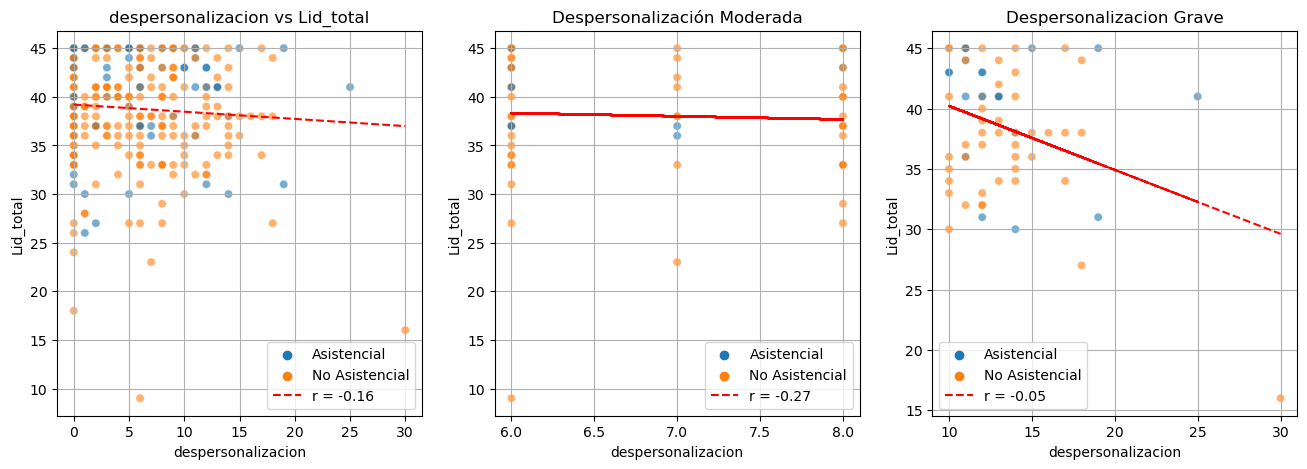

In [126]:
print(start + 'Gráficas de dispersión - Despersonalizacion' + end)
fig, axes = plt.subplots(1, ncols=3, figsize=(16, 5))
axes[0].set_title('despersonalizacion vs Lid_total')
sns.scatterplot(data=df, x="despersonalizacion", y="Lid_total", hue= 'catprofesi',alpha=.6, ax = axes[0])
x = df["despersonalizacion"]
y = df["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = -0.16')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')


axes[1].set_title('Despersonalización Moderada')
sns.scatterplot(data= despersonalizacion_moderado, x="despersonalizacion", y="Lid_total",hue = 'catprofesi', alpha=.6, ax = axes[1])
x = despersonalizacion_moderado["despersonalizacion"]
y = despersonalizacion_moderado["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = -0.27')
axes[1].grid(True)
legend = axes[1].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')



axes[2].set_title('Despersonalizacion Grave')
sns.scatterplot(data=despersonalizacion_grave, x="despersonalizacion", y="Lid_total", hue= 'catprofesi',alpha=.6, ax = axes[2])
x = despersonalizacion_grave["despersonalizacion"]
y = despersonalizacion_grave["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[2].plot(x, p(x), color="red", linestyle="--", label='r = -0.05')
axes[2].grid(True)
legend = axes[2].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

plt.show()

En el análisis de correlación se encontró que:
- Dentro de la categoría de **sintomas de despersonalización moderados**, la correlación entre la despersonalización y Liderazgo total dismunuyó, lo que indica que a medida que la despersonalización aumenta, el factor de liderazgo disminuye. En la gráfica de dispersión se observa como la recta que mejor se ajusta a los datos tuvo una correlación de -0.16 y luego disminuyó a -0.27.
- Dentro de la categoría de **sintomas de despersonalización graves**, el comportamiento fue al contrario, en la gráfica de dispersión el coeficiente de correlación subió de -0.16 a -0.05. Lo cual indica que a medida que los sintomas de despersonalización aumentan, el factor de liderazgo disminuye a un ritmo más desacelerado. 

### Categorías agotamiento vs riesgo psicosocial

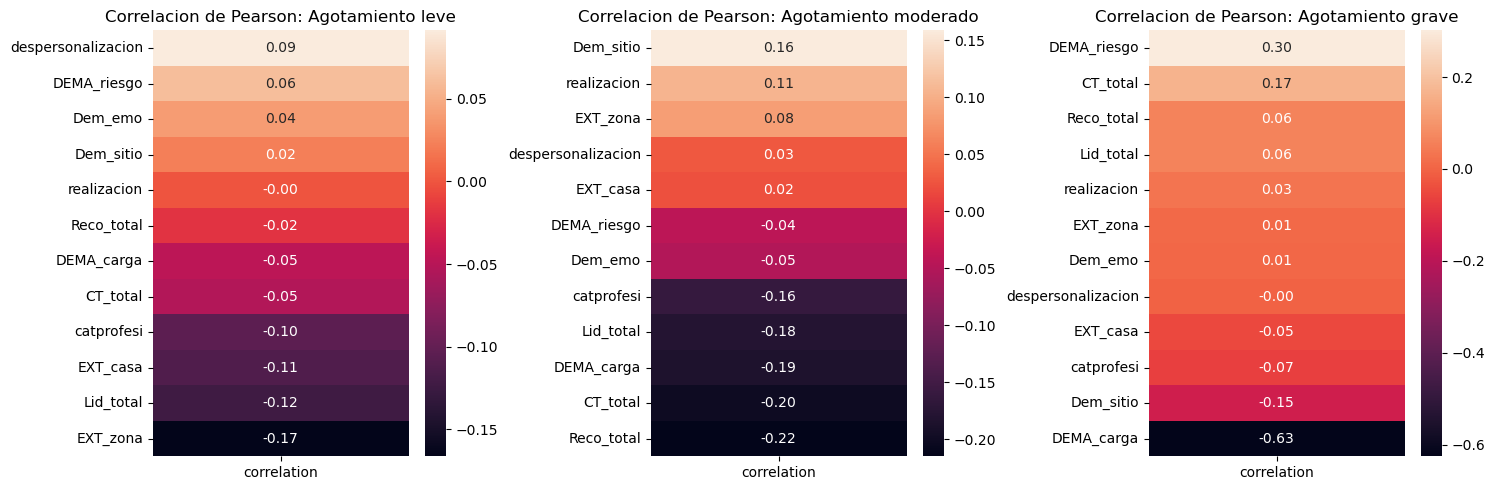

Distribución de los datos por categorías - agotamiento


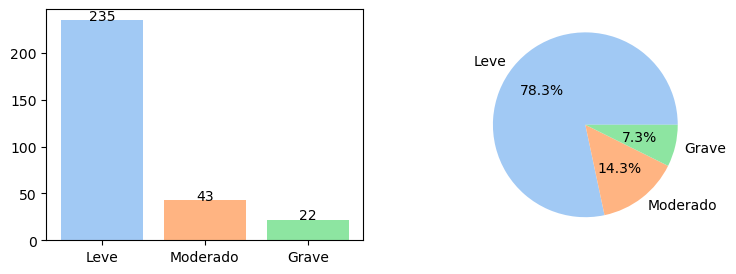

In [127]:
fig, axes = plt.subplots(1, ncols=3, figsize=(15, 5))

#Agotamiento Bajo
corr = agotamiento_leve.drop(columns='agotamiento', axis=1).corrwith(agotamiento_leve['agotamiento']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[0])
axes[0].set_title(f'Correlacion de Pearson: Agotamiento leve')

#Agotamiento Medio
corr = agotamiento_moderado.drop(columns='agotamiento', axis=1).corrwith(agotamiento_moderado['agotamiento']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[1])
axes[1].set_title(f'Correlacion de Pearson: Agotamiento moderado')

#Agotamiento Alto
corr = agotamiento_grave.drop(columns='agotamiento', axis=1).corrwith(agotamiento_grave['agotamiento']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[2])
axes[2].set_title(f'Correlacion de Pearson: Agotamiento grave')

plt.tight_layout()
plt.show()

print(start + 'Distribución de los datos por categorías - agotamiento' + end)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
info = []
info.append(agotamiento_leve['agotamiento'].count())
info.append(agotamiento_moderado['agotamiento'].count())
info.append(agotamiento_grave['agotamiento'].count())

labels = ['Leve', 'Moderado', 'Grave']
colors = sns.color_palette('pastel')[0:5]

axs[0].bar(labels, info, color=colors)
for i, v in enumerate(info):
    axs[0].text(i, v, str(v), color='black', ha='center')
plt.grid()

axs[1].pie(info, labels=labels, colors=colors, autopct='%.1f%%')

plt.show()

#del fig, axes, agotamiento_leve, agotamiento_moderado, agotamiento_grave, info, labels, colors

## Interpretación de los datos

Gráficas de dispersión - Agotamiento


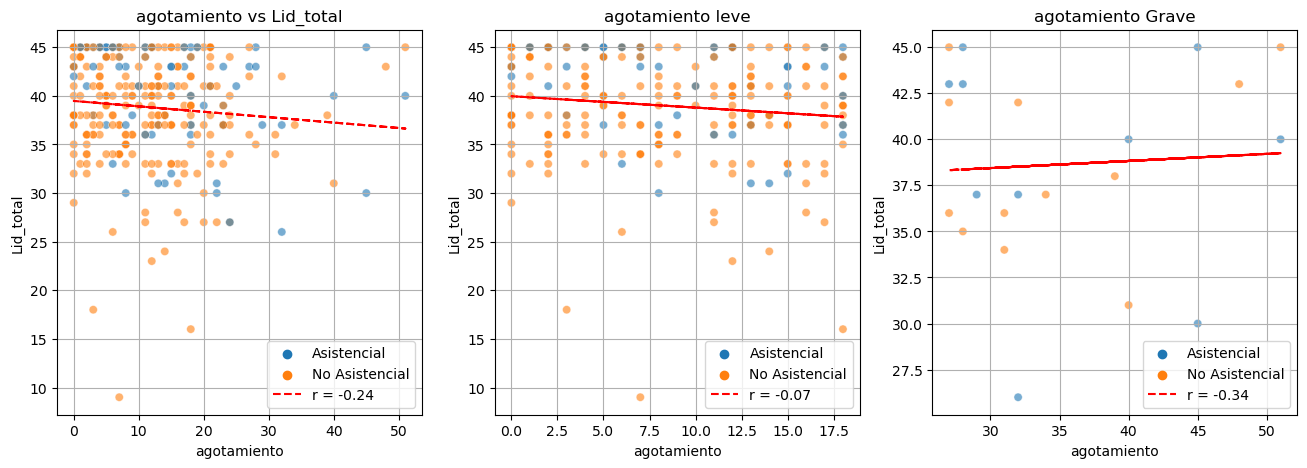

In [128]:
print(start + 'Gráficas de dispersión - Agotamiento' + end)
fig, axes = plt.subplots(1, ncols=3, figsize=(16, 5))
axes[0].set_title('agotamiento vs Lid_total')
sns.scatterplot(data=df, x="agotamiento", y="Lid_total", hue= 'catprofesi',alpha=.6, ax = axes[0])
x = df["agotamiento"]
y = df["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = -0.24')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')


axes[1].set_title('agotamiento leve')
sns.scatterplot(data= agotamiento_leve, x="agotamiento", y="Lid_total",hue = 'catprofesi', alpha=.6, ax = axes[1])
x = agotamiento_leve["agotamiento"]
y = agotamiento_leve["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = -0.07')
axes[1].grid(True)
legend = axes[1].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')



axes[2].set_title('agotamiento Grave')
sns.scatterplot(data=agotamiento_grave, x="agotamiento", y="Lid_total", hue= 'catprofesi',alpha=.6, ax = axes[2])
x = agotamiento_grave["agotamiento"]
y = agotamiento_grave["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[2].plot(x, p(x), color="red", linestyle="--", label='r = -0.34')
axes[2].grid(True)
legend = axes[2].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

plt.show()

En el análisis de correlación se encontró que:
- Dentro de la categoría de **sintomas de agotamiento leves**, la correlación entre la agotamiento y Liderazgo total aumentó, lo que indica que a medida que el agotamiento aumenta, el factor de liderazgo disminuye a un ritmo más desacelerado. En la gráfica de dispersión se observa como la recta que mejor se ajusta a los datos tuvo una correlación de -0.24 y luego aumentó a -0.07.
- Dentro de la categoría de **sintomas de agotamiento graves**, el comportamiento fue al contrario, en la gráfica de dispersión el coeficiente de correlación bajó de -0.24 a -0.34. Lo cual indica que a medida que los sintomas de agotamiento aumentan, el factor de liderazgo disminuye a un ritmo más acelerado, sin embargo únicamente el 8.8% de los datos se encontraron dentro de la categoría de sintomas graves, por lo que debido a la falta de datos, este coeficiente no es preciso.

### Categorías realización vs riesgo psicosocial

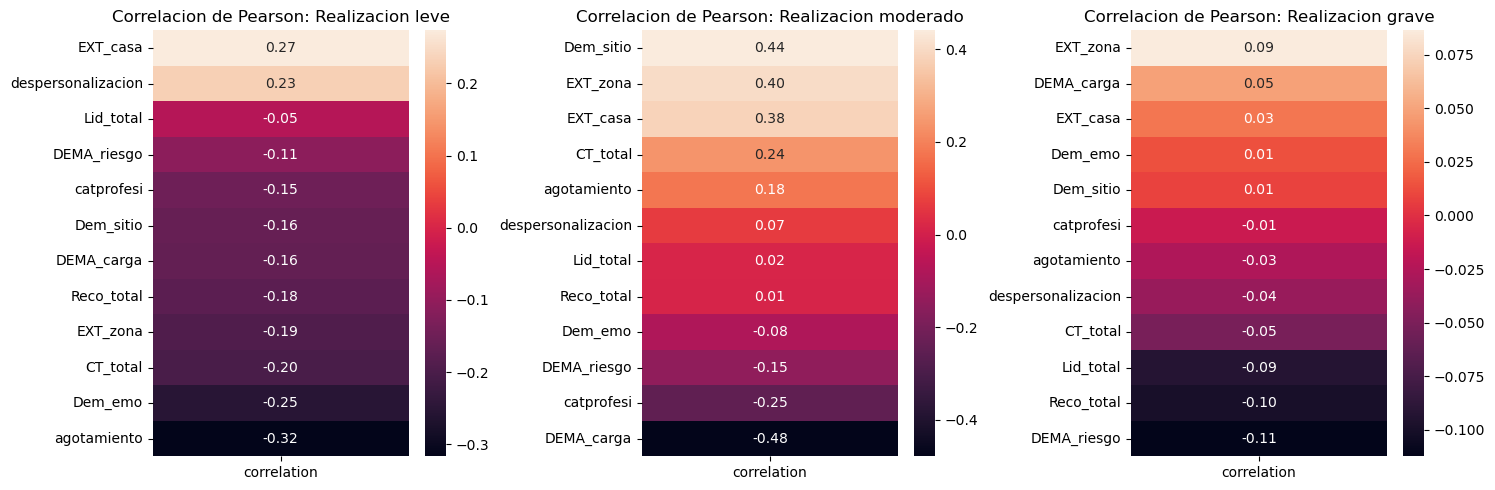

Distribución de los datos por categorías - realizacion


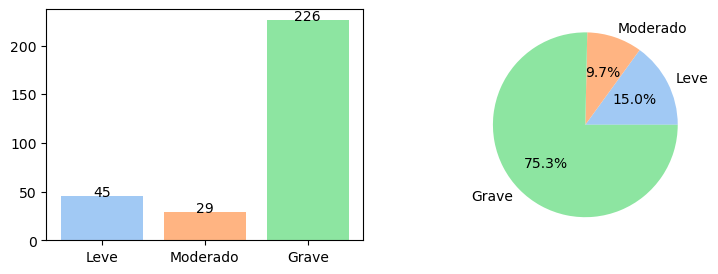

In [129]:
fig, axes = plt.subplots(1, ncols=3, figsize=(15, 5))

#Realizacion Leve
corr = realizacion_leve.drop(columns='realizacion', axis=1).corrwith(realizacion_leve['realizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[0])
axes[0].set_title(f'Correlacion de Pearson: Realizacion leve')

#Realizacion Moderado
corr = realizacion_moderado.drop(columns='realizacion', axis=1).corrwith(realizacion_moderado['realizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[1])
axes[1].set_title(f'Correlacion de Pearson: Realizacion moderado')

#Realizacion Grave
corr = realizacion_grave.drop(columns='realizacion', axis=1).corrwith(realizacion_grave['realizacion']).sort_values(ascending=False)
sns.heatmap(pd.DataFrame(corr, columns=['correlation']), annot=True, fmt='.2f', ax=axes[2])
axes[2].set_title(f'Correlacion de Pearson: Realizacion grave')


plt.tight_layout()
plt.show()

print(start + 'Distribución de los datos por categorías - realizacion' + end)
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
info = []
info.append(realizacion_leve['realizacion'].count())
info.append(realizacion_moderado['realizacion'].count())
info.append(realizacion_grave['realizacion'].count())

labels = ['Leve', 'Moderado', 'Grave']
colors = sns.color_palette('pastel')[0:5]

axs[0].bar(labels, info, color=colors)
for i, v in enumerate(info):
    axs[0].text(i, v, str(v), color='black', ha='center')
plt.grid()

axs[1].pie(info, labels=labels, colors=colors, autopct='%.1f%%')

plt.show()


#del fig, axes, realizacion_leve, realizacion_moderado, realizacion_grave, labels, colors

## Interpretación de los resultados

Gráficas de dispersión - Realizacion


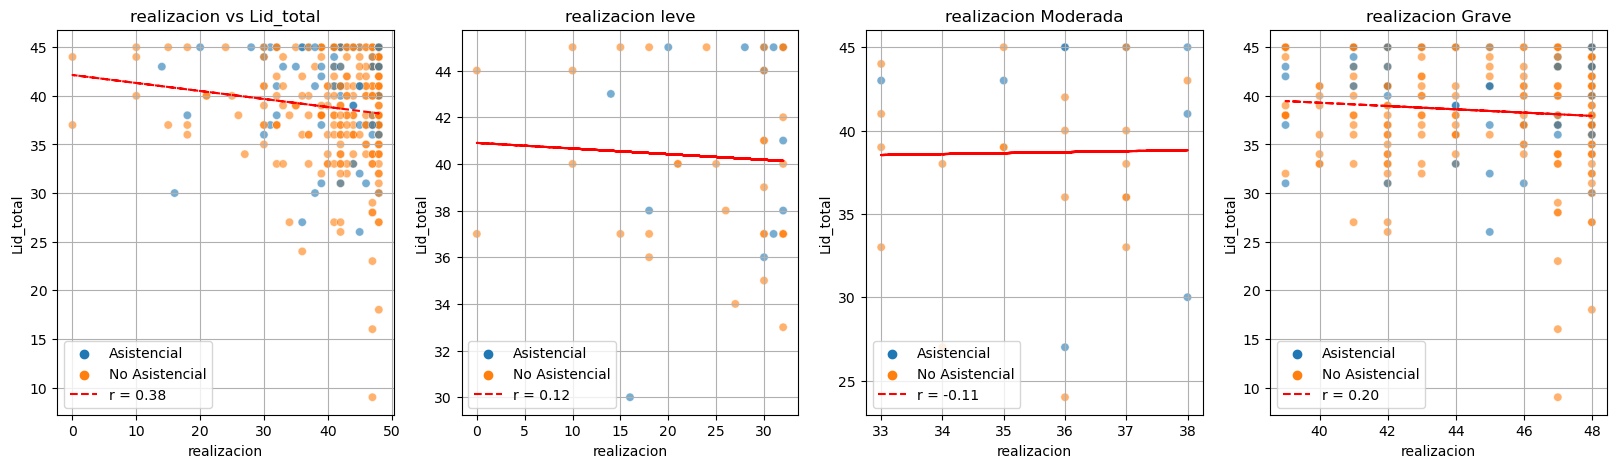

In [130]:
print(start + 'Gráficas de dispersión - Realizacion' + end)
fig, axes = plt.subplots(1, ncols=4, figsize=(20, 5))
axes[0].set_title('realizacion vs Lid_total')
sns.scatterplot(data=df, x="realizacion", y="Lid_total", hue= 'catprofesi',alpha=.6, ax = axes[0])
x = df["realizacion"]
y = df["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0].plot(x, p(x), color="red", linestyle="--", label='r = 0.38')
axes[0].grid(True)
legend = axes[0].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')


axes[1].set_title('realizacion leve')
sns.scatterplot(data= realizacion_leve, x="realizacion", y="Lid_total",hue = 'catprofesi', alpha=.6, ax = axes[1])
x = realizacion_leve["realizacion"]
y = realizacion_leve["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1].plot(x, p(x), color="red", linestyle="--", label='r = 0.12')
axes[1].grid(True)
legend = axes[1].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

axes[2].set_title('realizacion Moderada')
sns.scatterplot(data= realizacion_moderado, x="realizacion", y="Lid_total",hue = 'catprofesi', alpha=.6, ax = axes[2])
x = realizacion_moderado["realizacion"]
y = realizacion_moderado["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[2].plot(x, p(x), color="red", linestyle="--", label='r = -0.11')
axes[2].grid(True)
legend = axes[2].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

axes[3].set_title('realizacion Grave')
sns.scatterplot(data=realizacion_grave, x="realizacion", y="Lid_total", hue= 'catprofesi',alpha=.6, ax = axes[3])
x = realizacion_grave["realizacion"]
y = realizacion_grave["Lid_total"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[3].plot(x, p(x), color="red", linestyle="--", label='r = 0.20')
axes[3].grid(True)
legend = axes[3].legend( loc='best')
legend.get_texts()[0].set_text('Asistencial')
legend.get_texts()[1].set_text('No Asistencial')

plt.show()

En el análisis de correlación se encontraron diferencias en cada una de las categorías de la variable **realizacion**:
- Dentro de la categoría de **sintomas de realizacion leves**, la correlación entre la realizacion y Liderazgo total disminuyó, lo que indica que a medida que la realización aumenta, el factor de liderazgo aumenta a un ritmo más desacelerado. En la gráfica de dispersión se observa como la recta que mejor se ajusta a los datos tuvo una correlación de 0.38 y luego disminuyó a 0.12.
- Dentro de la categoría de **sintomas de realizacion moderados**, la correlación entre la realizacion y Liderazgo total disminuyó, ahora a medida que la realización aumenta, el factor de liderazgo disminuye. En la gráfica de dispersión se observa como la recta que mejor se ajusta a los datos tuvo una correlación de 0.38 y luego disminuyó a -0.11.
- Dentro de la categoría de **sintomas de realizacion graves**, el comportamiento fue similar a los sintomas leves, en la gráfica de dispersión el coeficiente de correlación bajó de 0.38 a 0.20. Lo cual indica que a medida que los sintomas de realización aumentan, el factor de liderazgo aumenta a un ritmo más desacelerado. 

Variable DEMA_riesgo


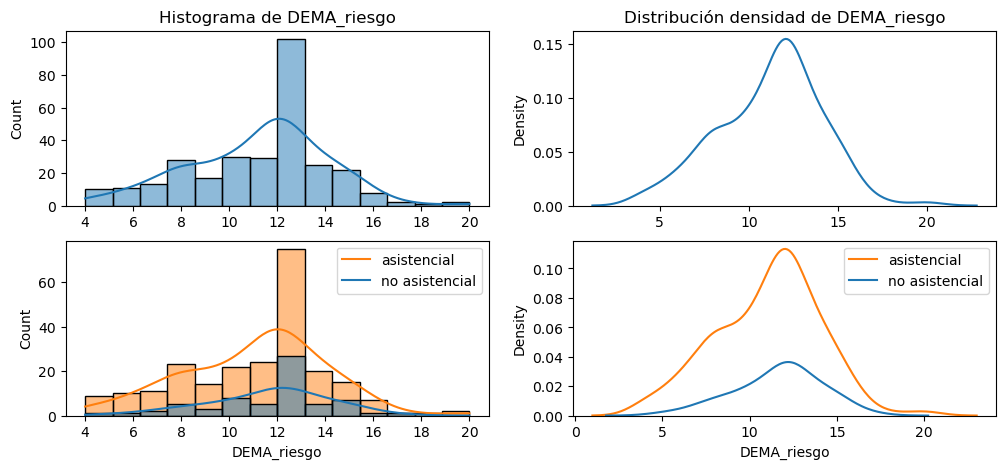

Resultados test shapiro - DEMA_riesgo
                    stat  test_shapiro
Total           0.973540      0.000025
Asistencial     0.965575      0.063724
No asistencial  0.975223      0.000404

Resultado Mann-Whitney test: 8629.5
P-valor asociado: 0.14173847174076437

Medida d de cohen: 0.20284589677138623
Variable DEMA_carga


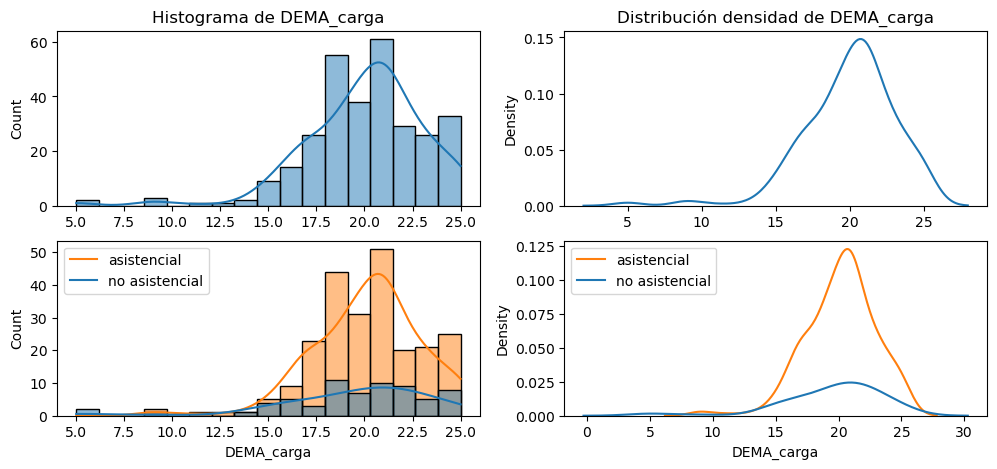

Resultados test shapiro - DEMA_carga
                    stat  test_shapiro
Total           0.918071  9.566571e-12
Asistencial     0.871526  5.975980e-06
No asistencial  0.952232  5.517065e-07

Resultado Mann-Whitney test: 7388.5
P-valor asociado: 0.5897942045551072

Medida d de cohen: -0.2052022145111651
Variable CT_total


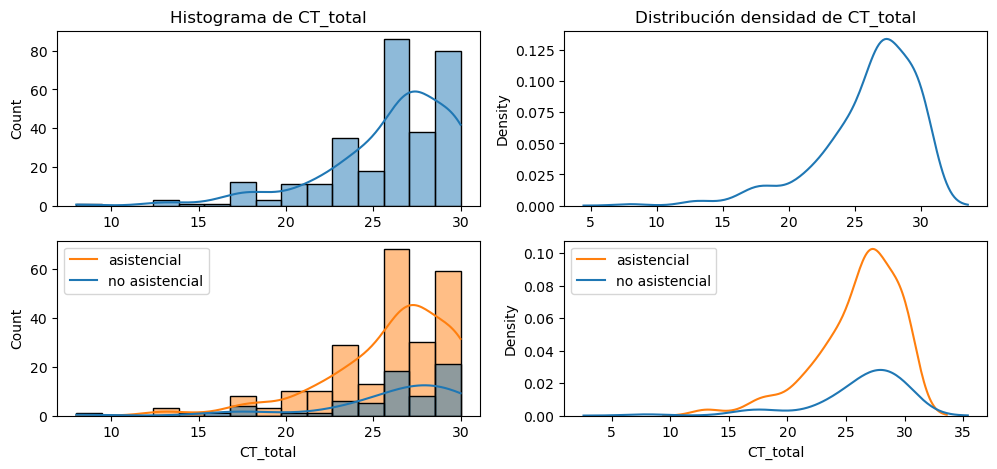

Resultados test shapiro - CT_total
                    stat  test_shapiro
Total           0.861846  1.018892e-15
Asistencial     0.784201  1.872504e-08
No asistencial  0.882245  1.646684e-12

Resultado Mann-Whitney test: 8281.5
P-valor asociado: 0.36484705842438614

Medida d de cohen: 0.042327037373136166
Variable Lid_total


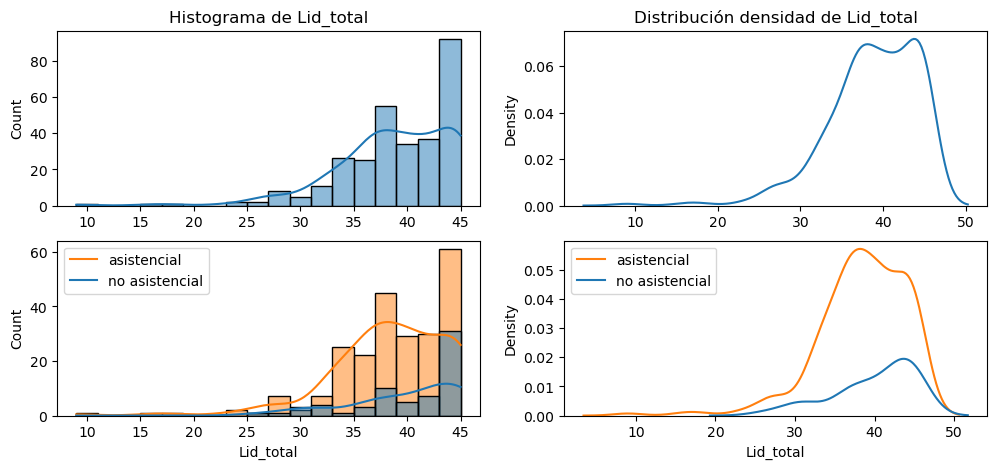

Resultados test shapiro - Lid_total
                    stat  test_shapiro
Total           0.892476  9.862417e-14
Asistencial     0.861788  2.855558e-06
No asistencial  0.889891  4.916954e-12

Resultado Mann-Whitney test: 9122.5
P-valor asociado: 0.023770017720769223

Medida d de cohen: 0.2797268170547756
Variable EXT_casa


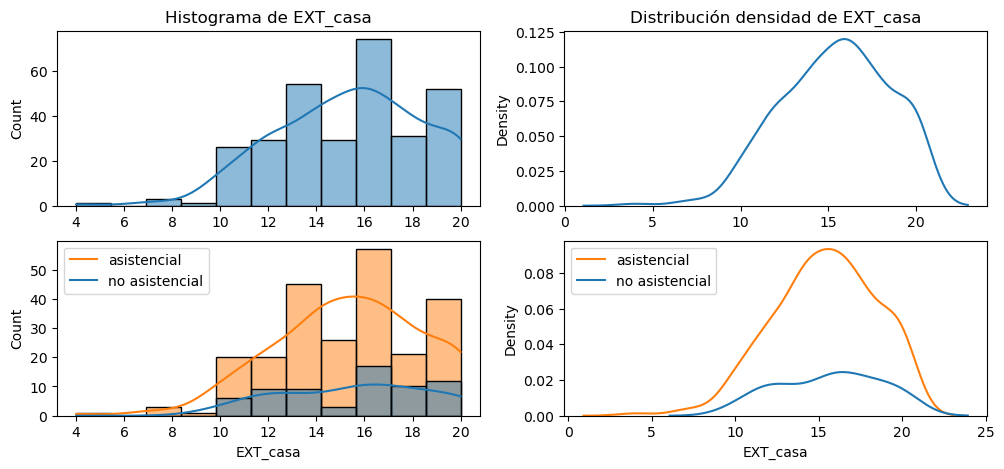

Resultados test shapiro - EXT_casa
                    stat  test_shapiro
Total           0.960854  3.197657e-07
Asistencial     0.935009  1.856982e-03
No asistencial  0.962408  7.917934e-06

Resultado Mann-Whitney test: 8059.5
P-valor asociado: 0.5860761700146584

Medida d de cohen: 0.08702134605046616
Variable EXT_zona


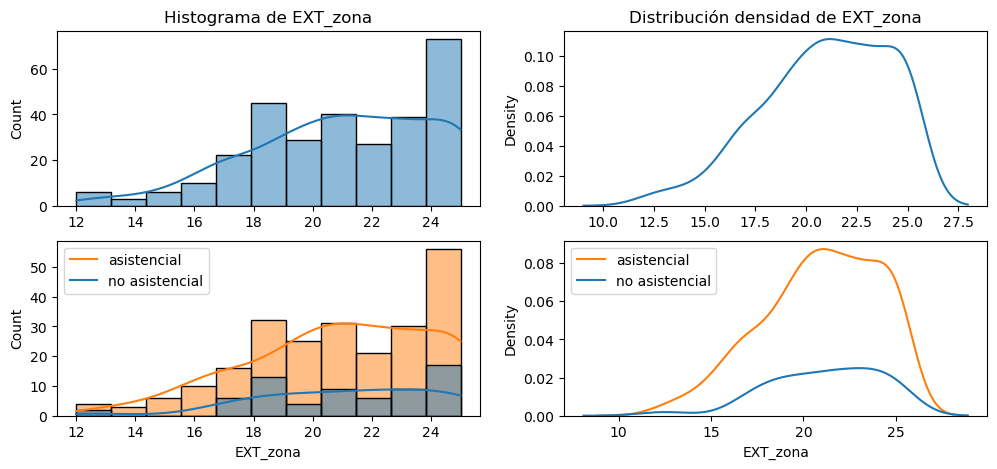

Resultados test shapiro - EXT_zona
                    stat  test_shapiro
Total           0.940830  1.352427e-09
Asistencial     0.929620  1.055669e-03
No asistencial  0.941332  4.424047e-08

Resultado Mann-Whitney test: 8002.5
P-valor asociado: 0.6506265545256846

Medida d de cohen: 0.07300517692294574
Variable Dem_sitio


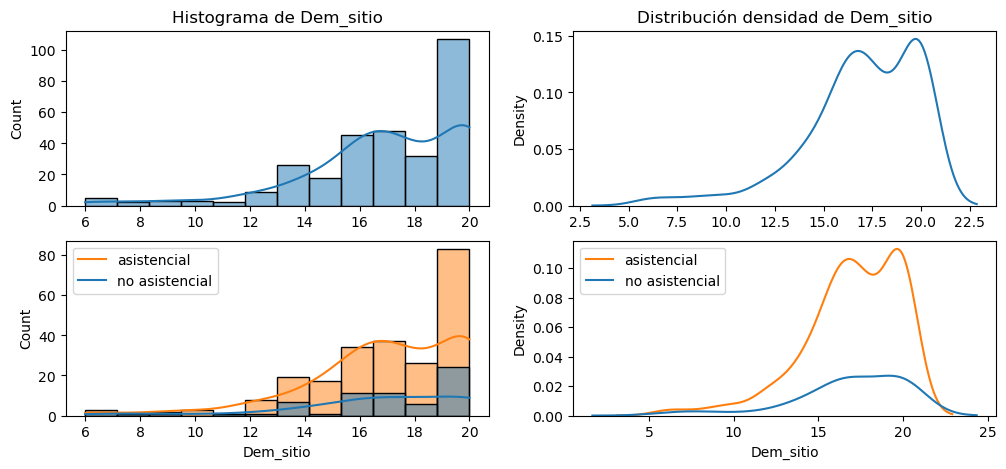

Resultados test shapiro - Dem_sitio
                    stat  test_shapiro
Total           0.862615  1.132273e-15
Asistencial     0.829371  2.965241e-07
No asistencial  0.874143  5.439823e-13

Resultado Mann-Whitney test: 7860.0
P-valor asociado: 0.8220951943095617

Medida d de cohen: -0.038358459425209476
Variable Dem_emo


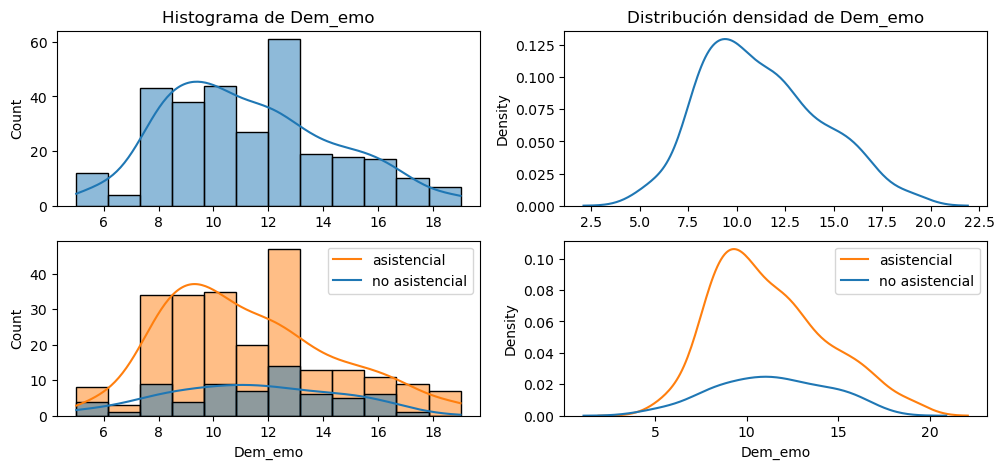

Resultados test shapiro - Dem_emo
                    stat  test_shapiro
Total           0.964058  8.834070e-07
Asistencial     0.969204  9.978357e-02
No asistencial  0.952277  5.578556e-07

Resultado Mann-Whitney test: 8070.5
P-valor asociado: 0.5737776532485055

Medida d de cohen: 0.027493351556620495


In [131]:
distribucion('DEMA_riesgo')
distribucion('DEMA_carga')
distribucion('CT_total')
distribucion('Lid_total')
distribucion('EXT_casa')
distribucion('EXT_zona')
distribucion('Dem_sitio')
distribucion('Dem_emo')

In [717]:
columns = ['Lid_total', 'CT_total', 'DEMA_riesgo','DEMA_carga',
           'Dem_sitio', 'Dem_emo', 'Reco_total', 'EXT_casa', 'EXT_zona']
y_labels = ['Lid_total', 'CT_total', 'DEMA_riesgo','DEMA_carga',
           'Dem_sitio', 'Dem_emo', 'Reco_total', 'EXT_casa', 'EXT_zona']

data.columns.to_list() 
columns.append('catprofesi')
columns_to_delete = [col for col in data.columns.to_list() if col not in columns]
columns.remove('catprofesi')

NameError: name 'columns' is not defined

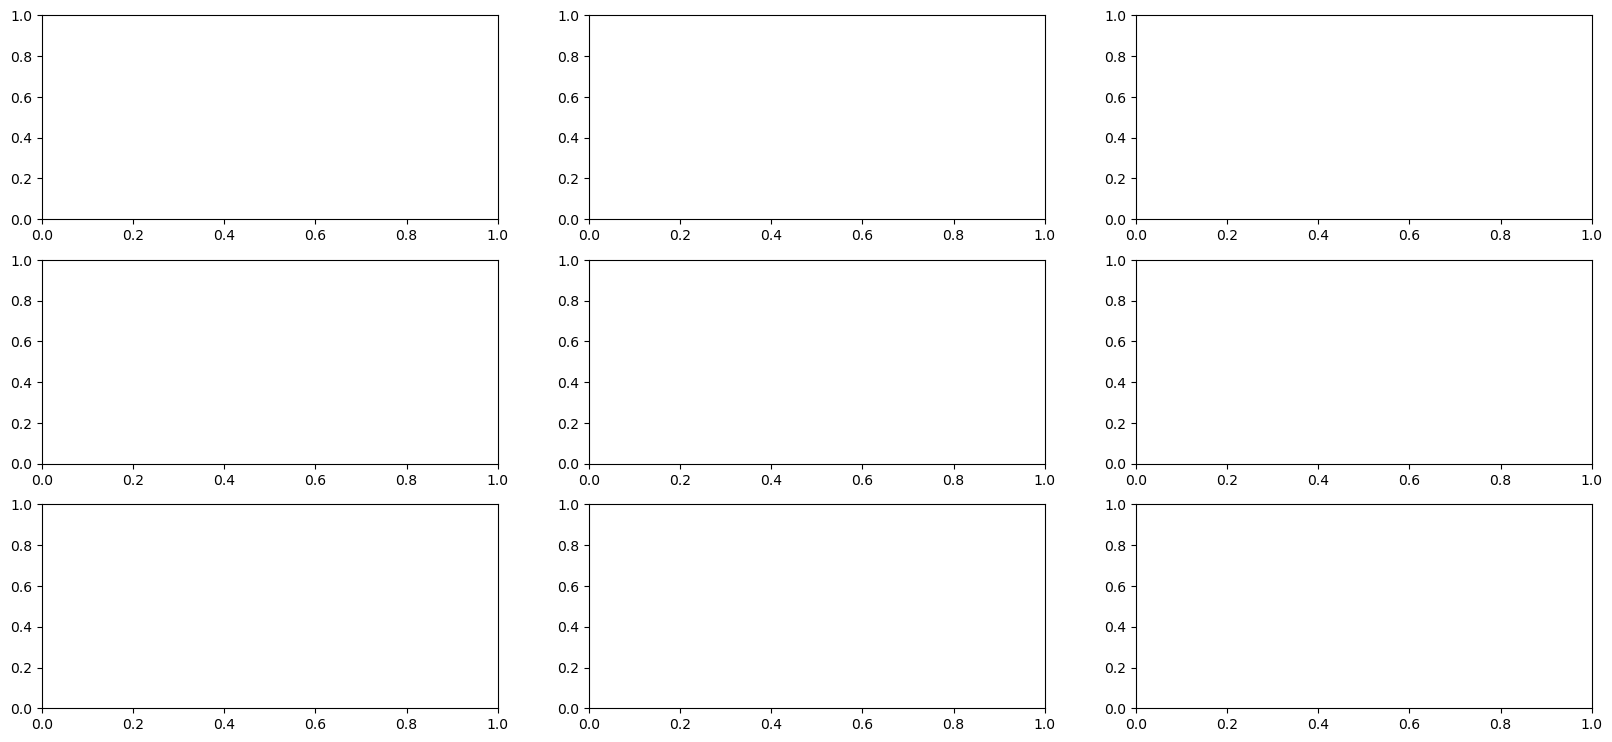

In [132]:
fig, ax = plt.subplots(3,3, figsize=(20,9))

for idx, feature in enumerate(columns):
    list0 = df[df['catprofesi'] == 0][feature].tolist()
    list1 = df[df['catprofesi'] == 1][feature].tolist()
    column = [list0, list1]
    
    row_idx = idx // 3
    col_idx = idx % 3
    
    box = ax[row_idx, col_idx].boxplot(column, notch = True, patch_artist = True, showmeans = True,
                                      meanprops = {'marker': 's', 'markerfacecolor': 'white', 'markeredgecolor': 'red'})
    
    ax[row_idx, col_idx].yaxis.set_major_locator(MaxNLocator(integer = True))
    ax[row_idx, col_idx].set_xticklabels(['Asistencial', 'No asistencial'], size = 15)
    ax[row_idx, col_idx].set_ylabel(y_labels[idx], size = 15)
    
    colors = ['#ffb482', '#a1c9f4']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        
    if idx >= 6:
        ax[row_idx, col_idx].set_xticklabels(['Asistencial', 'No asistencial'], size=15)
    else:
        ax[row_idx, col_idx].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[row_idx, col_idx].legend([box['medians'][0], box['means'][0]], ['Median', 'Mean'], loc='upper right')
    ax[row_idx, col_idx].grid(True)
    
plt.show()

pdf = data.copy()
pdf['catprofesi'] = df['catprofesi'].replace([0,1],[2,2])
pdf.drop(columns = columns_to_delete, axis=1,inplace=True)
pdf = pd.concat([pdf, df.drop(columns = columns_to_delete, axis=1)], ignore_index=True).groupby('catprofesi') \
    .describe().sort_index()

# Summary statistics of numerical features by groups
print('\n\n' + start + "Estadisticas descriptivas:" + end + '\n')
pdf = pdf.unstack().unstack(1).sort_index(level=[0, 1]).rename_axis(index=('Numerical features',
                                                                           'catprofesi'), axis=1)
pdf = pdf[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

sumstatsfmt(pdf)

# Regression Analysis

In [1017]:
# Partial Least Square Regression
def PLS_analysis(x,y,n):
    '''
    
    
    Parametros
    ----------
    x: Dataframe
        Variables independientes
    y: Dataframe
        Variable dependiente
    n: int
        Número de componentes para el PLS
    '''
    
    # PLS (Partial Least Square Regression)
    pls = PLSRegression(n)
    pls.fit(x,y)
    Y_pred = pls.predict(x)
    Y_pred = pd.DataFrame(Y_pred, columns=['inhibicion_Ac', 'inhibicion_(Tmp_RTA)'])
    print(start + 'Predicciones por PLS' + end)
    print(Y_pred.head())
    
    # Comparative between actual vs prediction values
    plt.figure()
    plt.title('Predicted vs test data')
    plt.scatter(y['inhibicion_(Tmp_RTA)'], y['inhibicion_Ac'], edgecolor="k", c="red", s=50, alpha=0.4, label="Real data")
    plt.scatter(Y_pred['inhibicion_(Tmp_RTA)'], Y_pred['inhibicion_Ac'], edgecolor="k", c="blue", s=50, alpha=0.4, label="Predicted data")
    plt.xlabel('inhibicion_(Tmp_RTA)', size=12)
    plt.ylabel('inhibicion_Ac', size=12)
    plt.legend()
    plt.show()

    results = pd.DataFrame({'Variable': ['inhibicion_Ac', 'inhibicion_(Tmp_RTA)'],
             'R2 Score': [r2_score(Y['inhibicion_Ac'], Y_pred['inhibicion_Ac']), r2_score(Y['inhibicion_(Tmp_RTA)'], Y_pred['inhibicion_(Tmp_RTA)'])],
             'MSE': [mean_squared_error(Y['inhibicion_Ac'], Y_pred['inhibicion_Ac']), mean_squared_error(Y['inhibicion_(Tmp_RTA)'], Y_pred['inhibicion_(Tmp_RTA)'])],
             'MAE': [mean_absolute_error(Y['inhibicion_Ac'], Y_pred['inhibicion_Ac']) , mean_absolute_error(Y['inhibicion_(Tmp_RTA)'], Y_pred['inhibicion_(Tmp_RTA)'])]})
    results = results.set_index('Variable').round(3)
    return results

C:\Users\claud\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


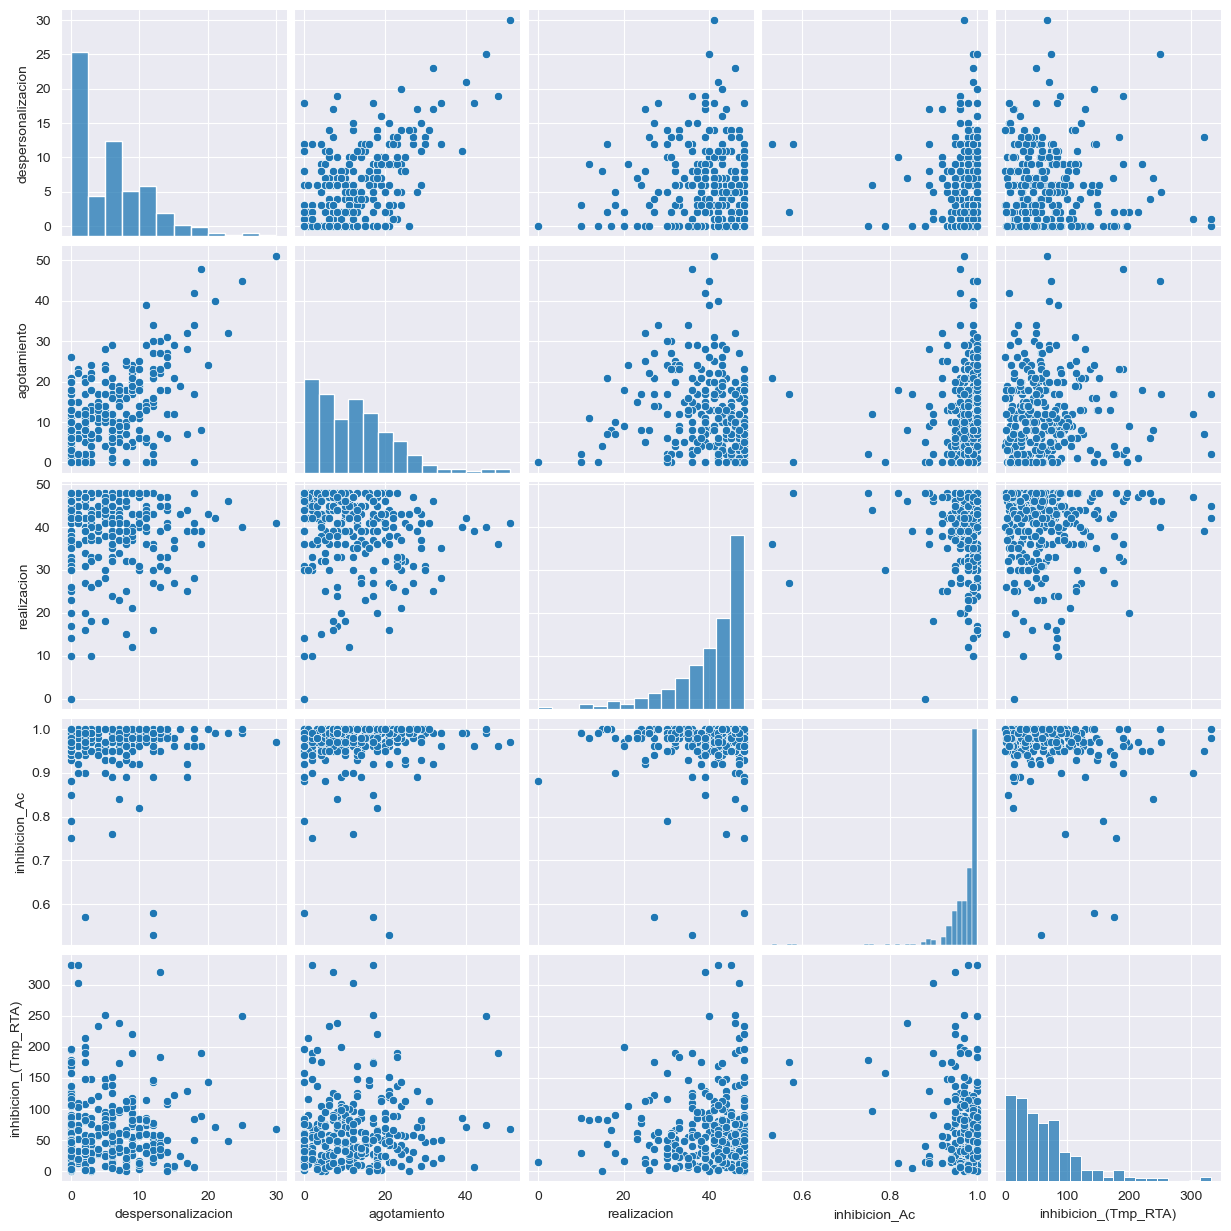

In [1020]:
X = data[['despersonalizacion', 'realizacion', 'agotamiento']]
Y = data[['inhibicion_Ac', 'inhibicion_(Tmp_RTA)']]

sns.pairplot(control_inhibitorio[['despersonalizacion','agotamiento', 'realizacion', 'inhibicion_Ac', 'inhibicion_(Tmp_RTA)']])

Predicciones por PLS
   inhibicion_Ac  inhibicion_(Tmp_RTA)
0       0.972775             67.893297
1       0.968168             63.369627
2       0.969135             63.514285
3       0.951957             55.653372
4       0.974623             67.091427


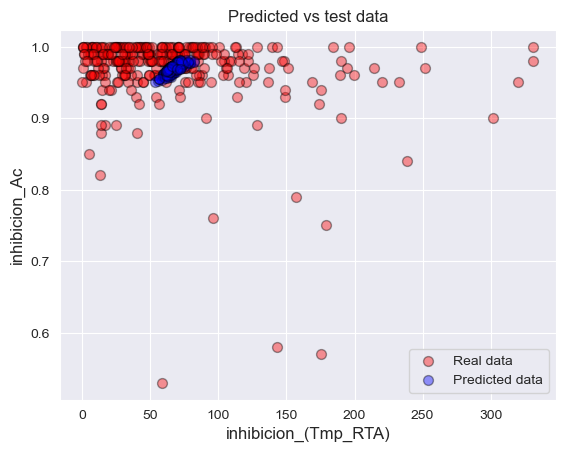

R2 Score       MSE     MAE
Variable                                        
inhibicion_Ac            0.010     0.003   0.028
inhibicion_(Tmp_RTA)     0.004  3419.619  42.417

In [1018]:
PLS_analysis(X,Y,2)

In [1021]:
residuals = Y - Y_pred
residuals

inhibicion_Ac  inhibicion_(Tmp_RTA)
0        -0.042775             80.796703
1         0.021832              6.080373
2        -0.019135            -23.134285
3         0.038043             29.716628
4        -0.014623            -26.731427
..             ...                   ...
295      -0.026300            -42.916404
296       0.026806            -19.430506
297       0.031572            114.736589
298       0.031392             71.111044
299      -0.019115            -71.413800

[300 rows x 2 columns]

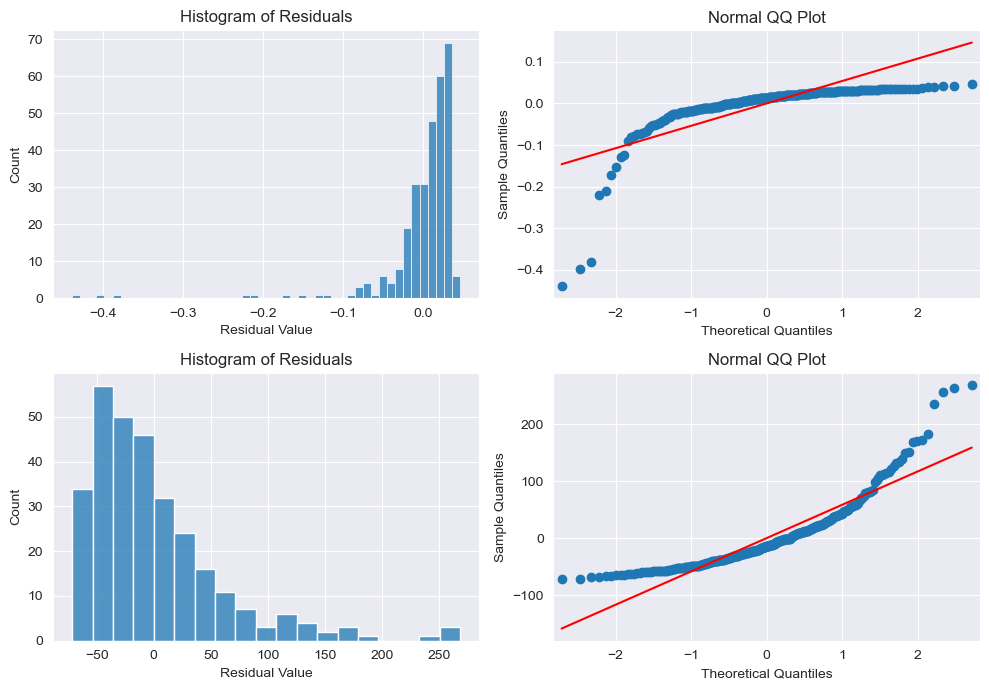

In [1029]:
fig, axes = plt.subplots(2, 2, figsize = (10,7))

sns.histplot(residuals['inhibicion_Ac'], ax=axes[0,0])

axes[0,0].set_xlabel("Residual Value")
axes[0,0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals.
sm.qqplot(residuals['inhibicion_Ac'], line='s',ax = axes[0,1])

axes[0,1].set_title("Normal QQ Plot")

#
sns.histplot(residuals['inhibicion_(Tmp_RTA)'], ax=axes[1,0])

axes[1,0].set_xlabel("Residual Value")
axes[1,0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals.
sm.qqplot(residuals['inhibicion_(Tmp_RTA)'], line='s',ax = axes[1,1])

axes[1,1].set_title("Normal QQ Plot")
plt.tight_layout()
plt.show()

In [1007]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# XGBoost regressor model
model = GradientBoostingRegressor()
xgb = MultiOutputRegressor(model)

grid = {
    'estimator__n_estimators': [75, 100, 125, 150],
    'estimator__learning_rate': [0.01, 0.1, 0.2],}

scoring = {'r2': make_scorer(r2_score)}

grid1 = GridSearchCV(estimator=xgb, param_grid= grid, cv=3, verbose=1, scoring = scoring, refit='r2')
grid1.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor()),
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.2],
                         'estimator__n_estimators': [75, 100, 125, 150]},
             refit='r2', scoring={'r2': make_scorer(r2_score)}, verbose=1)

In [1008]:
xgb = grid1.best_estimator_
grid = {'estimator__max_depth': [3, 5, 7],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],}

grid2 = GridSearchCV(estimator=xgb, param_grid= grid, cv=3, verbose=1, scoring = scoring, refit='r2')
grid2.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                                n_estimators=75)),
             param_grid={'estimator__max_depth': [3, 5, 7],
                         'estimator__min_samples_leaf': [1, 2, 4],
                         'estimator__min_samples_split': [2, 5, 10]},
             refit='r2', scoring={'r2': make_scorer(r2_score)}, verbose=1)

In [1009]:
xgb = grid1.best_estimator_
y_pred = xgb.predict(X_test)

In [983]:
y_pred = pd.DataFrame(y_pred, columns=['inhibicion_Ac', 'inhibicion_(Tmp_RTA)'])
y_test = pd.DataFrame(y_test, columns=['inhibicion_Ac', 'inhibicion_(Tmp_RTA)'])

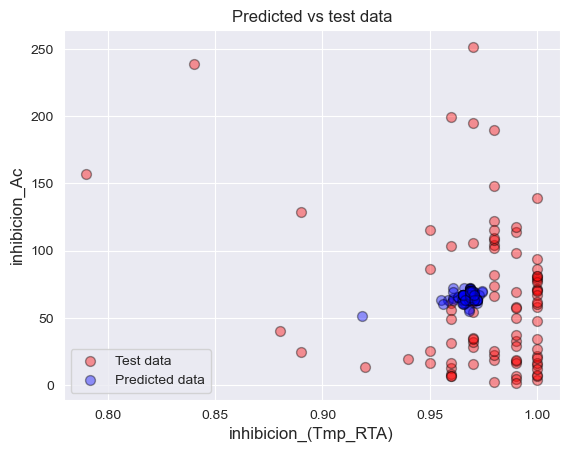

Coefficient of Determination:
0.09992579687489911


In [1016]:
#y_test = y_test.to_numpy()
plt.figure()

plt.title('Predicted vs test data')
plt.scatter(y_test[:, 0], y_test[:, 1], edgecolor="k", c="red", s=50, alpha=0.4, label="Test data")
plt.scatter(y_pred[:, 0], y_pred[:, 1], edgecolor="k", c="blue", s=50, alpha=0.4, label="Predicted data")
plt.xlabel('inhibicion_(Tmp_RTA)', size=12)
plt.ylabel('inhibicion_Ac', size=12)
plt.legend()
plt.show()

print(start +'Coefficient of Determination:' + end)
print(xgb.score(X, Y))

In [984]:
results2 = pd.DataFrame({'Variable': ['inhibicion_Ac', 'inhibicion_(Tmp_RTA)'],
             'R2 Score': [r2_score(y_test['inhibicion_Ac'], y_pred['inhibicion_Ac']), r2_score(y_test['inhibicion_(Tmp_RTA)'], y_pred['inhibicion_(Tmp_RTA)'])],
             'MSE': [mean_squared_error(y_test['inhibicion_Ac'], y_pred['inhibicion_Ac']), mean_squared_error(y_test['inhibicion_(Tmp_RTA)'], y_pred['inhibicion_(Tmp_RTA)'])],
             'MAE': [mean_absolute_error(y_test['inhibicion_Ac'], y_pred['inhibicion_Ac']) , mean_absolute_error(y_test['inhibicion_(Tmp_RTA)'], y_pred['inhibicion_(Tmp_RTA)'])]})

results2 = results2.set_index('Variable').round(3)
results2

R2 Score       MSE     MAE
Variable                                        
inhibicion_Ac           -0.056     0.001   0.024
inhibicion_(Tmp_RTA)    -0.031  2958.199  42.515

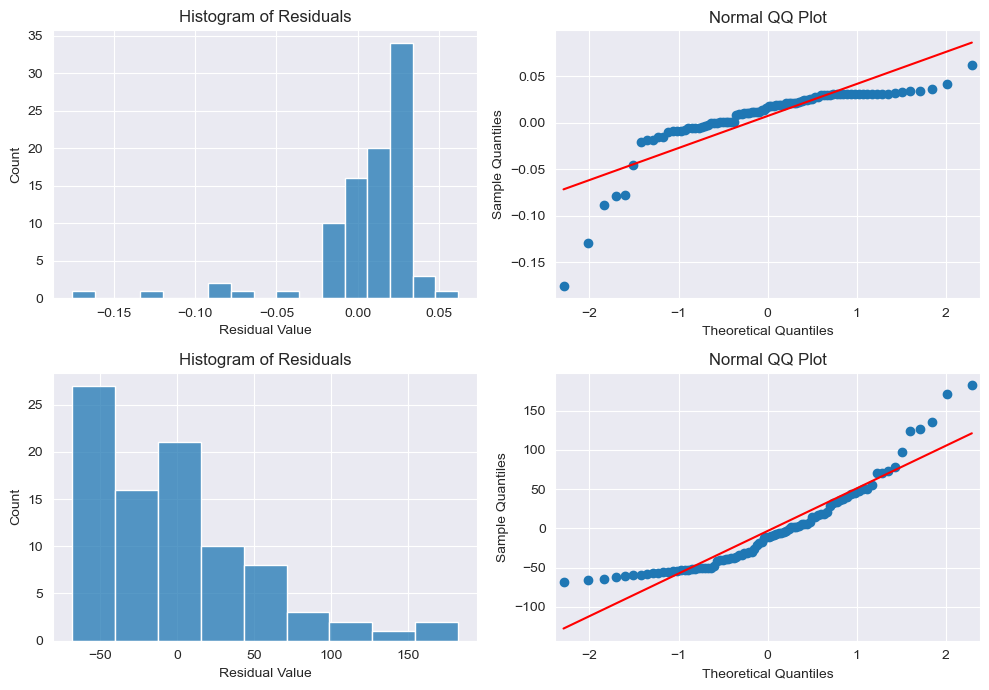

In [1032]:
residuals = y_test - y_pred
fig, axes = plt.subplots(2, 2, figsize = (10,7))

sns.histplot(residuals[:, 0], ax=axes[0,0])

axes[0,0].set_xlabel("Residual Value")
axes[0,0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals.
sm.qqplot(residuals[:, 0], line='s',ax = axes[0,1])

axes[0,1].set_title("Normal QQ Plot")

#
sns.histplot(residuals[:, 1], ax=axes[1,0])

axes[1,0].set_xlabel("Residual Value")
axes[1,0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals.
sm.qqplot(residuals[:, 1], line='s',ax = axes[1,1])

axes[1,1].set_title("Normal QQ Plot")
plt.tight_layout()
plt.show()

In [985]:
X = data[['despersonalizacion', 'realizacion', 'agotamiento', 'catprofesi']]
pls = PLSRegression(n_components = 2)
pls.fit(X,Y)
Y_pred = pls.predict(X)

In [ ]:
Y_pred = pd.DataFrame(Y_pred, columns=['inhibicion_Ac', 'inhibicion_(Tmp_RTA)'])
Y_pred.head()

results = pd.DataFrame({'Variable': ['inhibicion_Ac', 'inhibicion_(Tmp_RTA)'],
             'R2 Score': [r2_score(Y['inhibicion_Ac'], Y_pred['inhibicion_Ac']), r2_score(Y['inhibicion_(Tmp_RTA)'], Y_pred['inhibicion_(Tmp_RTA)'])],
             'MSE': [mean_squared_error(Y['inhibicion_Ac'], Y_pred['inhibicion_Ac']), mean_squared_error(Y['inhibicion_(Tmp_RTA)'], Y_pred['inhibicion_(Tmp_RTA)'])],
             'MAE': [mean_absolute_error(Y['inhibicion_Ac'], Y_pred['inhibicion_Ac']) , mean_absolute_error(Y['inhibicion_(Tmp_RTA)'], Y_pred['inhibicion_(Tmp_RTA)'])]})

results = results.set_index('Variable').round(3)
results